In [78]:
import time
import numpy as np
from datetime import datetime, timedelta
import shutil
import pickle
import talib
import copy
import gc

import pandas as pd
pd.options.display.max_columns=100
pd.options.display.max_rows=100

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
#warnings.filterwarnings("ignore")

In [79]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import (mean_squared_error, accuracy_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import interpolate

In [80]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe)

In [81]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2020.csv',
                 'GBPUSD_1h_2003-2020.csv',
                 'USDJPY_1h_2003-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 'USDCHF_1h_2003-2020.csv',
                ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2021-2-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2020.csv
GBPUSD_1h_2003-2020.csv
USDJPY_1h_2003-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv
USDCHF_1h_2003-2020.csv


In [82]:
# loaded_files_a = prep_fx_data(fx_files)
# start = '2000-01-01'
# end = '2020-11-1'
# ## download data
# all_stock_data = download_data_local_check('SP500', start, end)
# loaded_files_b = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)
# loaded_files = {**loaded_files_a, **loaded_files_b}

In [83]:
def ohlc_diff(data):
    prev_close = data['close'].shift(1)
    for col in ['open', 'high', 'low', 'close']:
        data[f'ohlc_diff_{col}'] = (data[col] - prev_close) / prev_close
        data.loc[data.index.values[0], f'ohlc_diff_{col}'] = 0
    return data


def add_opposite_bars(loaded_files, var):
    already_done = any(['opposite' in inst for inst in loaded_files.keys()])
    if already_done:
        print('already done opposite bars')
        return
    
    new_data = {}
    for inst, data in loaded_files.items():
        data = data.copy()
        if 'Volume' in data.columns:
            data.drop('Volume', axis='columns', inplace=True)
        data = data[(data.index >= var.train_split['start']) 
                    & (data.index < var.train_split['train'])]
        if len(data) < 100:
            continue
        cols = ['open','high','low','close']
        data.columns = cols
        data = ohlc_diff(data)
        data['close_opp'] = ((data['ohlc_diff_close'] * -1) + 1).cumprod() * data['close'][0]
        prev_close = data['close_opp'].shift(1)
        data['open_opp'] = ((data['ohlc_diff_open'] * -1) + 1) * prev_close
        data['low_opp'] = ((data['ohlc_diff_high'] * -1) + 1) * prev_close
        data['high_opp'] = ((data['ohlc_diff_low'] * -1) + 1) * prev_close
        opposite_bars = data[['open_opp','high_opp','low_opp','close_opp']]
        opposite_bars.columns = cols
        opposite_bars.loc[opposite_bars.index.values[0], :] = data[cols].values[0]
        new_data[f'opp-{inst}'] = opposite_bars
    loaded_files.update(new_data)


def add_ma_smooth(data, cols, ma_smooth, ma_smooth_diff=False):
    for col in cols:
        data[f'ma_smooth_{col}'] = data[col].rolling(window=ma_smooth).mean()
        if var.ma_smooth_diff:
            data[f'ma_smooth_{col}'] = data[f'ma_smooth_{col}'].pct_change()
    return data


def normalize_bars(data, cols, col_to_norm='ohlc_diff', norm_ma=1000):
    for col in cols:
        mins = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).min()
        maxs = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).max()
        means = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).mean()
        ranges = maxs - mins
        #data[col] = (data[col] - mins) / ranges
        data[f'norm_{col_to_norm}{col}'] = (data[f'{col_to_norm}{col}'] - means) / ranges
        data[f'norm_{col_to_norm}{col}'].replace([np.inf, -np.inf], 0, inplace=True)
    return data

def sliding_window_data(data, cols_to_shift, window, timestep):
    # create window data
    for win in range(window):
        for i, col in enumerate(cols_to_shift):
            row_idx = win * len(cols_to_shift) # num_cols
            data[str(row_idx + i)] = data[col].shift(-win)
    return data


def window_labels(data, window, timestep, data_percentage_diff):
    # add time step labels
    label_bar = data['close'].shift(-((window - 1) + timestep))
    if data_percentage_diff == False:
        data['num_bars_label'] = label_bar
    elif data_percentage_diff == 'close_diff':
        last_bar = data['close'].shift(-(window - 1))
        data['num_bars_label'] = (label_bar - last_bar) / last_bar
    return data


def create_sliding_window(data, main_col, var):
    cols_to_shift = [f'{main_col}{col}' for col in var.cols]
    data = sliding_window_data(data, cols_to_shift, var.window, var.num_bars)
    data = window_labels(data, var.window, var.num_bars, var.data_percentage_diff)
    return data


def rolling_bar_volatility(data, ma=100):
    bar_high_low = data['high'] - data['low']
    bar_high_low_pct_diff = bar_high_low / data['high']
    roll_avg_bar_pct_size = (bar_high_low_pct_diff.rolling(window=ma, min_periods=0).mean()
                            .reset_index(drop=True))
    roll_avg_bar_pct_size = np.array(roll_avg_bar_pct_size)
    return roll_avg_bar_pct_size


def triple_barrier(data, window=1, bar_horizon=1000, bar_size_ma=100, stop_size=3,
                   target_multiple=1, target_stop_type='high_low', problem_type='binary',
                   just_labels=False):

    last_bars = data['close']
    roll_avg_bar_pct_size = rolling_bar_volatility(data, ma=bar_size_ma)
    child_pct = roll_avg_bar_pct_size
    child_distance = last_bars * (child_pct * stop_size)
    stop_series = last_bars - child_distance
    target_series = last_bars + (child_distance * target_multiple)

    if target_stop_type == 'high_low':
        highs = data['high'].to_numpy()
        lows = data['low'].to_numpy()
        opens = data['open'].to_numpy()
    elif target_stop_type == 'close':
        highs = lows = data['close'].to_numpy()
        opens = data['open'].to_numpy()
    else:
        raise Exception('target_stop_type not recognised!')
        
    closes = data['close'].to_numpy()
    targets = target_series.to_list()
    stops = stop_series.to_list()

    not_hit_target_or_stop = 0
    hit_target_and_stop = 0
    gap_stop = 0
    gap_target = 0
    labels = []
    for idx in range(len(closes)):
        if idx == (len(closes) - 1):
            labels.append([np.nan, closes[-1], 'neither'])
            break

        last_bar = last_bars[idx]
        target = targets[idx]
        stop = stops[idx]
        start_idx = idx + 1
        future_highs = highs[start_idx: start_idx + bar_horizon]
        future_lows = lows[start_idx: start_idx + bar_horizon]
        future_closes = closes[start_idx: start_idx + bar_horizon]
        future_opens = opens[start_idx: start_idx + bar_horizon]
        
        larger_than_target = future_highs > target
        target_idx = None if larger_than_target.sum() == 0 else larger_than_target.argmax()
        smaller_than_stop = future_lows < stop
        stop_idx = None if smaller_than_stop.sum() == 0 else smaller_than_stop.argmax()

        if target_idx == None and stop_idx == None:
            # manual exit at end of bar horizon
            not_hit_target_or_stop += 1
            fraction_target_stop = (future_closes[-1] - last_bar) / child_distance[idx]
            labels.append([fraction_target_stop, future_closes[-1], 'neither'])
        elif target_idx == None:
            labels.append([-1, stop, 'stop'])
        elif stop_idx == None:
            labels.append([target_multiple, target, 'target'])
        elif stop_idx < target_idx:
            if future_opens[stop_idx] < stop:
                gap_stop += 1
                fraction_target_stop = (future_opens[stop_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'stop'])
            else:
                labels.append([-1, stop, 'stop'])
        elif target_idx < stop_idx:
            if future_opens[target_idx] > target:
                gap_target += 1
                fraction_target_stop = (future_opens[target_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[target_idx], 'target'])
            else:
                labels.append([target_multiple, target, 'target'])
        elif target_idx == stop_idx:
            hit_target_and_stop += 1
            labels.append([-1, stop, 'stop'])
        else:
            raise Exception('stop or target not recognised, bug!')
       
    print(f'# trades not hit target or stop: {not_hit_target_or_stop}')
    print(f'# trades hit both target and stop: {hit_target_and_stop}')
    print(f'# trades gapped stop: {gap_stop} | # trades gapped target: {gap_target}')
        
    target_stops = pd.DataFrame(labels, columns=['perc_target_stop',
                                                 'price_target_stop',
                                                 'target_stop_class'])
    target_stops.index = data.index
    if just_labels:
        target_stops.drop(['price_target_stop', 'target_stop_class'], axis='columns', inplace=True)
    else:
        target_stops['last_bar'] = last_bars
        target_stops['child_pct'] = child_pct
        target_stops['child_dist'] = child_distance
        target_stops['target_level'] = target_series
        target_stops['stop_level'] = stop_series
            
    if problem_type == 'binary':
        target_stops['target'] = (target_stops['perc_target_stop'] >= 0).astype(int) 
        #print('dropping trades that did not meet a target or stop!')
        #data = data[target_stops['target_stop_class'].isin(['stop', 'target'])]
    elif problem_type == 'category':
        hit_target = target_stops['target_stop_class'] == 'target'
        hit_stop = target_stops['target_stop_class'] == 'stop'
        hit_neither = target_stops['target_stop_class'] == 'neither'
        target_stops.loc[hit_target, 'target'] = 2
        target_stops.loc[hit_stop, 'target'] = 0
        target_stops.loc[hit_neither, 'target'] = 1
        
    data = pd.concat([data, target_stops], axis=1)
    return data, list(target_stops.columns)


import plotly.graph_objects as go
from plotly.subplots import make_subplots
def plot_target_stop(data, var, bars, start_idx, v_line_delta, h_line_price, plotly=True):
    cols = ['open', 'high', 'low', 'close']
    plot_cols = [f'last_{col}' for col in cols]
    if var.bb_filter:
        cols = cols + ['upper_bb', 'lower_bb', 'BB_dir']
    data = data[cols + plot_cols + ['stop_level', 'target_level', 'perc_target_stop']].copy()
    
    if plotly:
        # plotly
        fig = make_subplots(cols=1, rows=2, shared_xaxes=True, vertical_spacing=0.02,
                            row_heights=[0.7, 0.3])
        fig.add_trace(go.Candlestick(x=data.index, open=data['last_open'], high=data['last_high'],
                                     low=data['last_low'], close=data['last_close'], name='candles'),
                                     row=1, col=1)  
        if var.bb_filter:
            fig.add_trace(go.Scatter(x=data.index, y=data['upper_bb'], name='upper_bb',
                                     line={'color':'blue', 'width':0.5}), row=1, col=1)
            fig.add_trace(go.Scatter(x=data.index, y=data['lower_bb'], name='upper_bb',
                                     line={'color':'blue', 'width':0.5}), row=1, col=1)
        fig.add_trace(go.Scatter(x=data.index, y=data['stop_level'], name='stop_level',
                                 line={'color':'red', 'width':0.5}), row=1, col=1)
        fig.add_trace(go.Scatter(x=data.index, y=data['target_level'], name='target_level',
                                 line={'color':'red', 'width':0.5}), row=1, col=1)
        fig.add_trace(go.Scatter(x=data.index, y=data['BB_dir'], name='BB_dir',
                         line={'color':'black', 'width':2}), row=2, col=1)
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()
    
    else:
        # matplotlib
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6),
                               gridspec_kw={'height_ratios': [3, 1]})
        plt.subplots_adjust(wspace=0, hspace=0)
        plot_frame = data[plot_cols + ['stop_level', 'target_level']][start_idx:start_idx+bars]
        plot_frame.plot(ax=ax[0], style=['g','grey','grey','r','b','b','k--','k--'])
        v_line_idx = plot_frame.index[0] + v_line_delta
        ax[0].axvline(v_line_idx, c='k', linewidth=1)
        ax[0].axhline(h_line_price, c='k', linewidth=1)

        data['perc_target_stop'][start_idx:start_idx+bars].plot(ax=ax[1])
        ax[1].axvline(v_line_idx, c='k', linewidth=1)
        plt.show()
    return data[start_idx:start_idx+bars]

    
def bb_data_filter(data, bb_std=2):
    data['upper_bb'], _, data['lower_bb'] = talib.BBANDS(
        data['close'], timeperiod=20, nbdevup=bb_std, nbdevdn=bb_std)
    data.loc[data[(data['close'] > data['upper_bb'])].index, 'BB_dir'] = 1
    data.loc[data[(data['close'] < data['lower_bb'])].index, 'BB_dir'] = 0
    filter_bb = (data['close'] > data['upper_bb']) | (data['close'] < data['lower_bb'])
    print(f'before filter {len(data)} after filter {filter_bb.sum()}')
    #data = data[filter_bb]
    cols = ['upper_bb', 'lower_bb', 'BB_dir']
    return data, cols, filter_bb


def consec_bars_filter(data, consec_bars=5):
    def shift_bars(series, consec_bars):
        consec_df = pd.DataFrame()
        for b in range(1, consec_bars + 1):
            consec_df[b] = series.shift(b)
        consec_filter = consec_df.sum(axis=1) == consec_bars
        return consec_filter
        
    data[f'consec_up'] = shift_bars((data['close'] > data['open']), consec_bars)
    data[f'consec_down'] = shift_bars((data['close'] < data['open']), consec_bars)
    filter_consec = (data['consec_up'] == True) | (data['consec_down'] == True)
    print(f'before filter {len(data)} after filter {filter_consec.sum()}')
    #data = data[filter_consec]
    cols = ['consec_up', 'consec_down']
    return data, cols, filter_consec
    
    
def create_dataset(loaded_files, var):
    final_data = []
    for i, (inst, data) in enumerate(loaded_files.items()):
        print(i, inst)
        
        if i > var.num_instruments:
            opps = [x for x in loaded_files.keys() if 'opp-' in x][:var.num_instruments]
            if inst not in opps:
                continue
            
        if len(data) < (var.window + 100):
            print(f'{inst} not enough data')
            continue
            
        data = data.copy()
        if 'Volume' in list(data.columns):
            data.drop('Volume', axis=1, inplace=True)
        cols = ['open', 'high', 'low', 'close']
        data.columns = cols
        if var.resample:
            data = data.resample(var.resample).agg({'open':'first','high':'max',
                                                    'low':'min','close':'last'})
            data.dropna(inplace=True)

        if var.target_stop:
            data, target_stop_cols = triple_barrier(data, var.window, var.bar_horizon,
                                     var.bar_size_ma, var.stop_size, var.target_multiple,
                                     var.target_stop_type,
                                     var.problem_type, just_labels=False)
            
        if var.bb_filter:
            #data, bb_cols, filter_rows = bb_data_filter(data, bb_std=var.bb_filter)
            data, bb_cols, filter_rows = consec_bars_filter(data, consec_bars=var.bb_filter)
        
        main_col = ''
        data = ohlc_diff(data)
        if var.data_percentage_diff:
            main_col = 'ohlc_diff_'  
        if var.ma_smooth:
            data = add_ma_smooth(data, var.cols, var.ma_smooth)
            main_col = 'ma_smooth'
        if var.standardize:
            data = normalize_bars(data, var.cols, col_to_norm=main_col, norm_ma=var.norm_ma)
            main_col = f'norm_{main_col}'
            
        data = create_sliding_window(data, main_col, var)
        last_cols = ['last_open', 'last_high', 'last_low', 'last_close']
        data[last_cols] = data[['open', 'high', 'low', 'close']].shift(-(var.window - 1))
        if var.target_stop:
            data[target_stop_cols] = data[target_stop_cols].shift(-(var.window - 1))
            last_bar_time = pd.Series(data.index).shift(-(var.window - 1))
            last_bar_time.index = data.index
            data['last_bar_time'] = last_bar_time
 
        if var.bb_filter:
            data[bb_cols] = data[bb_cols].shift(-(var.window - 1))
            data = data[filter_rows]
                  
        data.dropna(inplace=True)
        data['inst'] = inst.split('_')[0]
        final_data.append(data)
        
    if len(final_data) == 0:
        print('no data found!')
        return []
    else:
        data = pd.concat(final_data, axis=0)
        data.sort_index(inplace=True)
        return data

In [84]:
class algo_variables():
    pass

experiment_path = f'B:/Algo_Trading'
var = algo_variables()
var.cols = ['open', 'high', 'low', 'close'] #['close'] #['open', 'high', 'low', 'close']
var.opposite_bars = False
var.upsample_classes = False
var.bb_filter = 5 #1.5 #1 #None
var.num_instruments = 10
var.ma_smooth = False #100, False  # create ma of prices
var.ma_smooth_diff = False 
var.data_percentage_diff = 'close_diff' #'close_diff' False
var.window = 300
var.standardize = 'min_max' # 'min_max' False
var.norm_ma = 10000 # running window of min_max of bars to normalize bars
var.train_split = {
    'start': datetime(2000,1,1),
    'train': datetime(2016,1,1),
    'valid': datetime(2018,1,1), 
    'test':  datetime(2026,1,1), 
}
var.resample = None # None '1D', '4H', '1W'

var.num_bars = 30 # prediction horizon
var.problem_type = 'binary' #'regression' 'binary' 'category'

## target/stop binary outcomes (1 R/R) ##
var.target_stop = True
if var.target_stop:
    var.num_bars = 1
    var.target_stop_type = 'high_low' #'high_low', 'close'
    var.bar_horizon = 1000 # how long to wait for stop or target hit, otherwise assign current profit
    var.bar_size_ma = 100 # how long is moving average for bar size (used to calc stop and target)
    var.stop_size = 2 # size of stop and target relative to averge bar size
    var.target_multiple = 4
    
var.embeddings = False
# var.embedding_type = None #None 'light'
# if var.embeddings:
#     var.standardize = False 
#     var.pca_features = False
#     var.vector_size = 200 # 200, 4
#     if var.embedding_type == 'light':
#         var.vector_size = 1

var.input_len = var.window * len(var.cols)

generator = False
train_dataset, test_dataset = [], []
# if generator: 
#     ## save all stocks to csv and tfrecords, then load tfrecords as dataset
#     var.train_validation = 0.8 #False # Uses traning data to create test set (for validation)
#     var.batch_size = 500
#     base_path = f'C:/Users/Jameshuckle/Documents/Algo_Trading/data'
#     save_numpy_to_csv_all_files(base_path, var)
#     train_dataset = create_tfrecord_dataset(f'{base_path}/all_data_train', var)
#     test_dataset = create_tfrecord_dataset(f'{base_path}/all_data_test', var)
# else:
#     ### load single stock into numpy
#     (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
#      test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)
#     train_dataset, test_dataset = [], []

if var.opposite_bars:
    add_opposite_bars(loaded_files, var)
###############################   
#data = create_dataset(loaded_files, var)

In [85]:
def consec_bars_filter(data, consec_bars=5):
    def shift_bars(series, consec_bars):
        consec_df = pd.DataFrame()
        for b in range(1, consec_bars + 1):
            consec_df[b] = series.shift(b)
        consec_filter = consec_df.sum(axis=1) == consec_bars
        return consec_filter
        
    data[f'consec_up'] = shift_bars((data['close'] > data['open']), consec_bars)
    data[f'consec_down'] = shift_bars((data['close'] < data['open']), consec_bars)
    filter_consec = (data['consec_up'] == True) | (data['consec_down'] == True)
    print(f'before filter {len(data)} after filter {filter_consec.sum()}')
    #data = data[filter_consec]
    cols = ['consec_up', 'consec_down']
    return data, cols, filter_consec

In [86]:
var.num_instruments = 100

final_data = []
for i, (inst, data) in enumerate(loaded_files.items()):
    print(data.shape)
    print(i, inst)
    if i > var.num_instruments:
        continue
    data = data.copy()
    if 'Volume' in list(data.columns):
        data.drop('Volume', axis=1, inplace=True)
    cols = ['open', 'high', 'low', 'close']
    data.columns = cols
    if var.resample:
        data = data.resample(var.resample).agg({'open':'first','high':'max',
                                                'low':'min','close':'last'})
        data.dropna(inplace=True)

    if var.target_stop:
        data, target_stop_cols = triple_barrier(data, var.window, var.bar_horizon,
                                 var.bar_size_ma, var.stop_size, var.target_multiple,
                                 var.target_stop_type,
                                 var.problem_type, just_labels=False)  
    data['10_sma_pct'] = data['close'].rolling(window=10).mean().pct_change() #/ data['std']
    data['10_sma_pct_std'] = data['10_sma_pct'].std()  
    #data['10_sma_pct'] = data['10_sma_pct'] / data['10_sma_pct_std'] 
    
#     data, cols, filter_consec = consec_bars_filter(data, consec_bars=5) 
#     data = data[filter_consec]
#     data = data[(data['consec_up'] == True)]
    print(data.shape)    
    final_data.append(data)
all_data = pd.concat(final_data, axis='rows').sort_index()

(107880, 5)
0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 29
# trades hit both target and stop: 40
# trades gapped stop: 439 | # trades gapped target: 101
(107880, 15)
(107880, 5)
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 22
# trades hit both target and stop: 6
# trades gapped stop: 433 | # trades gapped target: 114
(107880, 15)
(107886, 5)
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 35
# trades hit both target and stop: 11
# trades gapped stop: 568 | # trades gapped target: 64
(107886, 15)
(107880, 5)
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 74
# trades hit both target and stop: 9
# trades gapped stop: 479 | # trades gapped target: 44
(107880, 15)
(107888, 5)
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 0
# trades gapped stop: 614 | # trades gapped target: 212
(107888, 15)
(107880, 5)
5 USDCAD_1h_2003-2020.csv
# trades not hit target or stop: 36
# trades hit both target a

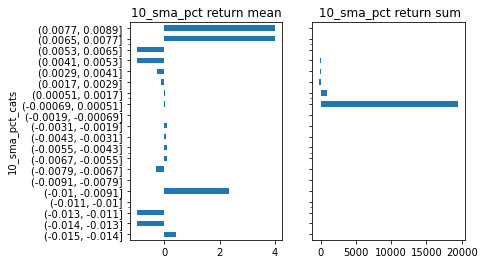

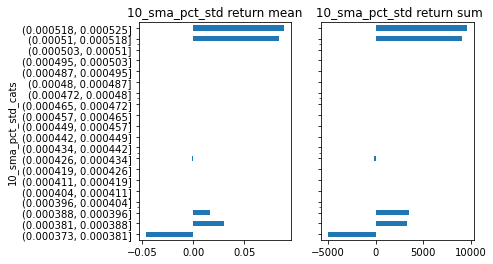

In [87]:
col1 = '10_sma_pct'
col2 = '10_sma_pct_std'
for col in [col1, col2]:
    col_cats = f'{col}_cats'
    all_data[col_cats] = pd.cut(all_data[col], bins=20, precision=0)
    group_data = all_data[[col_cats, 'perc_target_stop']].groupby(col_cats)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    group_data.mean()['perc_target_stop'].plot.barh(title=f'{col} return mean', ax=ax[0])
    group_data.sum()['perc_target_stop'].plot.barh(title=f' {col} return sum', ax=ax[1])
    plt.show()

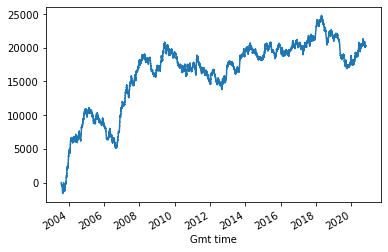

In [88]:
all_data['perc_target_stop'].cumsum().plot()

# trades 130342


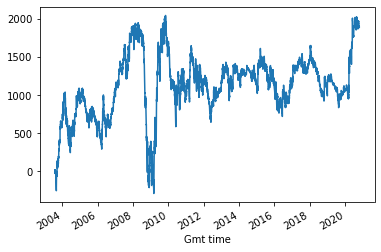

In [89]:
filter_rows = (
    (all_data[col1] > 0.0005) 
    | (all_data[col1] < -0.0005)
)
filter_all_data = all_data[filter_rows]

# filter_rows = (
#     (all_data[col2] < 0.3) 
#    # | (all_data[col] < -0.0038)
# )  
# filter_all_data = all_data[filter_rows]
   
    
# group_data = filter_all_data[[col_cats, 'perc_target_stop']].groupby(col_cats)
# fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
# group_data.mean()['perc_target_stop'].plot.barh(title='return mean', ax=ax[0])
# group_data.sum()['perc_target_stop'].plot.barh(title='return sum', ax=ax[1])
# plt.show()
     
print('# trades', len(filter_all_data))
filter_all_data['perc_target_stop'].cumsum().plot()

In [90]:
# data_path = f'{os.path.dirname(os.getcwd())}/data'
# num_cols = [str(c) for c in range(var.window * len(var.cols))]
# cols = num_cols + ['target', 'perc_target_stop']
# data = data[cols]
# data.to_csv(f'{data_path}/fx_dnn_data_1D_binary_stop_target_asym.csv')

In [91]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def calc_r2_equity(returns):
    '''
    A performance metric (made up by me) that falls between 0-1 generally.
    It is the r2 of the equity curve and a linear fitted line, to the power of 10, 
    which penalizes lower scores more heavily.
    This is a great metric to checking a consistant linearly increasing equity curve;
    however, it penalizes inconsistancy a little too much, so should be used alongside 
    the sharpe ratio, preferably sharpe_ratio * r2_trend to give us an adjusted sharpe
    '''
    idx = np.arange(len(returns))
    curve = returns.cumsum().values

    linreg = LinearRegression()
    linreg.fit(idx.reshape(-1,1), curve)
    idx_lin = linreg.predict(idx.reshape(-1,1))
    slope_int = (linreg.coef_ / abs(linreg.coef_))[0]
    
    r2_equity = (r2_score(curve, idx_lin) ** 2) * slope_int
    return r2_equity


def calc_dd_time_metric(returns):
    '''
    A performance metric (made up by me) that falls between 0-1.
    We calculate the maxuimum time in a draw down in days and then divide it by 100000.
    We then square it to penalize larger drawdowns more.
    '''
    equity = returns.cumsum().copy()
    equity_dd = equity - equity.cummax()
    time_dd = pd.Series((equity_dd[equity_dd == 0].index).append(equity.index[-1:]))
    max_dd_time = min(0.99, time_dd.diff().max() / timedelta(days=100000))
    print('dd_time', time_dd.diff().max())
    dd_time_metric = (1 - max_dd_time) ** 2
    return dd_time_metric
    
    
def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def adjusted_sharpe(returns, time_frame='1D'):
    r2_equity = calc_r2_equity(returns)
    sharpe = calc_sharpe(returns, time_frame=time_frame)
    print('sharpe', sharpe, 'r2_fit', r2_equity)
    return sharpe * r2_equity

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 96551
# trades gapped stop: 711 | # trades gapped target: 4279
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 93836
# trades gapped stop: 717 | # trades gapped target: 4694
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94796
# trades gapped stop: 650 | # trades gapped target: 4234
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 95145
# trades gapped stop: 819 | # trades gapped target: 3922
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 95398
# trades gapped stop: 840 | # trades gapped target: 4948
before filter 107888 after filter 5043
5 USDCAD_1

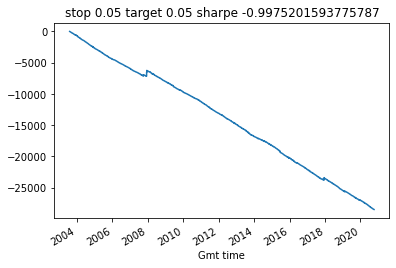

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 96383
# trades gapped stop: 730 | # trades gapped target: 3958
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 93546
# trades gapped stop: 731 | # trades gapped target: 4216
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94692
# trades gapped stop: 653 | # trades gapped target: 4017
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 95069
# trades gapped stop: 823 | # trades gapped target: 3809
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 95271
# trades gapped stop: 842 | # trades gapped target: 4634
before filter 107888 after filter 5043
5 USDCAD_1

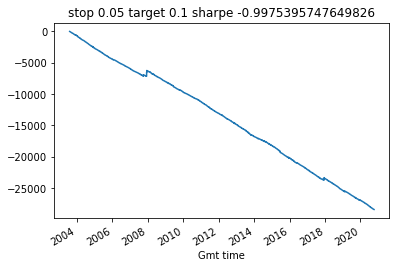

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 95692
# trades gapped stop: 770 | # trades gapped target: 2884
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92855
# trades gapped stop: 753 | # trades gapped target: 3251
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94064
# trades gapped stop: 673 | # trades gapped target: 3104
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94461
# trades gapped stop: 858 | # trades gapped target: 2965
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94680
# trades gapped stop: 854 | # trades gapped target: 3670
before filter 107888 after filter 5043
5 USDCAD_1

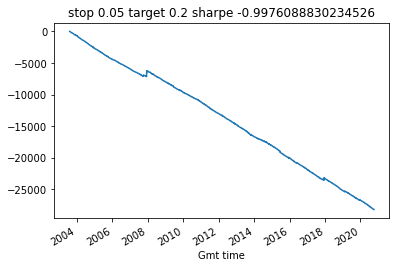

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94996
# trades gapped stop: 824 | # trades gapped target: 2289
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92141
# trades gapped stop: 776 | # trades gapped target: 2713
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 93440
# trades gapped stop: 694 | # trades gapped target: 2522
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 93958
# trades gapped stop: 884 | # trades gapped target: 2464
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 94069
# trades gapped stop: 871 | # trades gapped target: 3055
before filter 107888 after filter 5043
5 USDCAD_1

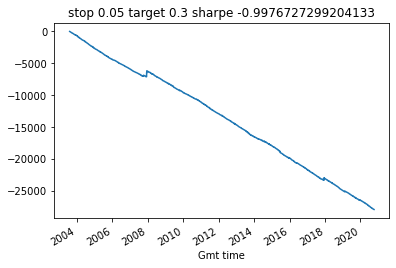

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 93794
# trades gapped stop: 905 | # trades gapped target: 1751
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 90652
# trades gapped stop: 823 | # trades gapped target: 1961
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92135
# trades gapped stop: 757 | # trades gapped target: 1818
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92717
# trades gapped stop: 964 | # trades gapped target: 1872
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92956
# trades gapped stop: 908 | # trades gapped target: 2307
before filter 107888 after filter 5043
5 USDCAD_1

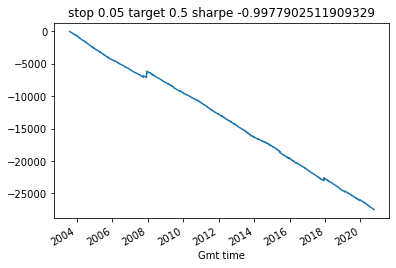

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 92556
# trades gapped stop: 1004 | # trades gapped target: 1486
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 89209
# trades gapped stop: 879 | # trades gapped target: 1536
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 90735
# trades gapped stop: 811 | # trades gapped target: 1426
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 91517
# trades gapped stop: 1052 | # trades gapped target: 1527
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 91855
# trades gapped stop: 937 | # trades gapped target: 2004
before filter 107888 after filter 5043
5 USDCAD

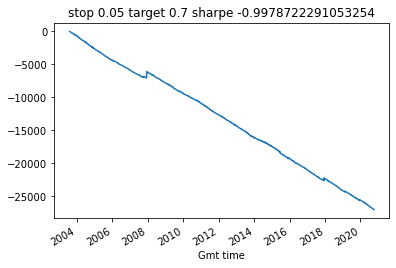

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 90499
# trades gapped stop: 1165 | # trades gapped target: 1235
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 86942
# trades gapped stop: 946 | # trades gapped target: 1133
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 88653
# trades gapped stop: 917 | # trades gapped target: 1090
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 89662
# trades gapped stop: 1180 | # trades gapped target: 1198
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 90220
# trades gapped stop: 987 | # trades gapped target: 1696
before filter 107888 after filter 5043
5 USDCAD

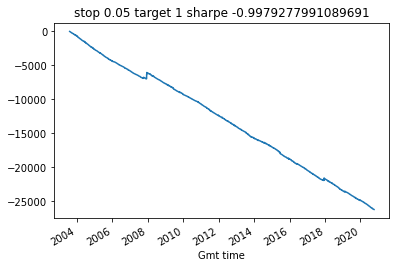

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 83144
# trades gapped stop: 1764 | # trades gapped target: 760
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 79278
# trades gapped stop: 1249 | # trades gapped target: 571
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 81207
# trades gapped stop: 1297 | # trades gapped target: 638
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 82929
# trades gapped stop: 1682 | # trades gapped target: 753
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 84539
# trades gapped stop: 1340 | # trades gapped target: 1204
before filter 107888 after filter 5043
5 USDCAD_

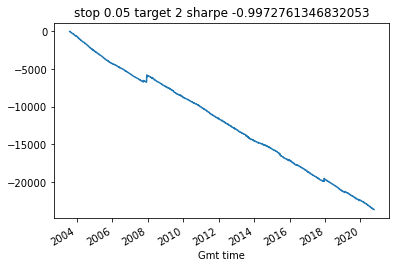

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 75580
# trades gapped stop: 2413 | # trades gapped target: 534
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 71807
# trades gapped stop: 1567 | # trades gapped target: 410
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 73480
# trades gapped stop: 1664 | # trades gapped target: 430
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 75911
# trades gapped stop: 2251 | # trades gapped target: 580
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 78692
# trades gapped stop: 1740 | # trades gapped target: 1011
before filter 107888 after filter 5043
5 USDCAD_

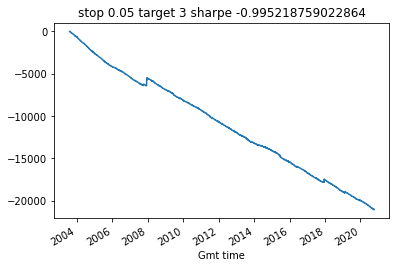

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 68094
# trades gapped stop: 3082 | # trades gapped target: 429
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 64289
# trades gapped stop: 1896 | # trades gapped target: 348
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 66252
# trades gapped stop: 2025 | # trades gapped target: 357
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 69157
# trades gapped stop: 2832 | # trades gapped target: 464
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 72437
# trades gapped stop: 2349 | # trades gapped target: 852
before filter 107888 after filter 5043
5 USDCAD_1

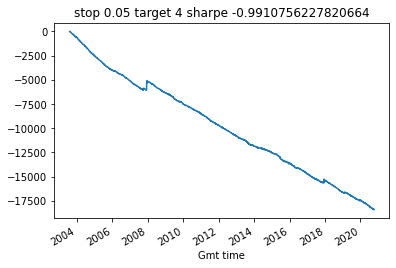

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 60732
# trades gapped stop: 3733 | # trades gapped target: 380
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57257
# trades gapped stop: 2139 | # trades gapped target: 310
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59331
# trades gapped stop: 2386 | # trades gapped target: 293
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 62554
# trades gapped stop: 3392 | # trades gapped target: 363
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 65908
# trades gapped stop: 2977 | # trades gapped target: 799
before filter 107888 after filter 5043
5 USDCAD_1

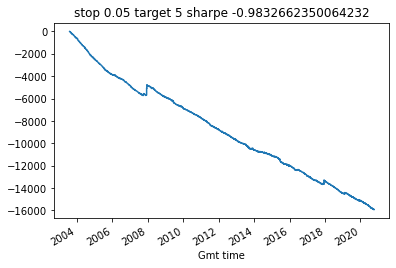

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 47839
# trades gapped stop: 4831 | # trades gapped target: 322
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 45339
# trades gapped stop: 2563 | # trades gapped target: 250
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 46901
# trades gapped stop: 2964 | # trades gapped target: 246
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 50047
# trades gapped stop: 4474 | # trades gapped target: 299
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 52920
# trades gapped stop: 4241 | # trades gapped target: 751
before filter 107888 after filter 5043
5 USDCAD_1

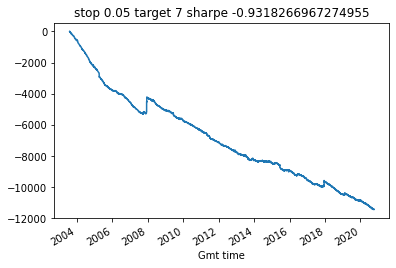

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 33146
# trades gapped stop: 6190 | # trades gapped target: 262
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 32026
# trades gapped stop: 3075 | # trades gapped target: 218
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 32345
# trades gapped stop: 3638 | # trades gapped target: 202
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 34605
# trades gapped stop: 5698 | # trades gapped target: 210
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 36198
# trades gapped stop: 5942 | # trades gapped target: 697
before filter 107888 after filter 5043
5 USDCAD_1

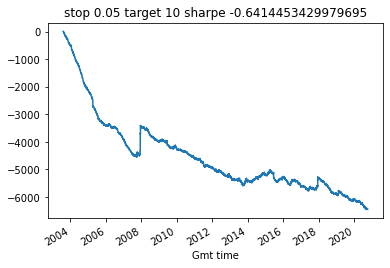

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18149
# trades gapped stop: 7482 | # trades gapped target: 183
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18142
# trades gapped stop: 3566 | # trades gapped target: 146
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17256
# trades gapped stop: 4397 | # trades gapped target: 122
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18149
# trades gapped stop: 6960 | # trades gapped target: 161
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18444
# trades gapped stop: 7574 | # trades gapped target: 603
before filter 107888 after filter 5043
5 USDCAD_1

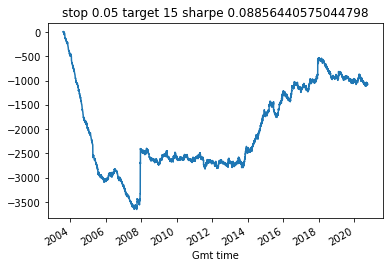

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 89315
# trades gapped stop: 493 | # trades gapped target: 6444
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 85654
# trades gapped stop: 481 | # trades gapped target: 6446
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 87611
# trades gapped stop: 395 | # trades gapped target: 6138
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 88716
# trades gapped stop: 560 | # trades gapped target: 5647
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 88472
# trades gapped stop: 656 | # trades gapped target: 7040
before filter 107888 after filter 5043
5 USDCAD_1

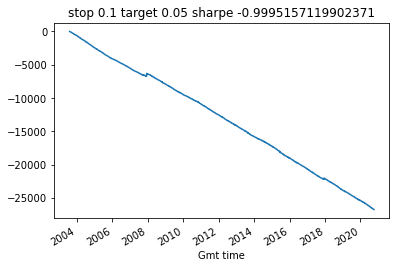

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 88626
# trades gapped stop: 505 | # trades gapped target: 4649
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 84963
# trades gapped stop: 489 | # trades gapped target: 4889
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 86983
# trades gapped stop: 408 | # trades gapped target: 4653
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 88108
# trades gapped stop: 576 | # trades gapped target: 4322
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 87885
# trades gapped stop: 666 | # trades gapped target: 5461
before filter 107888 after filter 5043
5 USDCAD_1

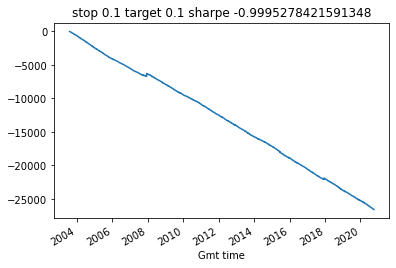

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 87356
# trades gapped stop: 551 | # trades gapped target: 3130
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 83429
# trades gapped stop: 508 | # trades gapped target: 3221
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 85715
# trades gapped stop: 431 | # trades gapped target: 3089
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 87013
# trades gapped stop: 603 | # trades gapped target: 3036
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 86707
# trades gapped stop: 693 | # trades gapped target: 3711
before filter 107888 after filter 5043
5 USDCAD_1

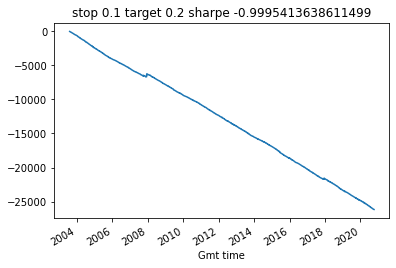

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 86072
# trades gapped stop: 579 | # trades gapped target: 2473
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 82071
# trades gapped stop: 518 | # trades gapped target: 2407
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 84384
# trades gapped stop: 447 | # trades gapped target: 2249
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 85773
# trades gapped stop: 647 | # trades gapped target: 2312
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 85626
# trades gapped stop: 718 | # trades gapped target: 2959
before filter 107888 after filter 5043
5 USDCAD_1

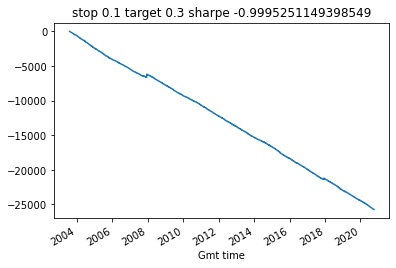

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 83469
# trades gapped stop: 652 | # trades gapped target: 1770
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 79070
# trades gapped stop: 541 | # trades gapped target: 1487
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 81583
# trades gapped stop: 502 | # trades gapped target: 1493
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 83311
# trades gapped stop: 726 | # trades gapped target: 1596
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 83467
# trades gapped stop: 745 | # trades gapped target: 2272
before filter 107888 after filter 5043
5 USDCAD_1

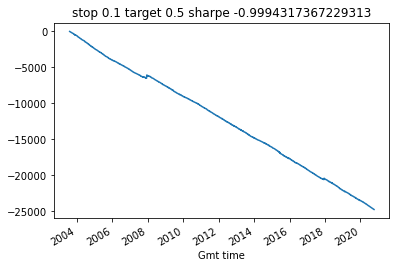

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 80591
# trades gapped stop: 736 | # trades gapped target: 1362
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 76036
# trades gapped stop: 583 | # trades gapped target: 1015
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 78727
# trades gapped stop: 553 | # trades gapped target: 1133
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 80640
# trades gapped stop: 801 | # trades gapped target: 1247
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 81280
# trades gapped stop: 795 | # trades gapped target: 1941
before filter 107888 after filter 5043
5 USDCAD_1

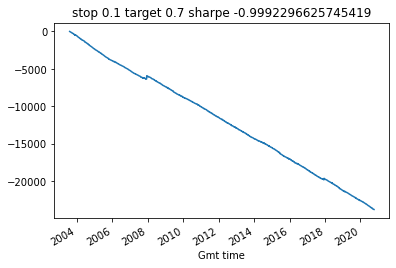

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 76193
# trades gapped stop: 843 | # trades gapped target: 959
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 71494
# trades gapped stop: 640 | # trades gapped target: 668
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 74188
# trades gapped stop: 630 | # trades gapped target: 795
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 76646
# trades gapped stop: 951 | # trades gapped target: 939
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 77815
# trades gapped stop: 887 | # trades gapped target: 1451
before filter 107888 after filter 5043
5 USDCAD_1h_20

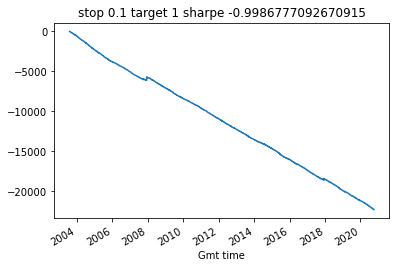

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 61528
# trades gapped stop: 1317 | # trades gapped target: 474
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57118
# trades gapped stop: 879 | # trades gapped target: 370
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59504
# trades gapped stop: 913 | # trades gapped target: 385
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 62995
# trades gapped stop: 1428 | # trades gapped target: 525
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 65859
# trades gapped stop: 1385 | # trades gapped target: 934
before filter 107888 after filter 5043
5 USDCAD_1h_

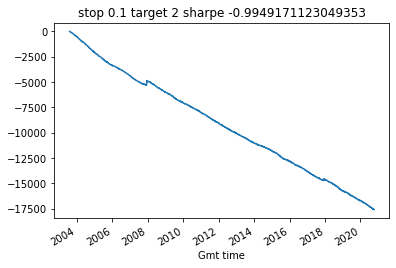

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 48102
# trades gapped stop: 1756 | # trades gapped target: 377
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 44780
# trades gapped stop: 1031 | # trades gapped target: 295
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 46537
# trades gapped stop: 1167 | # trades gapped target: 274
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 50245
# trades gapped stop: 1987 | # trades gapped target: 341
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 53112
# trades gapped stop: 2007 | # trades gapped target: 811
before filter 107888 after filter 5043
5 USDCAD_1

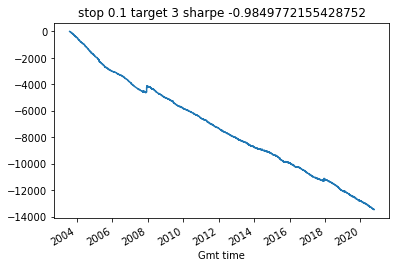

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 37429
# trades gapped stop: 2156 | # trades gapped target: 330
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 35049
# trades gapped stop: 1175 | # trades gapped target: 252
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 35992
# trades gapped stop: 1343 | # trades gapped target: 246
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 39107
# trades gapped stop: 2427 | # trades gapped target: 286
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 41363
# trades gapped stop: 2554 | # trades gapped target: 759
before filter 107888 after filter 5043
5 USDCAD_1

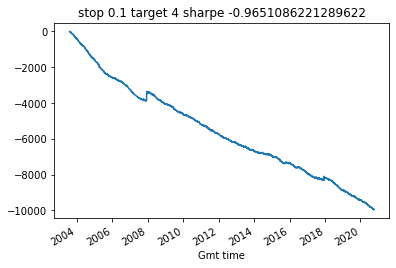

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 29007
# trades gapped stop: 2487 | # trades gapped target: 291
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 27716
# trades gapped stop: 1274 | # trades gapped target: 232
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 27725
# trades gapped stop: 1503 | # trades gapped target: 217
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 29993
# trades gapped stop: 2766 | # trades gapped target: 220
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 31376
# trades gapped stop: 3087 | # trades gapped target: 726
before filter 107888 after filter 5043
5 USDCAD_1

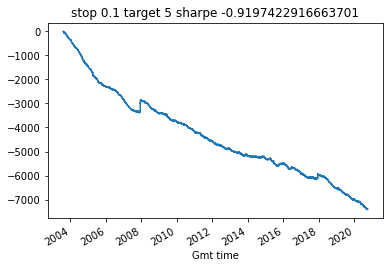

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17563
# trades gapped stop: 2935 | # trades gapped target: 226
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17400
# trades gapped stop: 1410 | # trades gapped target: 178
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16460
# trades gapped stop: 1766 | # trades gapped target: 156
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17545
# trades gapped stop: 3231 | # trades gapped target: 169
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17902
# trades gapped stop: 3683 | # trades gapped target: 642
before filter 107888 after filter 5043
5 USDCAD_1

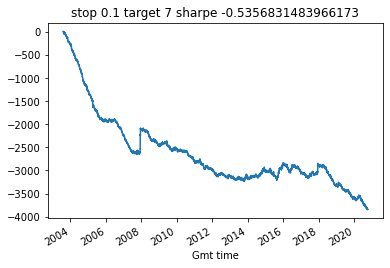

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 8889
# trades gapped stop: 3269 | # trades gapped target: 150
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 9112
# trades gapped stop: 1572 | # trades gapped target: 125
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 7927
# trades gapped stop: 1936 | # trades gapped target: 108
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8071
# trades gapped stop: 3644 | # trades gapped target: 124
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8105
# trades gapped stop: 4114 | # trades gapped target: 549
before filter 107888 after filter 5043
5 USDCAD_1h_200

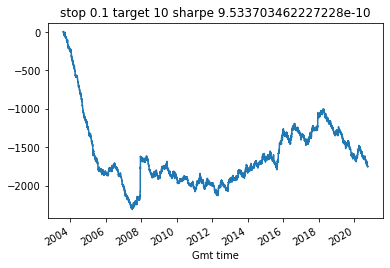

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3281
# trades gapped stop: 3426 | # trades gapped target: 71
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 3429
# trades gapped stop: 1672 | # trades gapped target: 61
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 2802
# trades gapped stop: 2067 | # trades gapped target: 65
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2535
# trades gapped stop: 3812 | # trades gapped target: 80
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2589
# trades gapped stop: 4281 | # trades gapped target: 408
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

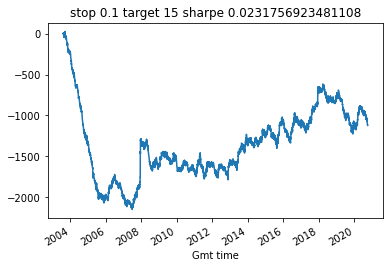

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 72834
# trades gapped stop: 312 | # trades gapped target: 8490
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 69274
# trades gapped stop: 343 | # trades gapped target: 7949
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 72485
# trades gapped stop: 272 | # trades gapped target: 7898
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 73986
# trades gapped stop: 378 | # trades gapped target: 7442
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 73798
# trades gapped stop: 561 | # trades gapped target: 9102
before filter 107888 after filter 5043
5 USDCAD_1

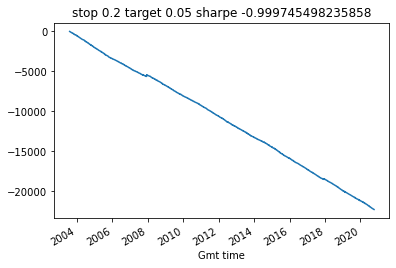

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 71577
# trades gapped stop: 326 | # trades gapped target: 5598
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 67767
# trades gapped stop: 347 | # trades gapped target: 5041
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 71225
# trades gapped stop: 275 | # trades gapped target: 5203
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 72898
# trades gapped stop: 388 | # trades gapped target: 5050
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 72626
# trades gapped stop: 577 | # trades gapped target: 6134
before filter 107888 after filter 5043
5 USDCAD_1

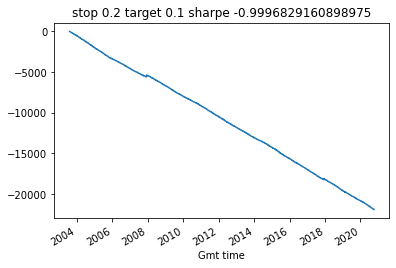

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 69114
# trades gapped stop: 349 | # trades gapped target: 3510
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 64983
# trades gapped stop: 352 | # trades gapped target: 2793
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 68538
# trades gapped stop: 289 | # trades gapped target: 2927
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 70516
# trades gapped stop: 413 | # trades gapped target: 3002
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 70505
# trades gapped stop: 590 | # trades gapped target: 4130
before filter 107888 after filter 5043
5 USDCAD_1

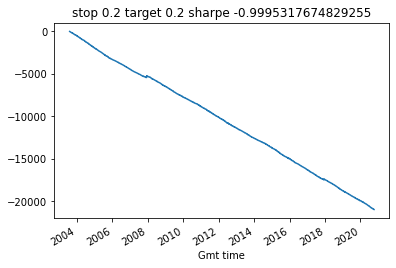

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 66426
# trades gapped stop: 369 | # trades gapped target: 2464
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 62163
# trades gapped stop: 366 | # trades gapped target: 1763
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 65743
# trades gapped stop: 305 | # trades gapped target: 2008
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 67915
# trades gapped stop: 424 | # trades gapped target: 2173
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 68332
# trades gapped stop: 606 | # trades gapped target: 3231
before filter 107888 after filter 5043
5 USDCAD_1

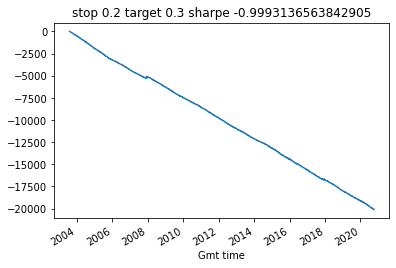

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 60890
# trades gapped stop: 403 | # trades gapped target: 1346
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 56441
# trades gapped stop: 387 | # trades gapped target: 867
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59947
# trades gapped stop: 337 | # trades gapped target: 1113
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 62755
# trades gapped stop: 486 | # trades gapped target: 1351
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 63918
# trades gapped stop: 643 | # trades gapped target: 2095
before filter 107888 after filter 5043
5 USDCAD_1h

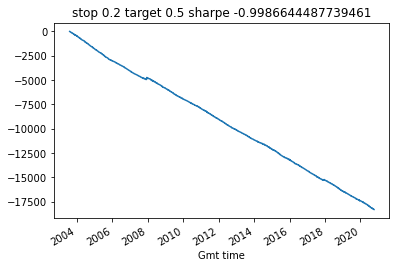

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 55363
# trades gapped stop: 448 | # trades gapped target: 835
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 51347
# trades gapped stop: 429 | # trades gapped target: 555
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 54151
# trades gapped stop: 364 | # trades gapped target: 679
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57652
# trades gapped stop: 542 | # trades gapped target: 1000
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59493
# trades gapped stop: 715 | # trades gapped target: 1580
before filter 107888 after filter 5043
5 USDCAD_1h_2

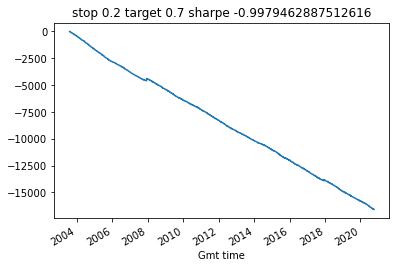

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 47578
# trades gapped stop: 515 | # trades gapped target: 546
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 43992
# trades gapped stop: 481 | # trades gapped target: 405
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 46224
# trades gapped stop: 403 | # trades gapped target: 431
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 50143
# trades gapped stop: 611 | # trades gapped target: 685
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 52605
# trades gapped stop: 817 | # trades gapped target: 1094
before filter 107888 after filter 5043
5 USDCAD_1h_20

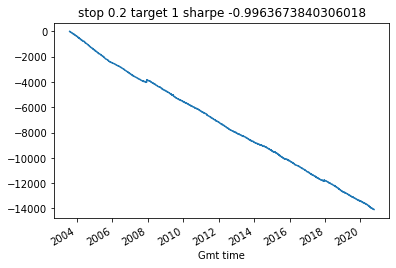

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 27655
# trades gapped stop: 758 | # trades gapped target: 384
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 26328
# trades gapped stop: 604 | # trades gapped target: 274
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 26322
# trades gapped stop: 538 | # trades gapped target: 278
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 29113
# trades gapped stop: 903 | # trades gapped target: 363
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 30965
# trades gapped stop: 1092 | # trades gapped target: 820
before filter 107888 after filter 5043
5 USDCAD_1h_20

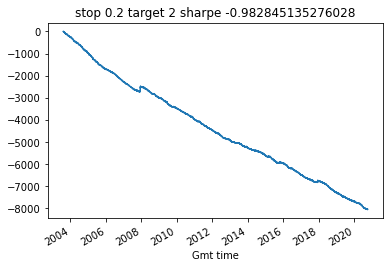

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16313
# trades gapped stop: 955 | # trades gapped target: 312
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16194
# trades gapped stop: 678 | # trades gapped target: 216
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 15198
# trades gapped stop: 640 | # trades gapped target: 223
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16469
# trades gapped stop: 1092 | # trades gapped target: 274
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16822
# trades gapped stop: 1331 | # trades gapped target: 724
before filter 107888 after filter 5043
5 USDCAD_1h_2

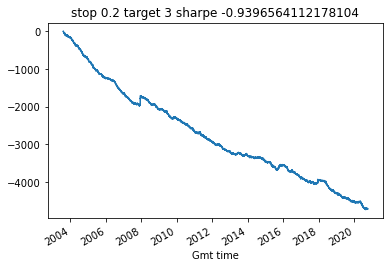

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 10051
# trades gapped stop: 1065 | # trades gapped target: 279
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 10285
# trades gapped stop: 746 | # trades gapped target: 188
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 8874
# trades gapped stop: 722 | # trades gapped target: 171
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 9556
# trades gapped stop: 1215 | # trades gapped target: 235
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 9530
# trades gapped stop: 1472 | # trades gapped target: 666
before filter 107888 after filter 5043
5 USDCAD_1h_200

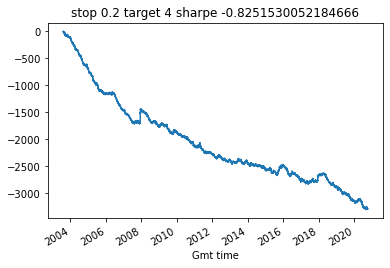

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 6448
# trades gapped stop: 1142 | # trades gapped target: 202
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 6754
# trades gapped stop: 806 | # trades gapped target: 151
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5635
# trades gapped stop: 777 | # trades gapped target: 150
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 5730
# trades gapped stop: 1290 | # trades gapped target: 187
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5727
# trades gapped stop: 1563 | # trades gapped target: 600
before filter 107888 after filter 5043
5 USDCAD_1h_2003-

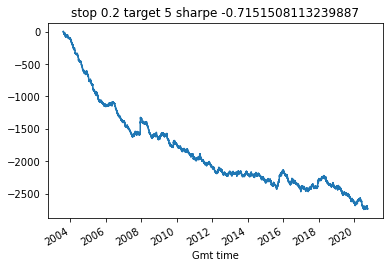

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2963
# trades gapped stop: 1205 | # trades gapped target: 111
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3081
# trades gapped stop: 859 | # trades gapped target: 95
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2529
# trades gapped stop: 867 | # trades gapped target: 104
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2298
# trades gapped stop: 1331 | # trades gapped target: 124
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2395
# trades gapped stop: 1640 | # trades gapped target: 477
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2

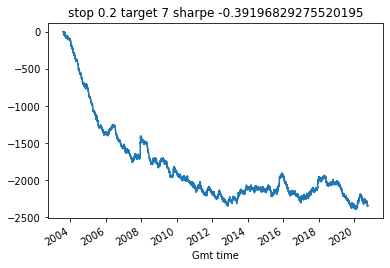

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1229
# trades gapped stop: 1220 | # trades gapped target: 65
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 1174
# trades gapped stop: 873 | # trades gapped target: 64
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 1015
# trades gapped stop: 882 | # trades gapped target: 67
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 825
# trades gapped stop: 1357 | # trades gapped target: 82
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 909
# trades gapped stop: 1638 | # trades gapped target: 345
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

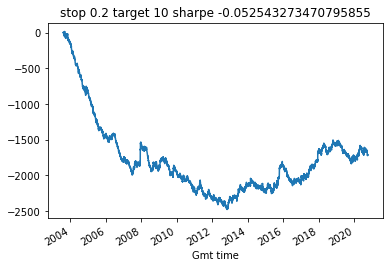

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 444
# trades gapped stop: 1209 | # trades gapped target: 37
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 345
# trades gapped stop: 870 | # trades gapped target: 29
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 363
# trades gapped stop: 841 | # trades gapped target: 44
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 281
# trades gapped stop: 1350 | # trades gapped target: 40
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 327
# trades gapped stop: 1618 | # trades gapped target: 202
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


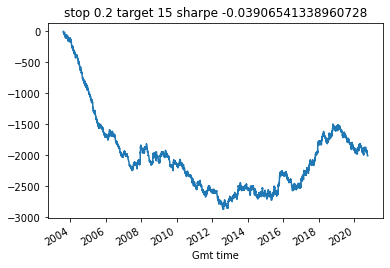

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57317
# trades gapped stop: 272 | # trades gapped target: 9254
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 54904
# trades gapped stop: 295 | # trades gapped target: 8425
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 58080
# trades gapped stop: 226 | # trades gapped target: 8640
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59755
# trades gapped stop: 320 | # trades gapped target: 8372
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 59229
# trades gapped stop: 538 | # trades gapped target: 10355
before filter 107888 after filter 5043
5 USDCAD_

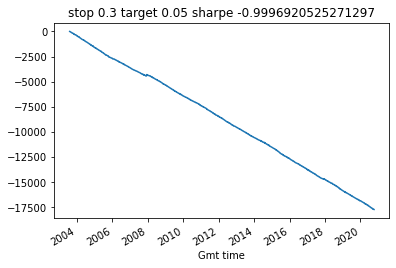

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 55637
# trades gapped stop: 285 | # trades gapped target: 5940
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 52953
# trades gapped stop: 300 | # trades gapped target: 4772
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 56189
# trades gapped stop: 231 | # trades gapped target: 5090
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57970
# trades gapped stop: 328 | # trades gapped target: 5215
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 57640
# trades gapped stop: 547 | # trades gapped target: 6752
before filter 107888 after filter 5043
5 USDCAD_1

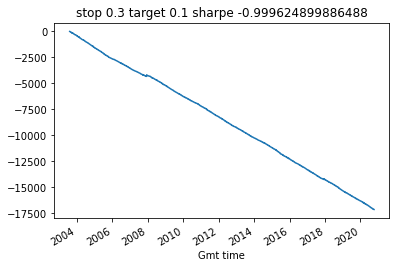

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 52082
# trades gapped stop: 312 | # trades gapped target: 3282
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 49125
# trades gapped stop: 313 | # trades gapped target: 2194
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 52247
# trades gapped stop: 245 | # trades gapped target: 2623
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 54354
# trades gapped stop: 340 | # trades gapped target: 2927
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 54538
# trades gapped stop: 558 | # trades gapped target: 4390
before filter 107888 after filter 5043
5 USDCAD_1

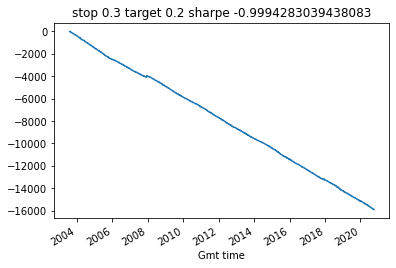

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 48400
# trades gapped stop: 331 | # trades gapped target: 1990
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 45279
# trades gapped stop: 325 | # trades gapped target: 1187
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 48238
# trades gapped stop: 256 | # trades gapped target: 1599
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 50715
# trades gapped stop: 354 | # trades gapped target: 1944
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 51498
# trades gapped stop: 582 | # trades gapped target: 3131
before filter 107888 after filter 5043
5 USDCAD_1

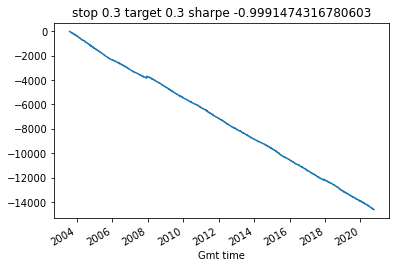

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 41269
# trades gapped stop: 361 | # trades gapped target: 888
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 38784
# trades gapped stop: 376 | # trades gapped target: 580
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 40376
# trades gapped stop: 292 | # trades gapped target: 708
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 43709
# trades gapped stop: 393 | # trades gapped target: 1102
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 45418
# trades gapped stop: 645 | # trades gapped target: 1727
before filter 107888 after filter 5043
5 USDCAD_1h_2

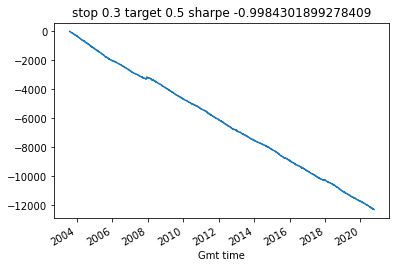

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 34805
# trades gapped stop: 405 | # trades gapped target: 574
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 32948
# trades gapped stop: 422 | # trades gapped target: 426
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 33767
# trades gapped stop: 320 | # trades gapped target: 444
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 37044
# trades gapped stop: 435 | # trades gapped target: 735
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 39297
# trades gapped stop: 711 | # trades gapped target: 1161
before filter 107888 after filter 5043
5 USDCAD_1h_20

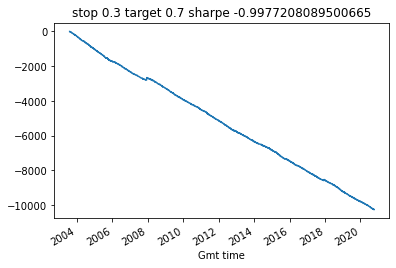

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 26854
# trades gapped stop: 456 | # trades gapped target: 452
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 26017
# trades gapped stop: 475 | # trades gapped target: 356
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 25633
# trades gapped stop: 388 | # trades gapped target: 333
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 28331
# trades gapped stop: 513 | # trades gapped target: 476
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 30493
# trades gapped stop: 790 | # trades gapped target: 942
before filter 107888 after filter 5043
5 USDCAD_1h_200

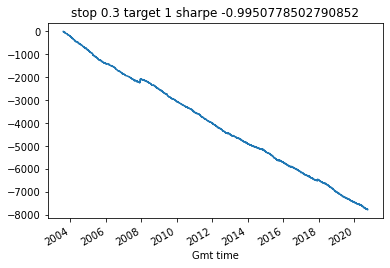

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 11931
# trades gapped stop: 687 | # trades gapped target: 351
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 12154
# trades gapped stop: 609 | # trades gapped target: 245
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 10942
# trades gapped stop: 532 | # trades gapped target: 251
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 11624
# trades gapped stop: 723 | # trades gapped target: 306
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 11679
# trades gapped stop: 1001 | # trades gapped target: 779
before filter 107888 after filter 5043
5 USDCAD_1h_20

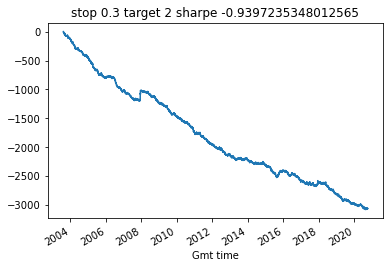

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 5999
# trades gapped stop: 797 | # trades gapped target: 286
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 6355
# trades gapped stop: 707 | # trades gapped target: 213
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5167
# trades gapped stop: 631 | # trades gapped target: 187
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 5191
# trades gapped stop: 872 | # trades gapped target: 260
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5325
# trades gapped stop: 1142 | # trades gapped target: 690
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

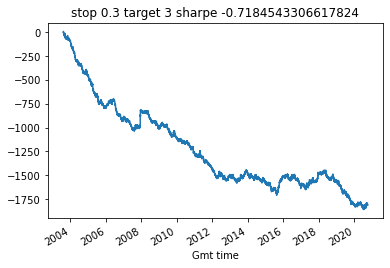

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 3347
# trades gapped stop: 873 | # trades gapped target: 197
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3579
# trades gapped stop: 760 | # trades gapped target: 153
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2825
# trades gapped stop: 690 | # trades gapped target: 142
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 2644
# trades gapped stop: 914 | # trades gapped target: 179
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2776
# trades gapped stop: 1235 | # trades gapped target: 582
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

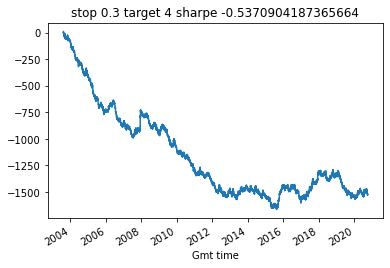

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2024
# trades gapped stop: 890 | # trades gapped target: 125
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2116
# trades gapped stop: 787 | # trades gapped target: 112
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 1719
# trades gapped stop: 749 | # trades gapped target: 122
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1457
# trades gapped stop: 925 | # trades gapped target: 145
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1592
# trades gapped stop: 1254 | # trades gapped target: 484
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

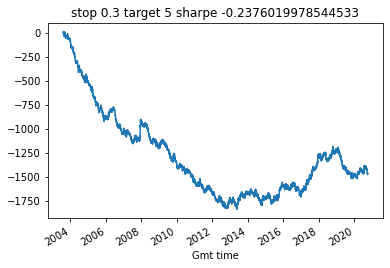

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 987
# trades gapped stop: 911 | # trades gapped target: 75
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 890
# trades gapped stop: 807 | # trades gapped target: 69
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 820
# trades gapped stop: 761 | # trades gapped target: 79
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 606
# trades gapped stop: 944 | # trades gapped target: 86
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 718
# trades gapped stop: 1258 | # trades gapped target: 350
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

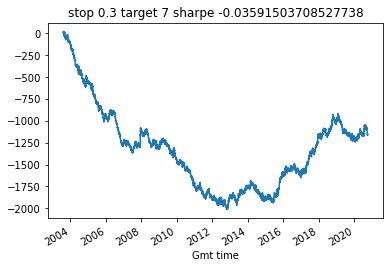

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 459
# trades gapped stop: 901 | # trades gapped target: 50
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 323
# trades gapped stop: 795 | # trades gapped target: 45
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 368
# trades gapped stop: 734 | # trades gapped target: 61
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 278
# trades gapped stop: 960 | # trades gapped target: 60
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 318
# trades gapped stop: 1251 | # trades gapped target: 237
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

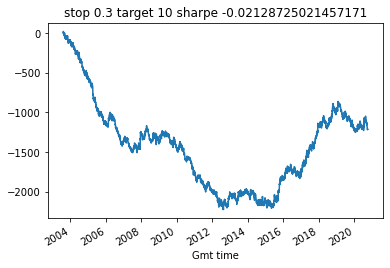

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 188
# trades gapped stop: 885 | # trades gapped target: 30
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 101
# trades gapped stop: 768 | # trades gapped target: 35
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 132
# trades gapped stop: 712 | # trades gapped target: 32
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 85
# trades gapped stop: 948 | # trades gapped target: 42
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 137
# trades gapped stop: 1219 | # trades gapped target: 148
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

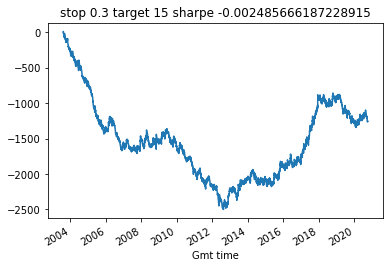

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 34946
# trades gapped stop: 218 | # trades gapped target: 9537
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 33804
# trades gapped stop: 216 | # trades gapped target: 7521
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 35439
# trades gapped stop: 178 | # trades gapped target: 8466
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 36109
# trades gapped stop: 246 | # trades gapped target: 8498
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 35740
# trades gapped stop: 479 | # trades gapped target: 10717
before filter 107888 after filter 5043
5 USDCAD_

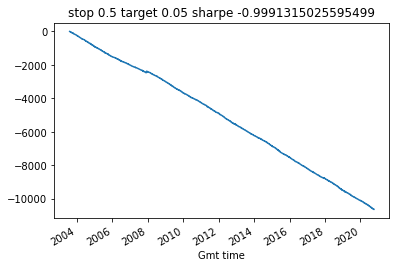

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 32721
# trades gapped stop: 233 | # trades gapped target: 5429
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 31512
# trades gapped stop: 223 | # trades gapped target: 3634
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 32752
# trades gapped stop: 189 | # trades gapped target: 4494
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 33667
# trades gapped stop: 257 | # trades gapped target: 4802
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 33634
# trades gapped stop: 490 | # trades gapped target: 6920
before filter 107888 after filter 5043
5 USDCAD_1

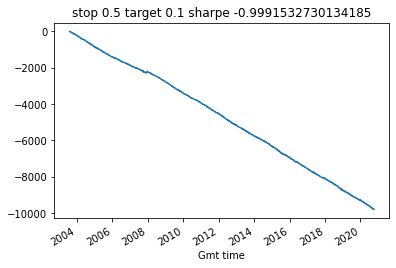

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 28269
# trades gapped stop: 258 | # trades gapped target: 2164
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 27236
# trades gapped stop: 251 | # trades gapped target: 1239
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 27757
# trades gapped stop: 213 | # trades gapped target: 1862
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 28932
# trades gapped stop: 274 | # trades gapped target: 2254
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 29678
# trades gapped stop: 521 | # trades gapped target: 3599
before filter 107888 after filter 5043
5 USDCAD_1

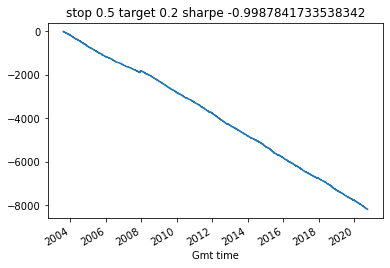

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 24240
# trades gapped stop: 286 | # trades gapped target: 1038
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 23789
# trades gapped stop: 302 | # trades gapped target: 657
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 23268
# trades gapped stop: 240 | # trades gapped target: 925
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 24789
# trades gapped stop: 298 | # trades gapped target: 1361
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 25997
# trades gapped stop: 568 | # trades gapped target: 2137
before filter 107888 after filter 5043
5 USDCAD_1h_

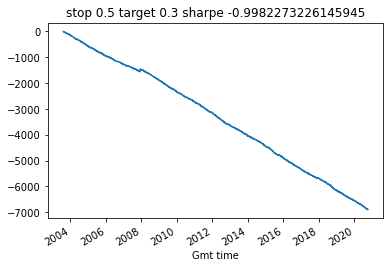

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17911
# trades gapped stop: 343 | # trades gapped target: 562
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17872
# trades gapped stop: 367 | # trades gapped target: 438
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 16699
# trades gapped stop: 316 | # trades gapped target: 476
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 17797
# trades gapped stop: 371 | # trades gapped target: 654
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 19242
# trades gapped stop: 654 | # trades gapped target: 1160
before filter 107888 after filter 5043
5 USDCAD_1h_20

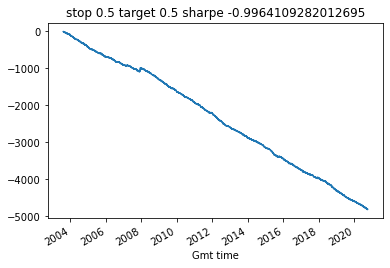

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 13417
# trades gapped stop: 405 | # trades gapped target: 493
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 13589
# trades gapped stop: 421 | # trades gapped target: 379
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 12258
# trades gapped stop: 376 | # trades gapped target: 424
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 12801
# trades gapped stop: 449 | # trades gapped target: 488
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 13711
# trades gapped stop: 722 | # trades gapped target: 982
before filter 107888 after filter 5043
5 USDCAD_1h_200

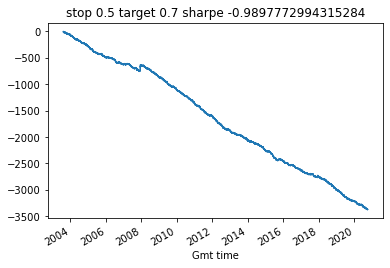

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8928
# trades gapped stop: 529 | # trades gapped target: 452
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 9349
# trades gapped stop: 507 | # trades gapped target: 353
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 7974
# trades gapped stop: 467 | # trades gapped target: 361
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8046
# trades gapped stop: 586 | # trades gapped target: 402
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 8317
# trades gapped stop: 856 | # trades gapped target: 936
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

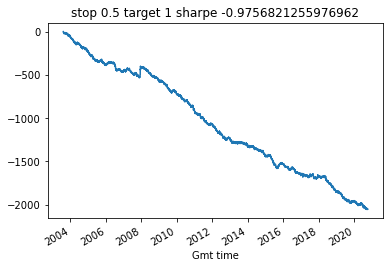

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 3126
# trades gapped stop: 729 | # trades gapped target: 306
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 3417
# trades gapped stop: 673 | # trades gapped target: 240
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2754
# trades gapped stop: 654 | # trades gapped target: 241
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2398
# trades gapped stop: 820 | # trades gapped target: 282
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2620
# trades gapped stop: 1109 | # trades gapped target: 762
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

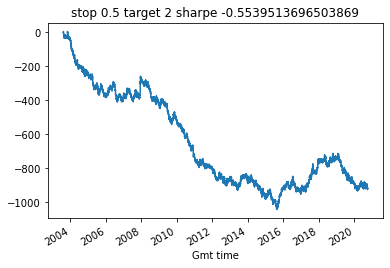

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1524
# trades gapped stop: 789 | # trades gapped target: 175
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1473
# trades gapped stop: 744 | # trades gapped target: 153
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1303
# trades gapped stop: 743 | # trades gapped target: 172
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1056
# trades gapped stop: 882 | # trades gapped target: 187
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1206
# trades gapped stop: 1185 | # trades gapped target: 567
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

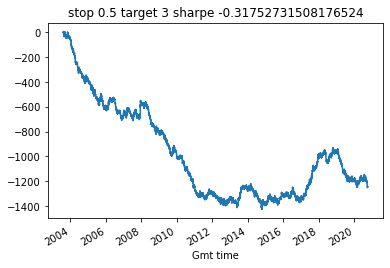

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 941
# trades gapped stop: 814 | # trades gapped target: 112
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 812
# trades gapped stop: 766 | # trades gapped target: 109
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 829
# trades gapped stop: 768 | # trades gapped target: 120
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 603
# trades gapped stop: 900 | # trades gapped target: 129
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 717
# trades gapped stop: 1214 | # trades gapped target: 435
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

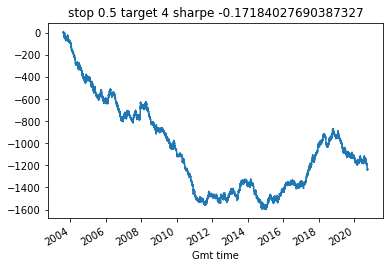

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 684
# trades gapped stop: 815 | # trades gapped target: 78
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 465
# trades gapped stop: 764 | # trades gapped target: 90
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 559
# trades gapped stop: 764 | # trades gapped target: 103
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 400
# trades gapped stop: 908 | # trades gapped target: 85
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 525
# trades gapped stop: 1230 | # trades gapped target: 327
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

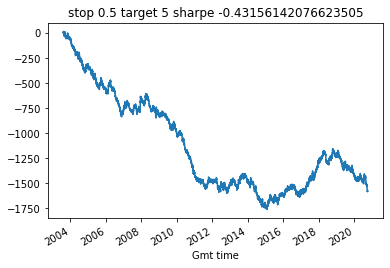

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 353
# trades gapped stop: 812 | # trades gapped target: 50
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 203
# trades gapped stop: 753 | # trades gapped target: 55
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 283
# trades gapped stop: 756 | # trades gapped target: 80
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 208
# trades gapped stop: 943 | # trades gapped target: 76
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 253
# trades gapped stop: 1226 | # trades gapped target: 220
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

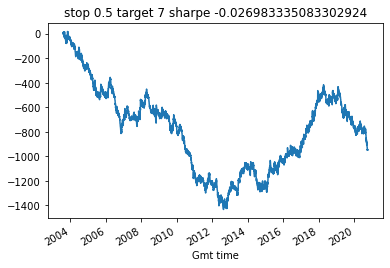

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 147
# trades gapped stop: 799 | # trades gapped target: 37
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 85
# trades gapped stop: 713 | # trades gapped target: 72
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 101
# trades gapped stop: 753 | # trades gapped target: 44
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 51
# trades gapped stop: 928 | # trades gapped target: 58
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 68
# trades gapped stop: 1196 | # trades gapped target: 155
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tra

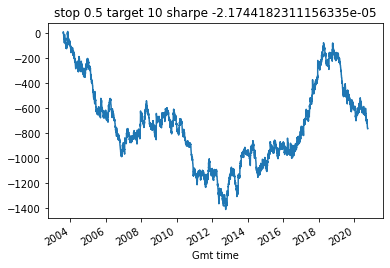

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 37
# trades gapped stop: 761 | # trades gapped target: 14
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 19
# trades gapped stop: 669 | # trades gapped target: 39
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 11
# trades gapped stop: 735 | # trades gapped target: 24
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 18
# trades gapped stop: 834 | # trades gapped target: 23
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 7
# trades gapped stop: 1104 | # trades gapped target: 96
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

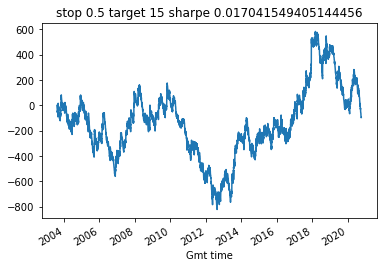

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 21139
# trades gapped stop: 189 | # trades gapped target: 8640
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 20974
# trades gapped stop: 163 | # trades gapped target: 6170
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 21005
# trades gapped stop: 136 | # trades gapped target: 7442
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 21167
# trades gapped stop: 207 | # trades gapped target: 7691
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 20908
# trades gapped stop: 396 | # trades gapped target: 10241
before filter 107888 after filter 5043
5 USDCAD_

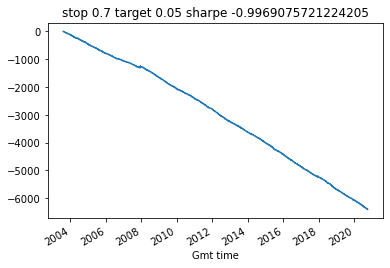

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 19002
# trades gapped stop: 215 | # trades gapped target: 4236
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18802
# trades gapped stop: 180 | # trades gapped target: 2531
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18595
# trades gapped stop: 146 | # trades gapped target: 3567
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18751
# trades gapped stop: 217 | # trades gapped target: 3947
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 18889
# trades gapped stop: 408 | # trades gapped target: 6202
before filter 107888 after filter 5043
5 USDCAD_1

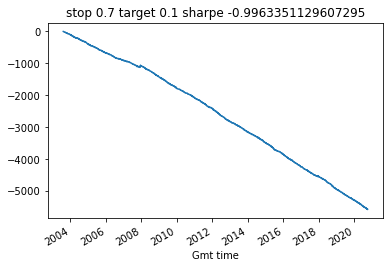

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 15203
# trades gapped stop: 273 | # trades gapped target: 1292
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 15273
# trades gapped stop: 246 | # trades gapped target: 812
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 14341
# trades gapped stop: 192 | # trades gapped target: 1186
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 14749
# trades gapped stop: 270 | # trades gapped target: 1673
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 15343
# trades gapped stop: 462 | # trades gapped target: 2597
before filter 107888 after filter 5043
5 USDCAD_1h

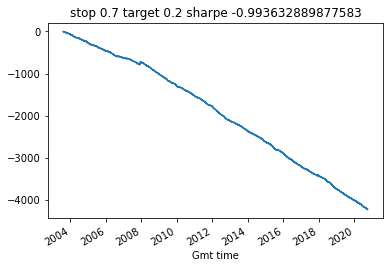

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 12293
# trades gapped stop: 325 | # trades gapped target: 718
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 12451
# trades gapped stop: 283 | # trades gapped target: 564
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 11324
# trades gapped stop: 227 | # trades gapped target: 623
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 11501
# trades gapped stop: 313 | # trades gapped target: 931
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 12390
# trades gapped stop: 537 | # trades gapped target: 1459
before filter 107888 after filter 5043
5 USDCAD_1h_20

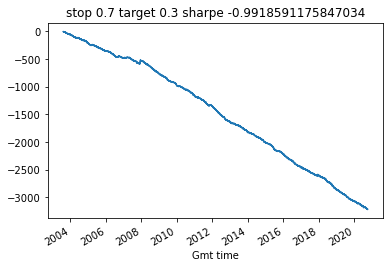

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 8119
# trades gapped stop: 416 | # trades gapped target: 545
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8453
# trades gapped stop: 366 | # trades gapped target: 463
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 7281
# trades gapped stop: 325 | # trades gapped target: 487
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 7255
# trades gapped stop: 439 | # trades gapped target: 558
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 7728
# trades gapped stop: 643 | # trades gapped target: 1043
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

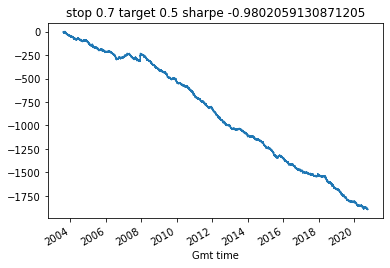

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5641
# trades gapped stop: 534 | # trades gapped target: 509
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5972
# trades gapped stop: 437 | # trades gapped target: 440
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 4956
# trades gapped stop: 407 | # trades gapped target: 421
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 4763
# trades gapped stop: 567 | # trades gapped target: 479
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 4990
# trades gapped stop: 761 | # trades gapped target: 1008
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

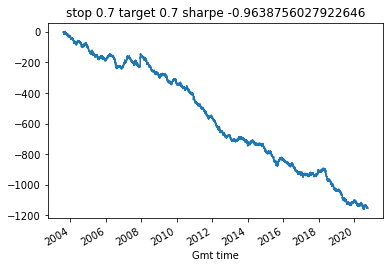

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 3603
# trades gapped stop: 621 | # trades gapped target: 456
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3700
# trades gapped stop: 532 | # trades gapped target: 357
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 3117
# trades gapped stop: 507 | # trades gapped target: 340
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2860
# trades gapped stop: 686 | # trades gapped target: 437
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3016
# trades gapped stop: 882 | # trades gapped target: 935
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

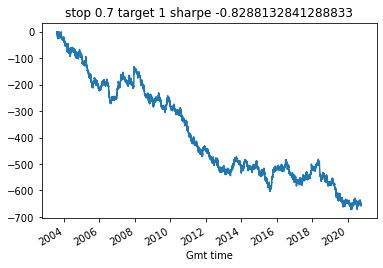

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1371
# trades gapped stop: 785 | # trades gapped target: 218
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 1282
# trades gapped stop: 697 | # trades gapped target: 210
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 1214
# trades gapped stop: 669 | # trades gapped target: 215
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 935
# trades gapped stop: 842 | # trades gapped target: 251
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1156
# trades gapped stop: 1094 | # trades gapped target: 663
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

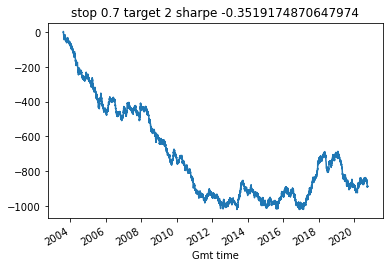

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 818
# trades gapped stop: 823 | # trades gapped target: 120
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 649
# trades gapped stop: 714 | # trades gapped target: 130
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 755
# trades gapped stop: 716 | # trades gapped target: 145
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 503
# trades gapped stop: 878 | # trades gapped target: 120
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 624
# trades gapped stop: 1136 | # trades gapped target: 462
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

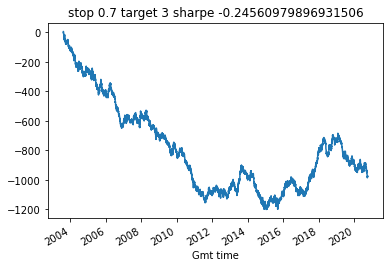

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 559
# trades gapped stop: 825 | # trades gapped target: 88
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 338
# trades gapped stop: 715 | # trades gapped target: 110
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 486
# trades gapped stop: 720 | # trades gapped target: 128
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 303
# trades gapped stop: 908 | # trades gapped target: 136
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 423
# trades gapped stop: 1165 | # trades gapped target: 349
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

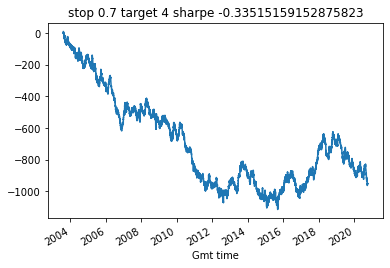

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 388
# trades gapped stop: 827 | # trades gapped target: 61
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 205
# trades gapped stop: 715 | # trades gapped target: 78
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 305
# trades gapped stop: 725 | # trades gapped target: 106
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 187
# trades gapped stop: 925 | # trades gapped target: 102
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 229
# trades gapped stop: 1176 | # trades gapped target: 269
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


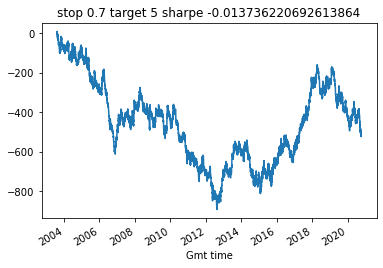

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 179
# trades gapped stop: 821 | # trades gapped target: 55
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 95
# trades gapped stop: 672 | # trades gapped target: 89
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 122
# trades gapped stop: 733 | # trades gapped target: 74
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 54
# trades gapped stop: 918 | # trades gapped target: 84
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 70
# trades gapped stop: 1169 | # trades gapped target: 184
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

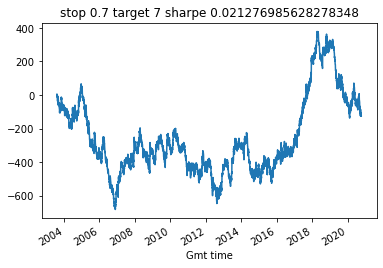

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 52
# trades gapped stop: 804 | # trades gapped target: 32
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 36
# trades gapped stop: 637 | # trades gapped target: 50
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 28
# trades gapped stop: 723 | # trades gapped target: 49
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 16
# trades hit both target and stop: 18
# trades gapped stop: 835 | # trades gapped target: 57
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 13
# trades hit both target and stop: 9
# trades gapped stop: 1091 | # trades gapped target: 131
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tra

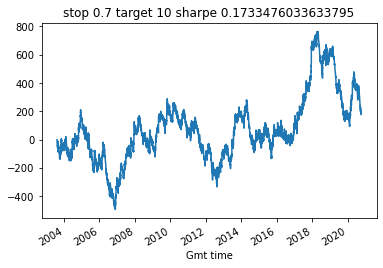

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 21
# trades hit both target and stop: 3
# trades gapped stop: 723 | # trades gapped target: 26
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 28
# trades hit both target and stop: 4
# trades gapped stop: 565 | # trades gapped target: 23
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 13
# trades hit both target and stop: 3
# trades gapped stop: 646 | # trades gapped target: 13
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 52
# trades hit both target and stop: 0
# trades gapped stop: 714 | # trades gapped target: 21
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 22
# trades hit both target and stop: 0
# trades gapped stop: 970 | # trades gapped target: 39
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

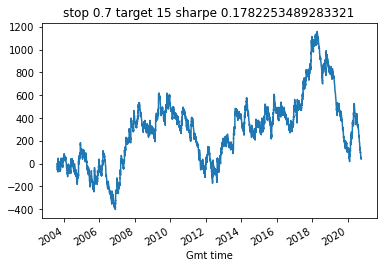

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 10234
# trades gapped stop: 150 | # trades gapped target: 6873
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 10582
# trades gapped stop: 125 | # trades gapped target: 4517
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 10156
# trades gapped stop: 117 | # trades gapped target: 5858
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 9421
# trades gapped stop: 164 | # trades gapped target: 6187
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 9556
# trades gapped stop: 339 | # trades gapped target: 8665
before filter 107888 after filter 5043
5 USDCAD_1h_

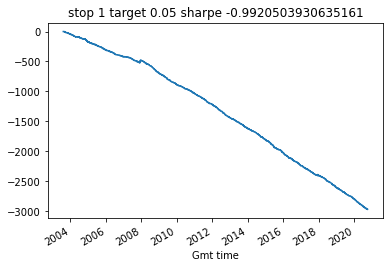

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8676
# trades gapped stop: 188 | # trades gapped target: 2624
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8954
# trades gapped stop: 161 | # trades gapped target: 1511
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8400
# trades gapped stop: 136 | # trades gapped target: 2338
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 7787
# trades gapped stop: 190 | # trades gapped target: 2790
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 8157
# trades gapped stop: 373 | # trades gapped target: 4284
before filter 107888 after filter 5043
5 USDCAD_1h_200

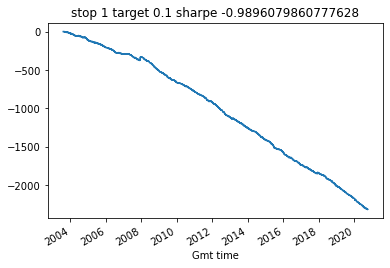

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 6389
# trades gapped stop: 255 | # trades gapped target: 772
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 6641
# trades gapped stop: 233 | # trades gapped target: 633
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 5932
# trades gapped stop: 201 | # trades gapped target: 749
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 5460
# trades gapped stop: 258 | # trades gapped target: 1073
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 6039
# trades gapped stop: 437 | # trades gapped target: 1596
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2

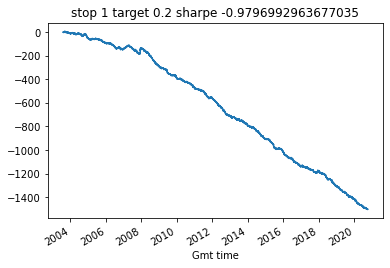

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 4816
# trades gapped stop: 306 | # trades gapped target: 612
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 5078
# trades gapped stop: 283 | # trades gapped target: 538
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 4384
# trades gapped stop: 252 | # trades gapped target: 564
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 3919
# trades gapped stop: 322 | # trades gapped target: 655
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 4415
# trades gapped stop: 514 | # trades gapped target: 1161
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

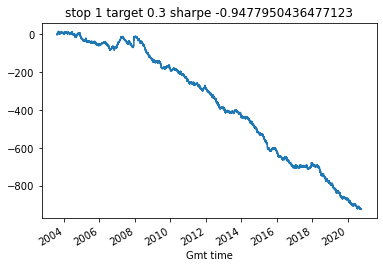

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3071
# trades gapped stop: 398 | # trades gapped target: 560
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 3216
# trades gapped stop: 392 | # trades gapped target: 490
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 2744
# trades gapped stop: 365 | # trades gapped target: 504
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2323
# trades gapped stop: 466 | # trades gapped target: 541
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2557
# trades gapped stop: 640 | # trades gapped target: 1059
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

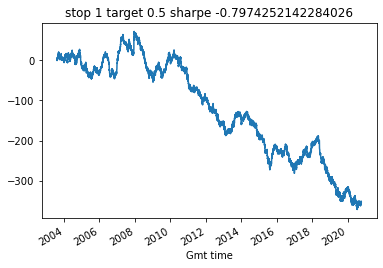

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 2280
# trades gapped stop: 461 | # trades gapped target: 497
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 2174
# trades gapped stop: 467 | # trades gapped target: 395
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 1928
# trades gapped stop: 460 | # trades gapped target: 413
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1590
# trades gapped stop: 573 | # trades gapped target: 500
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 1780
# trades gapped stop: 750 | # trades gapped target: 985
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

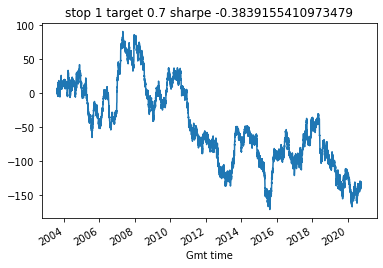

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 1640
# trades gapped stop: 545 | # trades gapped target: 382
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 1508
# trades gapped stop: 538 | # trades gapped target: 327
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 1357
# trades gapped stop: 555 | # trades gapped target: 370
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1018
# trades gapped stop: 680 | # trades gapped target: 370
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1250
# trades gapped stop: 877 | # trades gapped target: 876
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

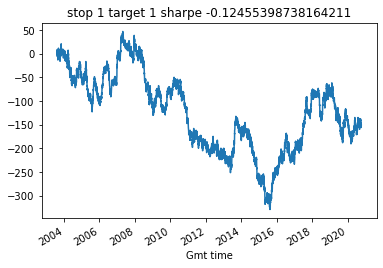

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 887
# trades gapped stop: 647 | # trades gapped target: 151
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 621
# trades gapped stop: 629 | # trades gapped target: 170
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 771
# trades gapped stop: 660 | # trades gapped target: 194
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 487
# trades gapped stop: 757 | # trades gapped target: 176
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 614
# trades gapped stop: 999 | # trades gapped target: 538
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

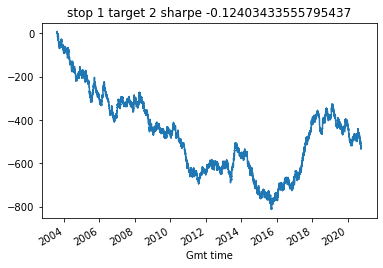

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 541
# trades gapped stop: 675 | # trades gapped target: 102
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 299
# trades gapped stop: 655 | # trades gapped target: 131
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 410
# trades gapped stop: 684 | # trades gapped target: 145
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 231
# trades gapped stop: 806 | # trades gapped target: 171
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 321
# trades gapped stop: 1073 | # trades gapped target: 374
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

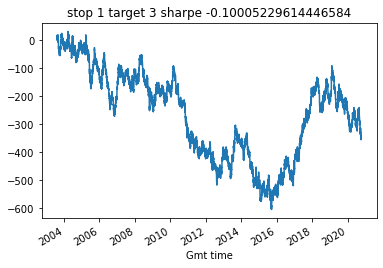

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 346
# trades gapped stop: 699 | # trades gapped target: 84
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 159
# trades gapped stop: 657 | # trades gapped target: 97
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 10
# trades hit both target and stop: 214
# trades gapped stop: 697 | # trades gapped target: 121
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 112
# trades gapped stop: 834 | # trades gapped target: 135
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 160
# trades gapped stop: 1093 | # trades gapped target: 305
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

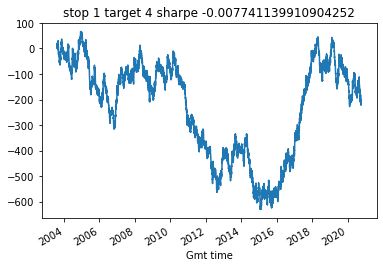

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 178
# trades gapped stop: 688 | # trades gapped target: 81
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 92
# trades gapped stop: 627 | # trades gapped target: 114
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 128
# trades gapped stop: 718 | # trades gapped target: 90
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 46
# trades gapped stop: 835 | # trades gapped target: 87
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 53
# trades gapped stop: 1105 | # trades gapped target: 235
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

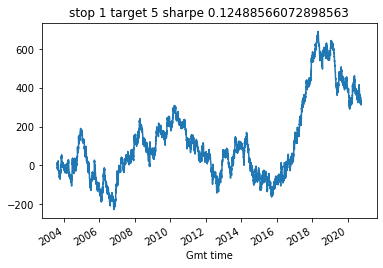

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 76
# trades gapped stop: 676 | # trades gapped target: 46
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 47
# trades gapped stop: 603 | # trades gapped target: 59
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 17
# trades hit both target and stop: 21
# trades gapped stop: 716 | # trades gapped target: 62
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 20
# trades hit both target and stop: 14
# trades gapped stop: 739 | # trades gapped target: 74
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 25
# trades hit both target and stop: 12
# trades gapped stop: 1002 | # trades gapped target: 172
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

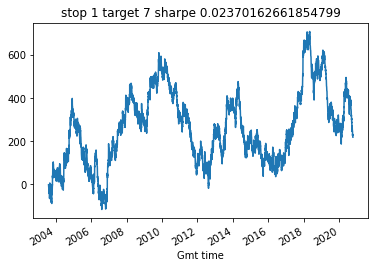

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 30
# trades hit both target and stop: 3
# trades gapped stop: 637 | # trades gapped target: 34
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 25
# trades hit both target and stop: 8
# trades gapped stop: 552 | # trades gapped target: 39
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 18
# trades hit both target and stop: 7
# trades gapped stop: 660 | # trades gapped target: 30
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 67
# trades hit both target and stop: 0
# trades gapped stop: 643 | # trades gapped target: 24
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 36
# trades hit both target and stop: 0
# trades gapped stop: 909 | # trades gapped target: 68
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

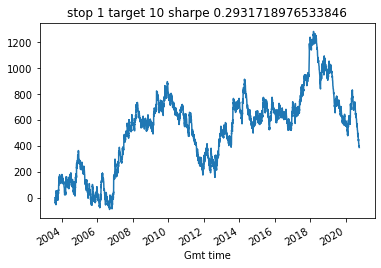

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 88
# trades hit both target and stop: 0
# trades gapped stop: 421 | # trades gapped target: 13
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 87
# trades hit both target and stop: 0
# trades gapped stop: 367 | # trades gapped target: 17
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 82
# trades hit both target and stop: 5
# trades gapped stop: 472 | # trades gapped target: 11
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 155
# trades hit both target and stop: 0
# trades gapped stop: 421 | # trades gapped target: 28
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 171
# trades hit both target and stop: 0
# trades gapped stop: 621 | # trades gapped target: 61
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trade

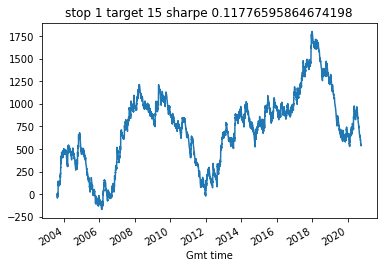

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1449
# trades gapped stop: 77 | # trades gapped target: 2644
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1483
# trades gapped stop: 76 | # trades gapped target: 1570
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1451
# trades gapped stop: 69 | # trades gapped target: 2444
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1060
# trades gapped stop: 83 | # trades gapped target: 2842
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1164
# trades gapped stop: 153 | # trades gapped target: 4264
before filter 107888 after filter 5043
5 USDCAD_1h_2003-20

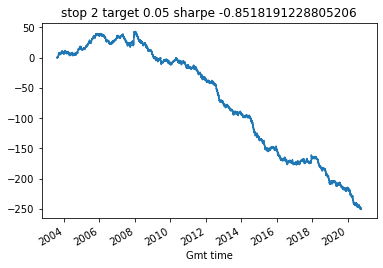

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1159
# trades gapped stop: 105 | # trades gapped target: 792
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 1214
# trades gapped stop: 109 | # trades gapped target: 680
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 1147
# trades gapped stop: 108 | # trades gapped target: 801
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 805
# trades gapped stop: 115 | # trades gapped target: 1091
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 941
# trades gapped stop: 191 | # trades gapped target: 1635
before filter 107888 after filter 5043
5 USDCAD_1h_2003-202

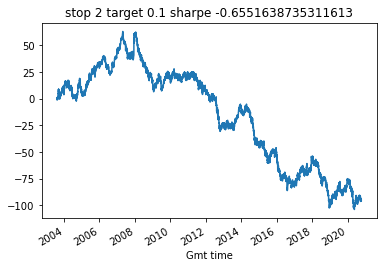

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 934
# trades gapped stop: 151 | # trades gapped target: 602
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 854
# trades gapped stop: 170 | # trades gapped target: 547
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 895
# trades gapped stop: 178 | # trades gapped target: 617
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 627
# trades gapped stop: 165 | # trades gapped target: 633
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 683
# trades gapped stop: 253 | # trades gapped target: 1123
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

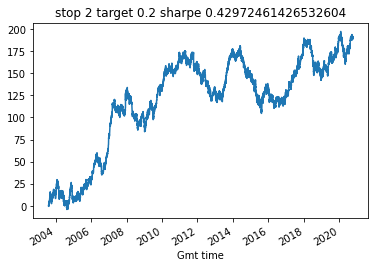

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 913
# trades gapped stop: 182 | # trades gapped target: 571
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 732
# trades gapped stop: 217 | # trades gapped target: 480
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 799
# trades gapped stop: 222 | # trades gapped target: 522
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 541
# trades gapped stop: 216 | # trades gapped target: 563
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 561
# trades gapped stop: 321 | # trades gapped target: 1033
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

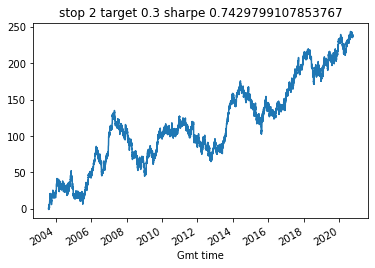

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 822
# trades gapped stop: 222 | # trades gapped target: 422
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 644
# trades gapped stop: 287 | # trades gapped target: 365
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 717
# trades gapped stop: 298 | # trades gapped target: 463
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 449
# trades gapped stop: 320 | # trades gapped target: 432
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 511
# trades gapped stop: 423 | # trades gapped target: 925
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

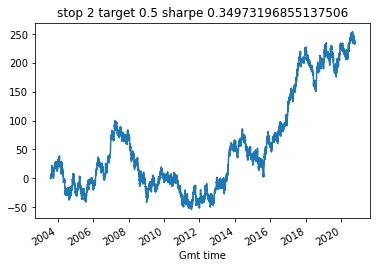

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 794
# trades gapped stop: 265 | # trades gapped target: 288
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 521
# trades gapped stop: 345 | # trades gapped target: 303
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 663
# trades gapped stop: 367 | # trades gapped target: 372
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 380
# trades gapped stop: 367 | # trades gapped target: 358
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 437
# trades gapped stop: 471 | # trades gapped target: 773
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

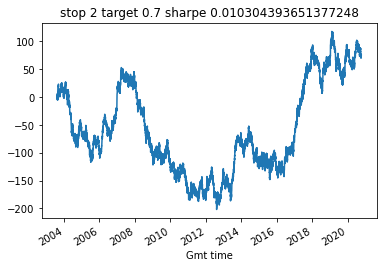

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 666
# trades gapped stop: 306 | # trades gapped target: 184
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 408
# trades gapped stop: 403 | # trades gapped target: 225
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 616
# trades gapped stop: 403 | # trades gapped target: 280
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 281
# trades gapped stop: 425 | # trades gapped target: 260
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 286
# trades gapped stop: 567 | # trades gapped target: 647
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

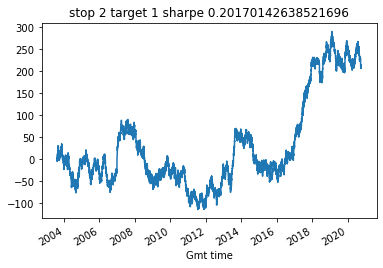

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 285
# trades gapped stop: 412 | # trades gapped target: 145
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 125
# trades gapped stop: 455 | # trades gapped target: 147
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 22
# trades hit both target and stop: 150
# trades gapped stop: 525 | # trades gapped target: 178
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 24
# trades hit both target and stop: 110
# trades gapped stop: 550 | # trades gapped target: 203
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 20
# trades hit both target and stop: 46
# trades gapped stop: 718 | # trades gapped target: 443
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.

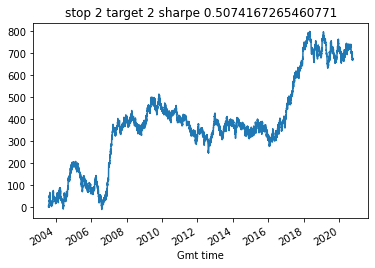

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 19
# trades hit both target and stop: 132
# trades gapped stop: 422 | # trades gapped target: 70
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 77
# trades gapped stop: 433 | # trades gapped target: 131
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 32
# trades hit both target and stop: 21
# trades gapped stop: 561 | # trades gapped target: 94
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 37
# trades hit both target and stop: 34
# trades gapped stop: 526 | # trades gapped target: 130
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 38
# trades hit both target and stop: 22
# trades gapped stop: 694 | # trades gapped target: 271
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


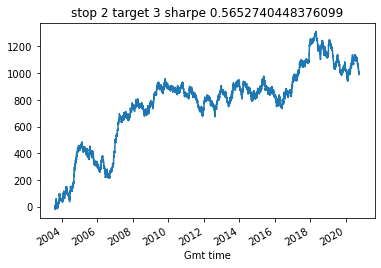

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 29
# trades hit both target and stop: 40
# trades gapped stop: 439 | # trades gapped target: 101
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 22
# trades hit both target and stop: 6
# trades gapped stop: 433 | # trades gapped target: 114
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 35
# trades hit both target and stop: 11
# trades gapped stop: 568 | # trades gapped target: 64
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 74
# trades hit both target and stop: 9
# trades gapped stop: 479 | # trades gapped target: 44
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 0
# trades gapped stop: 614 | # trades gapped target: 212
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

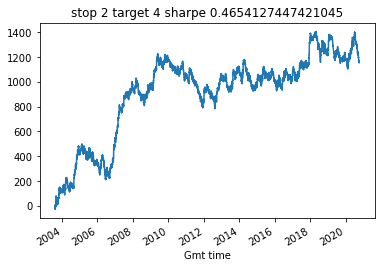

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 93
# trades hit both target and stop: 0
# trades gapped stop: 424 | # trades gapped target: 48
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 61
# trades hit both target and stop: 0
# trades gapped stop: 384 | # trades gapped target: 71
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 48
# trades hit both target and stop: 10
# trades gapped stop: 539 | # trades gapped target: 48
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 124
# trades hit both target and stop: 0
# trades gapped stop: 456 | # trades gapped target: 33
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 62
# trades hit both target and stop: 0
# trades gapped stop: 613 | # trades gapped target: 138
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

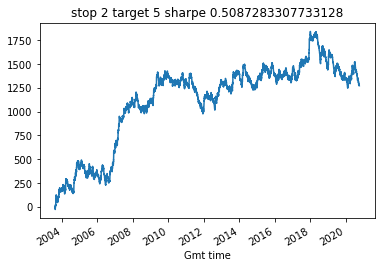

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 175
# trades hit both target and stop: 0
# trades gapped stop: 313 | # trades gapped target: 48
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 188
# trades hit both target and stop: 0
# trades gapped stop: 244 | # trades gapped target: 36
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 174
# trades hit both target and stop: 7
# trades gapped stop: 417 | # trades gapped target: 33
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 287
# trades hit both target and stop: 0
# trades gapped stop: 315 | # trades gapped target: 65
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 300
# trades hit both target and stop: 0
# trades gapped stop: 496 | # trades gapped target: 99
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

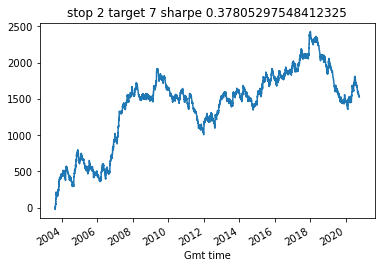

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 714
# trades hit both target and stop: 0
# trades gapped stop: 211 | # trades gapped target: 7
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 643
# trades hit both target and stop: 0
# trades gapped stop: 153 | # trades gapped target: 12
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 972
# trades hit both target and stop: 7
# trades gapped stop: 209 | # trades gapped target: 4
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1186
# trades hit both target and stop: 0
# trades gapped stop: 176 | # trades gapped target: 22
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1499
# trades hit both target and stop: 0
# trades gapped stop: 285 | # trades gapped target: 38
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

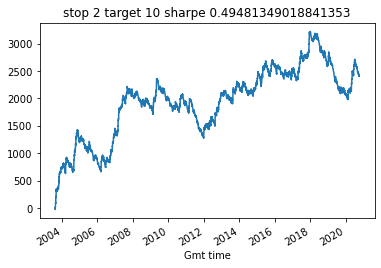

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2802
# trades hit both target and stop: 0
# trades gapped stop: 75 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2561
# trades hit both target and stop: 0
# trades gapped stop: 72 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 3838
# trades hit both target and stop: 0
# trades gapped stop: 97 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4720
# trades hit both target and stop: 0
# trades gapped stop: 61 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5607
# trades hit both target and stop: 0
# trades gapped stop: 103 | # trades gapped target: 20
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trade

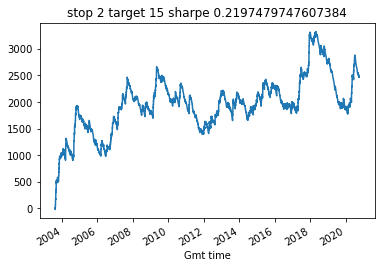

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 384
# trades gapped stop: 41 | # trades gapped target: 1173
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 371
# trades gapped stop: 30 | # trades gapped target: 838
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 459
# trades gapped stop: 61 | # trades gapped target: 1181
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 288
# trades gapped stop: 40 | # trades gapped target: 1583
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 289
# trades gapped stop: 62 | # trades gapped target: 2339
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


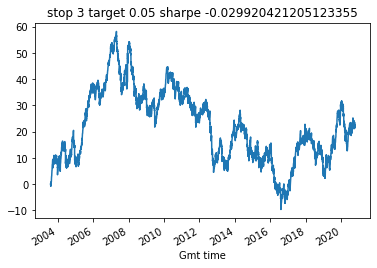

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 380
# trades gapped stop: 66 | # trades gapped target: 641
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 319
# trades gapped stop: 56 | # trades gapped target: 566
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 413
# trades gapped stop: 86 | # trades gapped target: 618
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 265
# trades gapped stop: 68 | # trades gapped target: 700
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 248
# trades gapped stop: 78 | # trades gapped target: 1200
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

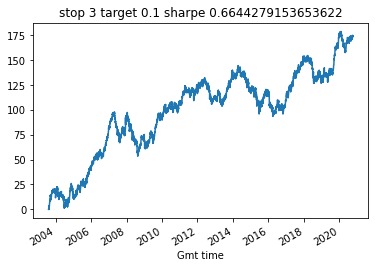

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 442
# trades gapped stop: 106 | # trades gapped target: 571
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 297
# trades gapped stop: 93 | # trades gapped target: 494
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 440
# trades gapped stop: 162 | # trades gapped target: 546
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 258
# trades gapped stop: 129 | # trades gapped target: 590
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 210
# trades gapped stop: 135 | # trades gapped target: 1038
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

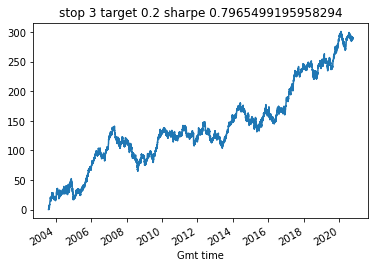

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 431
# trades gapped stop: 144 | # trades gapped target: 477
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 275
# trades gapped stop: 131 | # trades gapped target: 425
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 449
# trades gapped stop: 206 | # trades gapped target: 486
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 253
# trades gapped stop: 178 | # trades gapped target: 522
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 212
# trades gapped stop: 213 | # trades gapped target: 1000
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

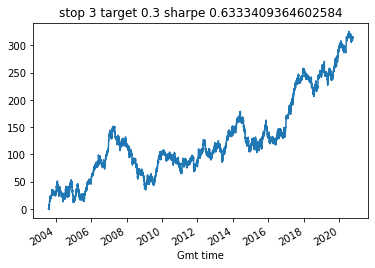

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 402
# trades gapped stop: 237 | # trades gapped target: 268
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 262
# trades gapped stop: 177 | # trades gapped target: 281
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 421
# trades gapped stop: 270 | # trades gapped target: 413
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 252
# trades gapped stop: 260 | # trades gapped target: 386
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 159
# trades gapped stop: 322 | # trades gapped target: 797
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

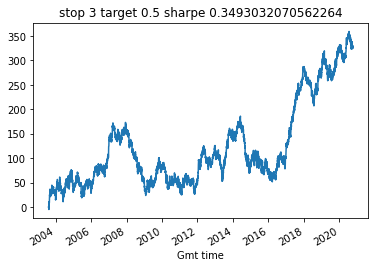

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 343
# trades gapped stop: 299 | # trades gapped target: 192
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 209
# trades gapped stop: 242 | # trades gapped target: 230
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 358
# trades gapped stop: 338 | # trades gapped target: 309
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 231
# trades gapped stop: 312 | # trades gapped target: 294
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 128
# trades gapped stop: 393 | # trades gapped target: 694
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

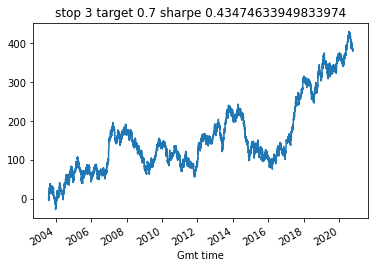

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 288
# trades gapped stop: 335 | # trades gapped target: 212
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 20
# trades hit both target and stop: 144
# trades gapped stop: 289 | # trades gapped target: 191
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 23
# trades hit both target and stop: 186
# trades gapped stop: 456 | # trades gapped target: 256
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 19
# trades hit both target and stop: 170
# trades gapped stop: 348 | # trades gapped target: 275
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 11
# trades hit both target and stop: 53
# trades gapped stop: 480 | # trades gapped target: 596
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020

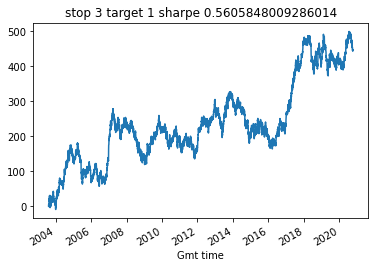

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 31
# trades hit both target and stop: 124
# trades gapped stop: 377 | # trades gapped target: 93
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 27
# trades hit both target and stop: 50
# trades gapped stop: 307 | # trades gapped target: 152
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 56
# trades hit both target and stop: 13
# trades gapped stop: 546 | # trades gapped target: 123
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 46
# trades hit both target and stop: 48
# trades gapped stop: 374 | # trades gapped target: 154
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 46
# trades hit both target and stop: 11
# trades gapped stop: 503 | # trades gapped target: 359
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

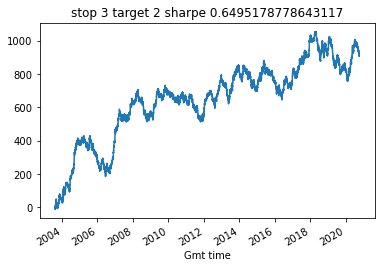

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 118
# trades hit both target and stop: 12
# trades gapped stop: 396 | # trades gapped target: 65
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 61
# trades hit both target and stop: 0
# trades gapped stop: 308 | # trades gapped target: 151
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 94
# trades hit both target and stop: 9
# trades gapped stop: 555 | # trades gapped target: 68
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 116
# trades hit both target and stop: 0
# trades gapped stop: 342 | # trades gapped target: 18
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 63
# trades hit both target and stop: 0
# trades gapped stop: 489 | # trades gapped target: 204
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

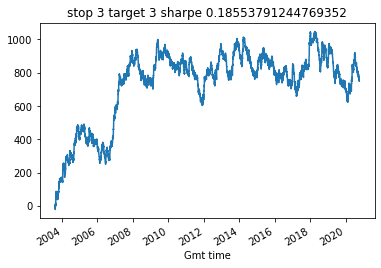

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 246
# trades hit both target and stop: 0
# trades gapped stop: 335 | # trades gapped target: 84
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 212
# trades hit both target and stop: 0
# trades gapped stop: 244 | # trades gapped target: 56
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 186
# trades hit both target and stop: 9
# trades gapped stop: 477 | # trades gapped target: 54
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 331
# trades hit both target and stop: 0
# trades gapped stop: 271 | # trades gapped target: 106
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 257
# trades hit both target and stop: 0
# trades gapped stop: 461 | # trades gapped target: 157
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

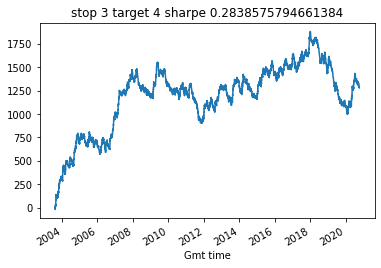

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 397
# trades hit both target and stop: 0
# trades gapped stop: 272 | # trades gapped target: 26
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 400
# trades hit both target and stop: 0
# trades gapped stop: 201 | # trades gapped target: 20
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 431
# trades hit both target and stop: 9
# trades gapped stop: 338 | # trades gapped target: 45
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 676
# trades hit both target and stop: 0
# trades gapped stop: 164 | # trades gapped target: 51
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 855
# trades hit both target and stop: 0
# trades gapped stop: 369 | # trades gapped target: 111
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

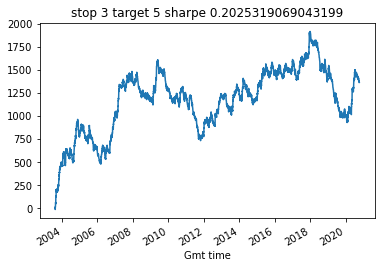

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1765
# trades hit both target and stop: 0
# trades gapped stop: 200 | # trades gapped target: 4
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1372
# trades hit both target and stop: 0
# trades gapped stop: 111 | # trades gapped target: 12
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2214
# trades hit both target and stop: 9
# trades gapped stop: 169 | # trades gapped target: 5
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2913
# trades hit both target and stop: 0
# trades gapped stop: 97 | # trades gapped target: 9
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3204
# trades hit both target and stop: 0
# trades gapped stop: 201 | # trades gapped target: 58
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

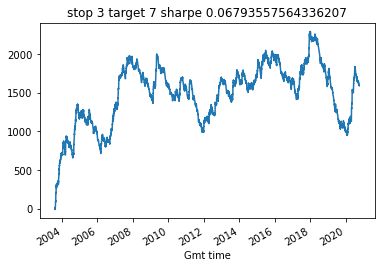

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4990
# trades hit both target and stop: 0
# trades gapped stop: 79 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4327
# trades hit both target and stop: 0
# trades gapped stop: 55 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 5855
# trades hit both target and stop: 0
# trades gapped stop: 74 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 7552
# trades hit both target and stop: 0
# trades gapped stop: 15 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8633
# trades hit both target and stop: 0
# trades gapped stop: 84 | # trades gapped target: 21
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

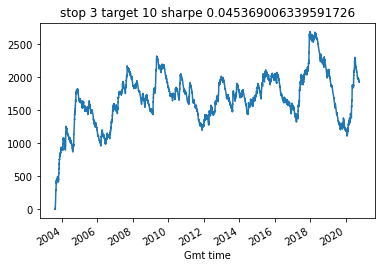

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 9895
# trades hit both target and stop: 0
# trades gapped stop: 19 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 8912
# trades hit both target and stop: 0
# trades gapped stop: 38 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8726
# trades hit both target and stop: 0
# trades gapped stop: 22 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 13198
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 13142
# trades hit both target and stop: 0
# trades gapped stop: 32 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

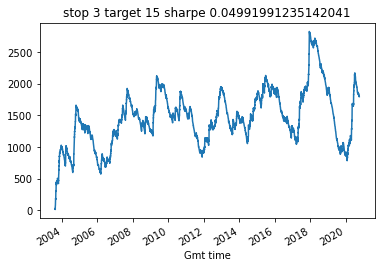

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 176
# trades gapped stop: 29 | # trades gapped target: 740
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 129
# trades gapped stop: 26 | # trades gapped target: 617
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 195
# trades gapped stop: 45 | # trades gapped target: 765
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 0
# trades hit both target and stop: 119
# trades gapped stop: 26 | # trades gapped target: 1030
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 114
# trades gapped stop: 43 | # trades gapped target: 1510
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

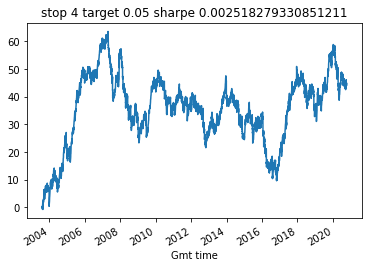

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 211
# trades gapped stop: 67 | # trades gapped target: 576
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 126
# trades gapped stop: 51 | # trades gapped target: 516
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 203
# trades gapped stop: 88 | # trades gapped target: 607
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 150
# trades gapped stop: 48 | # trades gapped target: 643
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 95
# trades gapped stop: 67 | # trades gapped target: 1070
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

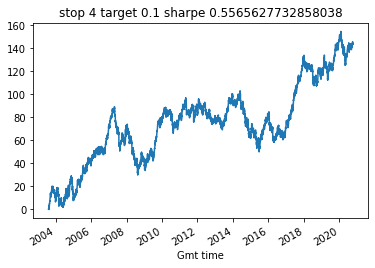

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 242
# trades gapped stop: 136 | # trades gapped target: 508
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 148
# trades gapped stop: 109 | # trades gapped target: 386
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 227
# trades gapped stop: 152 | # trades gapped target: 462
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 161
# trades gapped stop: 84 | # trades gapped target: 570
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 97
# trades gapped stop: 119 | # trades gapped target: 972
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

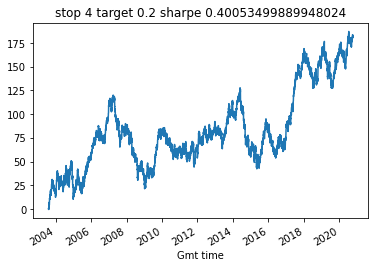

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 199
# trades gapped stop: 195 | # trades gapped target: 364
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 143
# trades gapped stop: 156 | # trades gapped target: 336
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 229
# trades gapped stop: 200 | # trades gapped target: 421
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 173
# trades gapped stop: 127 | # trades gapped target: 443
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 7
# trades hit both target and stop: 103
# trades gapped stop: 186 | # trades gapped target: 876
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

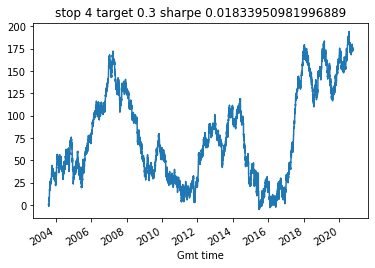

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 216
# trades gapped stop: 252 | # trades gapped target: 234
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 22
# trades hit both target and stop: 134
# trades gapped stop: 230 | # trades gapped target: 241
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 19
# trades hit both target and stop: 190
# trades gapped stop: 298 | # trades gapped target: 334
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 159
# trades gapped stop: 155 | # trades gapped target: 310
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 64
# trades gapped stop: 256 | # trades gapped target: 735
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

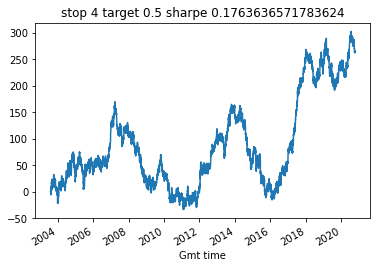

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 13
# trades hit both target and stop: 226
# trades gapped stop: 288 | # trades gapped target: 226
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 34
# trades hit both target and stop: 112
# trades gapped stop: 269 | # trades gapped target: 206
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 31
# trades hit both target and stop: 121
# trades gapped stop: 422 | # trades gapped target: 294
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 19
# trades hit both target and stop: 95
# trades gapped stop: 201 | # trades gapped target: 304
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 17
# trades hit both target and stop: 33
# trades gapped stop: 309 | # trades gapped target: 668
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.

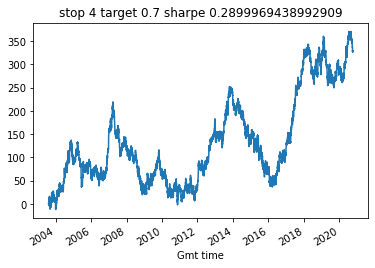

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 26
# trades hit both target and stop: 196
# trades gapped stop: 334 | # trades gapped target: 171
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 38
# trades hit both target and stop: 60
# trades gapped stop: 277 | # trades gapped target: 156
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 48
# trades hit both target and stop: 51
# trades gapped stop: 475 | # trades gapped target: 241
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 36
# trades hit both target and stop: 46
# trades gapped stop: 260 | # trades gapped target: 260
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 37
# trades hit both target and stop: 13
# trades gapped stop: 329 | # trades gapped target: 579
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

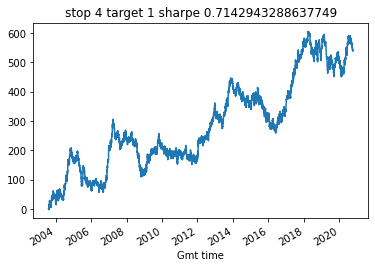

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 115
# trades hit both target and stop: 13
# trades gapped stop: 394 | # trades gapped target: 160
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 76
# trades hit both target and stop: 0
# trades gapped stop: 302 | # trades gapped target: 213
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 175
# trades hit both target and stop: 12
# trades gapped stop: 547 | # trades gapped target: 97
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 119
# trades hit both target and stop: 2
# trades gapped stop: 232 | # trades gapped target: 35
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 68
# trades hit both target and stop: 0
# trades gapped stop: 337 | # trades gapped target: 236
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

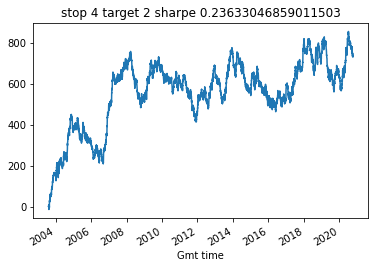

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 344
# trades hit both target and stop: 0
# trades gapped stop: 327 | # trades gapped target: 77
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 318
# trades hit both target and stop: 0
# trades gapped stop: 252 | # trades gapped target: 56
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 424
# trades hit both target and stop: 11
# trades gapped stop: 468 | # trades gapped target: 57
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 551
# trades hit both target and stop: 0
# trades gapped stop: 191 | # trades gapped target: 132
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 370
# trades hit both target and stop: 0
# trades gapped stop: 313 | # trades gapped target: 214
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

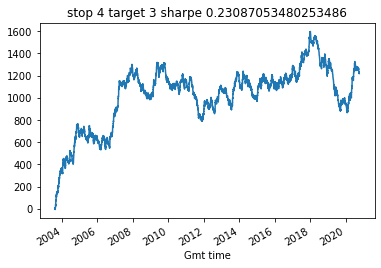

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 986
# trades hit both target and stop: 0
# trades gapped stop: 242 | # trades gapped target: 27
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 800
# trades hit both target and stop: 0
# trades gapped stop: 211 | # trades gapped target: 29
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1094
# trades hit both target and stop: 11
# trades gapped stop: 263 | # trades gapped target: 31
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1617
# trades hit both target and stop: 0
# trades gapped stop: 116 | # trades gapped target: 63
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1824
# trades hit both target and stop: 0
# trades gapped stop: 238 | # trades gapped target: 57
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


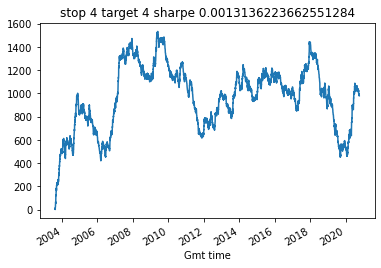

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2395
# trades hit both target and stop: 0
# trades gapped stop: 191 | # trades gapped target: 5
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1948
# trades hit both target and stop: 0
# trades gapped stop: 127 | # trades gapped target: 19
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2843
# trades hit both target and stop: 11
# trades gapped stop: 196 | # trades gapped target: 3
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3894
# trades hit both target and stop: 0
# trades gapped stop: 88 | # trades gapped target: 21
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4060
# trades hit both target and stop: 0
# trades gapped stop: 151 | # trades gapped target: 54
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

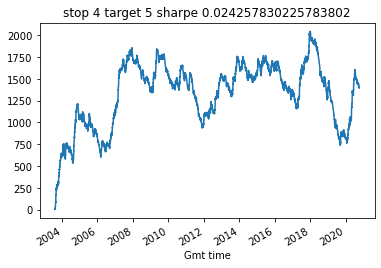

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6391
# trades hit both target and stop: 0
# trades gapped stop: 90 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 5262
# trades hit both target and stop: 0
# trades gapped stop: 61 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 7295
# trades hit both target and stop: 1
# trades gapped stop: 79 | # trades gapped target: 4
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9244
# trades hit both target and stop: 0
# trades gapped stop: 21 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 10186
# trades hit both target and stop: 0
# trades gapped stop: 73 | # trades gapped target: 14
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trade

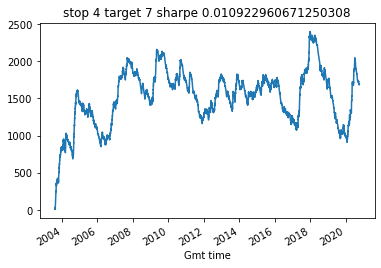

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 12177
# trades hit both target and stop: 0
# trades gapped stop: 9 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 10589
# trades hit both target and stop: 0
# trades gapped stop: 30 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 10833
# trades hit both target and stop: 0
# trades gapped stop: 24 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 16378
# trades hit both target and stop: 0
# trades gapped stop: 2 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 16126
# trades hit both target and stop: 0
# trades gapped stop: 10 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

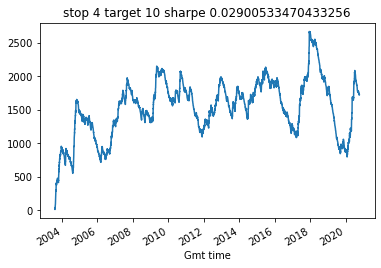

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 17671
# trades hit both target and stop: 0
# trades gapped stop: 4 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 14418
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 12462
# trades hit both target and stop: 0
# trades gapped stop: 19 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 18929
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 18695
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

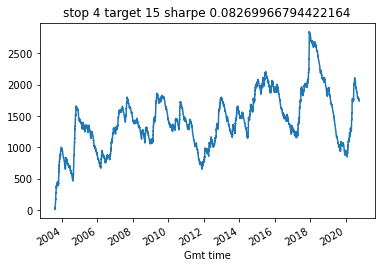

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 104
# trades gapped stop: 29 | # trades gapped target: 622
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 67
# trades gapped stop: 29 | # trades gapped target: 539
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 117
# trades gapped stop: 54 | # trades gapped target: 623
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 58
# trades gapped stop: 12 | # trades gapped target: 733
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 52
# trades gapped stop: 34 | # trades gapped target: 1210
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

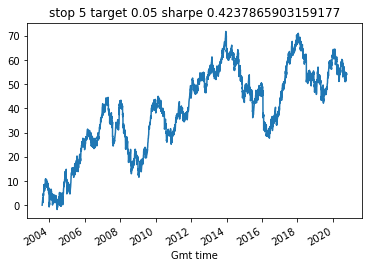

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 120
# trades gapped stop: 54 | # trades gapped target: 565
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 86
# trades gapped stop: 67 | # trades gapped target: 493
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 133
# trades gapped stop: 96 | # trades gapped target: 576
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 92
# trades gapped stop: 26 | # trades gapped target: 558
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 40
# trades gapped stop: 71 | # trades gapped target: 1030
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

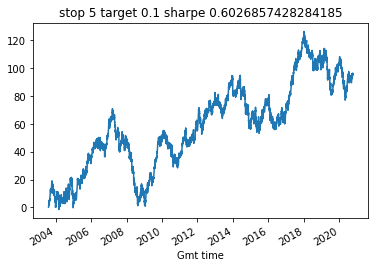

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 129
# trades gapped stop: 116 | # trades gapped target: 419
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 13
# trades hit both target and stop: 91
# trades gapped stop: 123 | # trades gapped target: 334
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 150
# trades gapped stop: 198 | # trades gapped target: 504
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 113
# trades gapped stop: 70 | # trades gapped target: 443
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 62
# trades gapped stop: 129 | # trades gapped target: 905
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


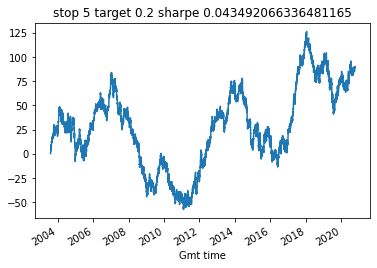

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 151
# trades gapped stop: 166 | # trades gapped target: 289
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 21
# trades hit both target and stop: 78
# trades gapped stop: 151 | # trades gapped target: 272
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 17
# trades hit both target and stop: 131
# trades gapped stop: 259 | # trades gapped target: 436
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 100
# trades gapped stop: 91 | # trades gapped target: 349
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 47
# trades gapped stop: 171 | # trades gapped target: 796
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


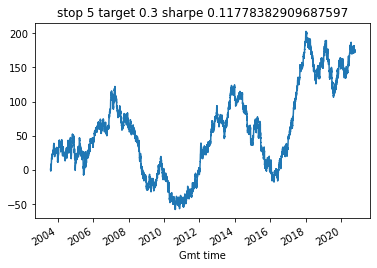

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 16
# trades hit both target and stop: 152
# trades gapped stop: 219 | # trades gapped target: 236
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 35
# trades hit both target and stop: 95
# trades gapped stop: 198 | # trades gapped target: 209
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 33
# trades hit both target and stop: 69
# trades gapped stop: 408 | # trades gapped target: 350
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 15
# trades hit both target and stop: 37
# trades gapped stop: 145 | # trades gapped target: 306
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 13
# trades hit both target and stop: 24
# trades gapped stop: 207 | # trades gapped target: 667
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

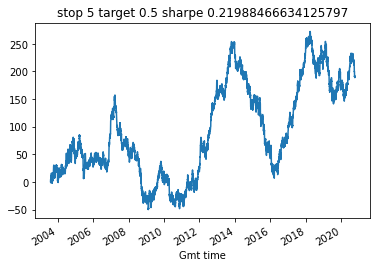

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 25
# trades hit both target and stop: 133
# trades gapped stop: 265 | # trades gapped target: 198
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 51
# trades hit both target and stop: 73
# trades gapped stop: 238 | # trades gapped target: 191
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 68
# trades hit both target and stop: 22
# trades gapped stop: 518 | # trades gapped target: 312
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 31
# trades hit both target and stop: 19
# trades gapped stop: 194 | # trades gapped target: 280
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 24
# trades hit both target and stop: 10
# trades gapped stop: 213 | # trades gapped target: 581
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

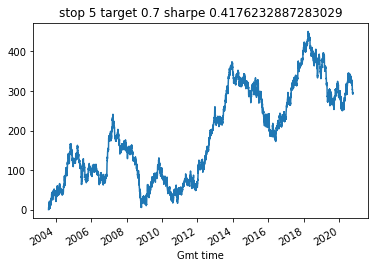

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 45
# trades hit both target and stop: 73
# trades gapped stop: 270 | # trades gapped target: 170
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 64
# trades hit both target and stop: 38
# trades gapped stop: 268 | # trades gapped target: 188
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 118
# trades hit both target and stop: 14
# trades gapped stop: 599 | # trades gapped target: 226
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 46
# trades hit both target and stop: 15
# trades gapped stop: 206 | # trades gapped target: 203
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 0
# trades gapped stop: 224 | # trades gapped target: 505
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

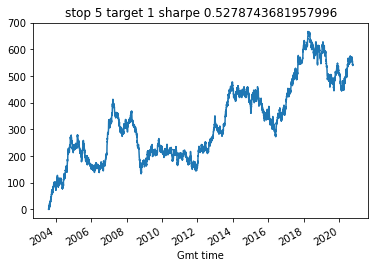

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 293
# trades hit both target and stop: 0
# trades gapped stop: 305 | # trades gapped target: 77
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 205
# trades hit both target and stop: 0
# trades gapped stop: 255 | # trades gapped target: 132
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 462
# trades hit both target and stop: 14
# trades gapped stop: 608 | # trades gapped target: 64
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 368
# trades hit both target and stop: 0
# trades gapped stop: 127 | # trades gapped target: 110
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 201
# trades hit both target and stop: 0
# trades gapped stop: 216 | # trades gapped target: 234
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


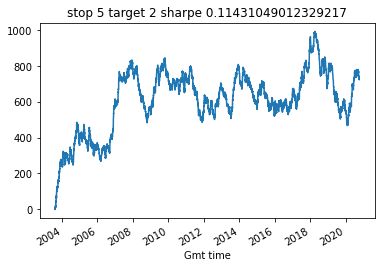

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1088
# trades hit both target and stop: 0
# trades gapped stop: 210 | # trades gapped target: 19
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 960
# trades hit both target and stop: 0
# trades gapped stop: 224 | # trades gapped target: 33
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1526
# trades hit both target and stop: 16
# trades gapped stop: 322 | # trades gapped target: 53
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1856
# trades hit both target and stop: 0
# trades gapped stop: 91 | # trades gapped target: 71
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2072
# trades hit both target and stop: 0
# trades gapped stop: 146 | # trades gapped target: 127
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

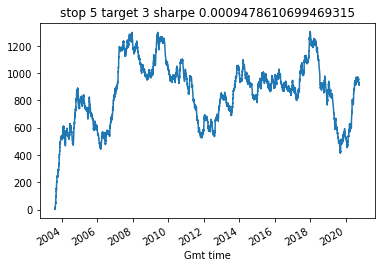

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3436
# trades hit both target and stop: 0
# trades gapped stop: 179 | # trades gapped target: 5
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 2659
# trades hit both target and stop: 0
# trades gapped stop: 97 | # trades gapped target: 19
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4249
# trades hit both target and stop: 15
# trades gapped stop: 224 | # trades gapped target: 3
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5438
# trades hit both target and stop: 0
# trades gapped stop: 51 | # trades gapped target: 20
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5625
# trades hit both target and stop: 0
# trades gapped stop: 68 | # trades gapped target: 66
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

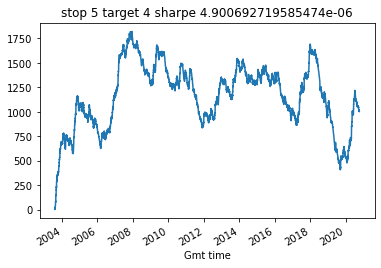

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6494
# trades hit both target and stop: 0
# trades gapped stop: 91 | # trades gapped target: 1
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 5039
# trades hit both target and stop: 0
# trades gapped stop: 53 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 7858
# trades hit both target and stop: 11
# trades gapped stop: 124 | # trades gapped target: 1
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9491
# trades hit both target and stop: 0
# trades gapped stop: 34 | # trades gapped target: 1
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 10276
# trades hit both target and stop: 0
# trades gapped stop: 32 | # trades gapped target: 98
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tra

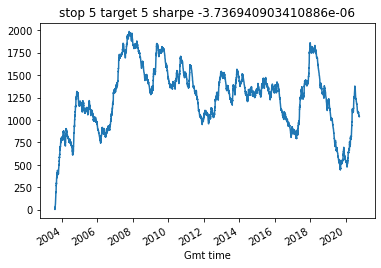

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 13046
# trades hit both target and stop: 0
# trades gapped stop: 50 | # trades gapped target: 2
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 11149
# trades hit both target and stop: 0
# trades gapped stop: 9 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 12335
# trades hit both target and stop: 0
# trades gapped stop: 63 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 17748
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 17704
# trades hit both target and stop: 0
# trades gapped stop: 9 | # trades gapped target: 7
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trade

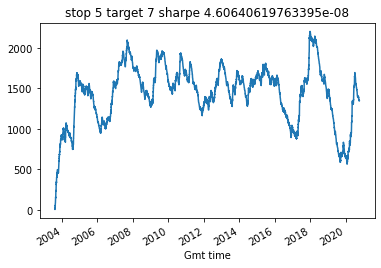

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 19817
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 16157
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 15235
# trades hit both target and stop: 0
# trades gapped stop: 10 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 23122
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 22074
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

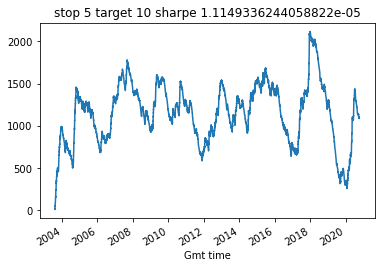

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 22898
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 18870
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 16756
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 23730
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 23329
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

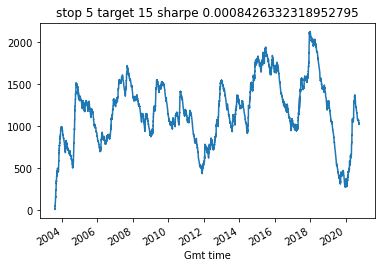

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 30
# trades gapped stop: 30 | # trades gapped target: 559
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 10
# trades gapped stop: 40 | # trades gapped target: 468
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 33
# trades gapped stop: 54 | # trades gapped target: 592
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 22
# trades gapped stop: 16 | # trades gapped target: 568
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1
# trades hit both target and stop: 10
# trades gapped stop: 25 | # trades gapped target: 1025
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

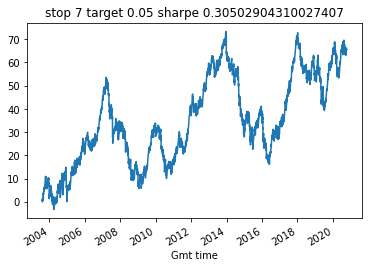

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 48
# trades gapped stop: 63 | # trades gapped target: 493
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 24
# trades hit both target and stop: 18
# trades gapped stop: 58 | # trades gapped target: 371
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 10
# trades hit both target and stop: 41
# trades gapped stop: 107 | # trades gapped target: 501
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5
# trades hit both target and stop: 22
# trades gapped stop: 36 | # trades gapped target: 494
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3
# trades hit both target and stop: 12
# trades gapped stop: 45 | # trades gapped target: 923
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

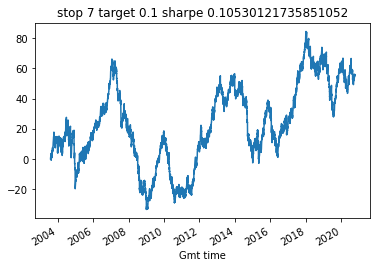

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 15
# trades hit both target and stop: 86
# trades gapped stop: 146 | # trades gapped target: 314
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 25
# trades gapped stop: 93 | # trades gapped target: 296
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 29
# trades hit both target and stop: 25
# trades gapped stop: 193 | # trades gapped target: 440
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 9
# trades hit both target and stop: 33
# trades gapped stop: 59 | # trades gapped target: 351
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 12
# trades gapped stop: 72 | # trades gapped target: 779
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

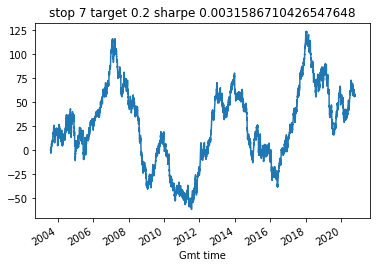

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 28
# trades hit both target and stop: 79
# trades gapped stop: 191 | # trades gapped target: 237
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 82
# trades hit both target and stop: 38
# trades gapped stop: 118 | # trades gapped target: 245
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 54
# trades hit both target and stop: 19
# trades gapped stop: 270 | # trades gapped target: 365
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 32
# trades gapped stop: 75 | # trades gapped target: 274
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 10
# trades hit both target and stop: 5
# trades gapped stop: 100 | # trades gapped target: 656
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

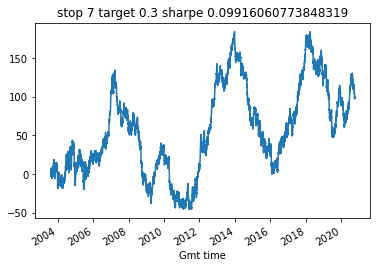

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 48
# trades hit both target and stop: 27
# trades gapped stop: 224 | # trades gapped target: 228
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 129
# trades hit both target and stop: 20
# trades gapped stop: 173 | # trades gapped target: 196
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 113
# trades hit both target and stop: 15
# trades gapped stop: 397 | # trades gapped target: 340
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 31
# trades hit both target and stop: 15
# trades gapped stop: 121 | # trades gapped target: 276
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 24
# trades hit both target and stop: 0
# trades gapped stop: 130 | # trades gapped target: 556
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

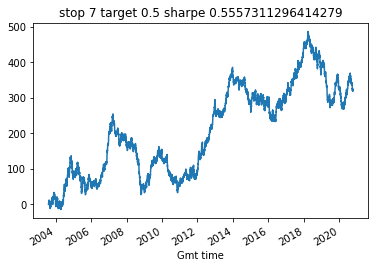

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 70
# trades hit both target and stop: 18
# trades gapped stop: 254 | # trades gapped target: 215
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 181
# trades hit both target and stop: 0
# trades gapped stop: 214 | # trades gapped target: 221
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 180
# trades hit both target and stop: 6
# trades gapped stop: 455 | # trades gapped target: 298
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 7
# trades gapped stop: 170 | # trades gapped target: 190
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 0
# trades gapped stop: 128 | # trades gapped target: 521
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

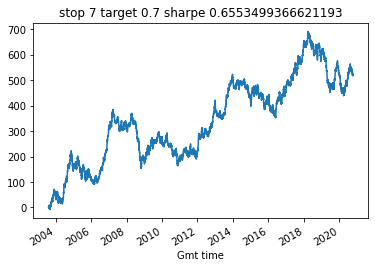

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 154
# trades hit both target and stop: 1
# trades gapped stop: 266 | # trades gapped target: 190
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 254
# trades hit both target and stop: 0
# trades gapped stop: 231 | # trades gapped target: 306
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 445
# trades hit both target and stop: 8
# trades gapped stop: 489 | # trades gapped target: 191
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 161
# trades hit both target and stop: 1
# trades gapped stop: 100 | # trades gapped target: 158
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 142
# trades hit both target and stop: 0
# trades gapped stop: 135 | # trades gapped target: 297
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

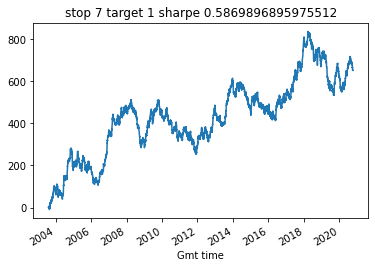

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1534
# trades hit both target and stop: 0
# trades gapped stop: 214 | # trades gapped target: 29
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1615
# trades hit both target and stop: 0
# trades gapped stop: 140 | # trades gapped target: 84
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2632
# trades hit both target and stop: 17
# trades gapped stop: 324 | # trades gapped target: 61
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2697
# trades hit both target and stop: 0
# trades gapped stop: 91 | # trades gapped target: 122
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3333
# trades hit both target and stop: 0
# trades gapped stop: 107 | # trades gapped target: 204
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

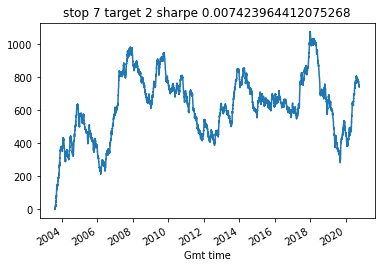

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6542
# trades hit both target and stop: 0
# trades gapped stop: 152 | # trades gapped target: 2
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 5638
# trades hit both target and stop: 0
# trades gapped stop: 62 | # trades gapped target: 12
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8232
# trades hit both target and stop: 12
# trades gapped stop: 243 | # trades gapped target: 3
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 10011
# trades hit both target and stop: 0
# trades gapped stop: 33 | # trades gapped target: 9
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 11002
# trades hit both target and stop: 0
# trades gapped stop: 53 | # trades gapped target: 96
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

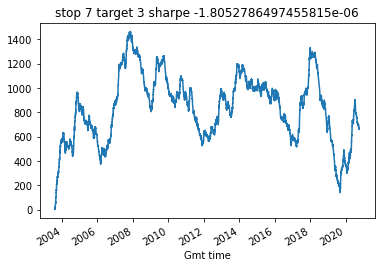

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 13196
# trades hit both target and stop: 0
# trades gapped stop: 90 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 11794
# trades hit both target and stop: 0
# trades gapped stop: 9 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 14611
# trades hit both target and stop: 5
# trades gapped stop: 111 | # trades gapped target: 4
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 18151
# trades hit both target and stop: 0
# trades gapped stop: 8 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 18996
# trades hit both target and stop: 0
# trades gapped stop: 31 | # trades gapped target: 14
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

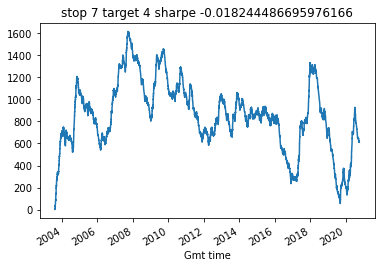

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 19058
# trades hit both target and stop: 0
# trades gapped stop: 44 | # trades gapped target: 2
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 17318
# trades hit both target and stop: 0
# trades gapped stop: 7 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 18170
# trades hit both target and stop: 0
# trades gapped stop: 49 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 25185
# trades hit both target and stop: 0
# trades gapped stop: 2 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 24981
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 7
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trade

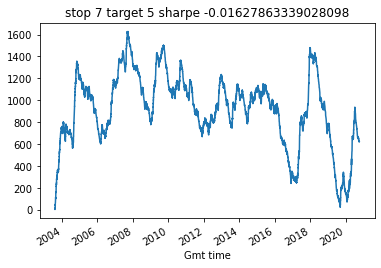

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 27291
# trades hit both target and stop: 0
# trades gapped stop: 3 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 23215
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 21604
# trades hit both target and stop: 0
# trades gapped stop: 5 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 31336
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 29952
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

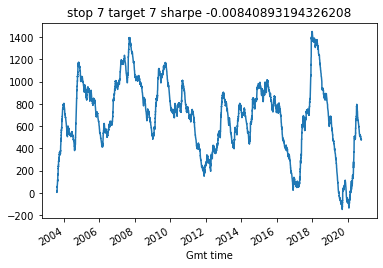

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 31045
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 26469
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 23199
# trades hit both target and stop: 0
# trades gapped stop: 5 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 32126
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 31516
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

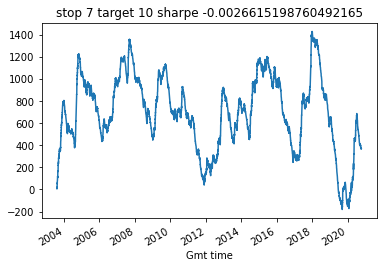

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 31282
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 26914
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 24793
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 32126
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 31654
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

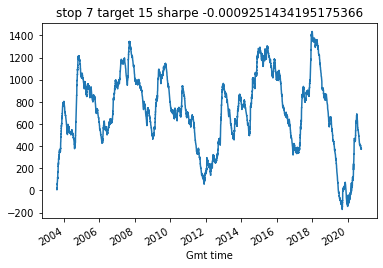

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 3
# trades gapped stop: 14 | # trades gapped target: 474
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 18
# trades hit both target and stop: 11
# trades gapped stop: 26 | # trades gapped target: 420
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 35
# trades hit both target and stop: 7
# trades gapped stop: 66 | # trades gapped target: 498
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 4
# trades hit both target and stop: 18
# trades gapped stop: 16 | # trades gapped target: 449
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2
# trades hit both target and stop: 0
# trades gapped stop: 20 | # trades gapped target: 887
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades n

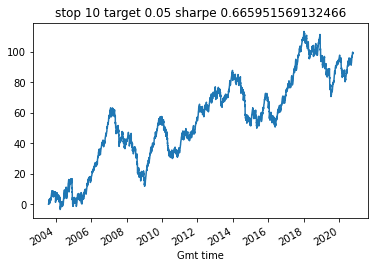

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 14
# trades hit both target and stop: 0
# trades gapped stop: 31 | # trades gapped target: 387
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 48
# trades hit both target and stop: 10
# trades gapped stop: 62 | # trades gapped target: 280
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 84
# trades hit both target and stop: 5
# trades gapped stop: 120 | # trades gapped target: 447
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 26
# trades gapped stop: 42 | # trades gapped target: 390
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 6
# trades hit both target and stop: 0
# trades gapped stop: 30 | # trades gapped target: 774
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades

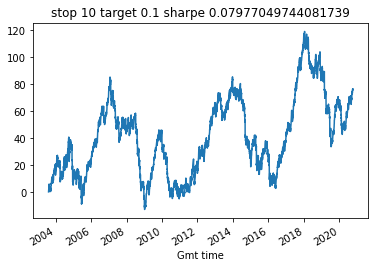

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 34
# trades hit both target and stop: 0
# trades gapped stop: 72 | # trades gapped target: 269
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 91
# trades hit both target and stop: 0
# trades gapped stop: 111 | # trades gapped target: 253
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 189
# trades hit both target and stop: 0
# trades gapped stop: 219 | # trades gapped target: 350
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 12
# trades hit both target and stop: 25
# trades gapped stop: 82 | # trades gapped target: 258
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 8
# trades hit both target and stop: 0
# trades gapped stop: 37 | # trades gapped target: 625
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

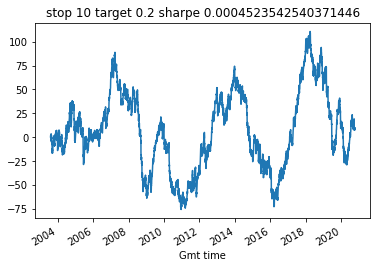

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 60
# trades hit both target and stop: 0
# trades gapped stop: 100 | # trades gapped target: 257
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 129
# trades hit both target and stop: 0
# trades gapped stop: 156 | # trades gapped target: 199
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 268
# trades hit both target and stop: 4
# trades gapped stop: 277 | # trades gapped target: 342
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 29
# trades hit both target and stop: 13
# trades gapped stop: 98 | # trades gapped target: 251
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 25
# trades hit both target and stop: 0
# trades gapped stop: 44 | # trades gapped target: 583
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# t

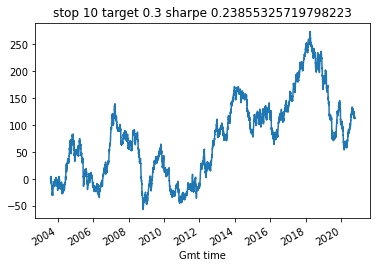

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 145
# trades hit both target and stop: 0
# trades gapped stop: 168 | # trades gapped target: 227
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 247
# trades hit both target and stop: 0
# trades gapped stop: 172 | # trades gapped target: 260
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 585
# trades hit both target and stop: 10
# trades gapped stop: 349 | # trades gapped target: 257
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 122
# trades hit both target and stop: 6
# trades gapped stop: 88 | # trades gapped target: 207
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 227
# trades hit both target and stop: 0
# trades gapped stop: 44 | # trades gapped target: 455
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv


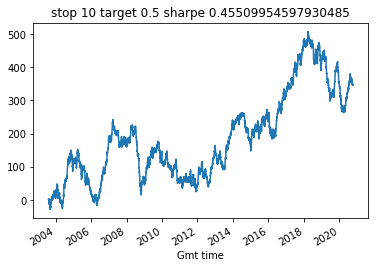

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 316
# trades hit both target and stop: 0
# trades gapped stop: 167 | # trades gapped target: 186
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 454
# trades hit both target and stop: 0
# trades gapped stop: 214 | # trades gapped target: 329
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1292
# trades hit both target and stop: 22
# trades gapped stop: 348 | # trades gapped target: 188
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 529
# trades hit both target and stop: 1
# trades gapped stop: 82 | # trades gapped target: 142
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 979
# trades hit both target and stop: 0
# trades gapped stop: 41 | # trades gapped target: 293
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

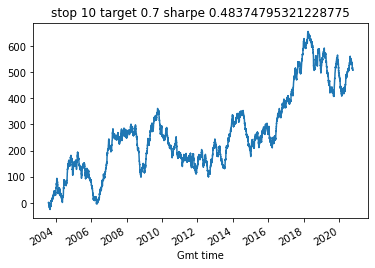

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 1208
# trades hit both target and stop: 0
# trades gapped stop: 188 | # trades gapped target: 46
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1223
# trades hit both target and stop: 0
# trades gapped stop: 193 | # trades gapped target: 181
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 2562
# trades hit both target and stop: 32
# trades gapped stop: 317 | # trades gapped target: 108
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1747
# trades hit both target and stop: 0
# trades gapped stop: 139 | # trades gapped target: 158
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 2555
# trades hit both target and stop: 0
# trades gapped stop: 28 | # trades gapped target: 332
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020

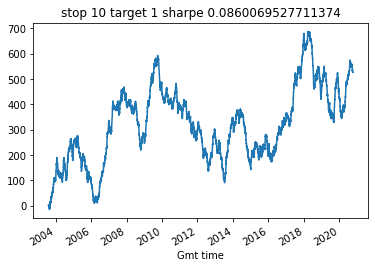

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 10565
# trades hit both target and stop: 0
# trades gapped stop: 123 | # trades gapped target: 2
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 10061
# trades hit both target and stop: 0
# trades gapped stop: 98 | # trades gapped target: 15
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 13405
# trades hit both target and stop: 15
# trades gapped stop: 173 | # trades gapped target: 2
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 15465
# trades hit both target and stop: 0
# trades gapped stop: 94 | # trades gapped target: 1
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 16894
# trades hit both target and stop: 0
# trades gapped stop: 24 | # trades gapped target: 61
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

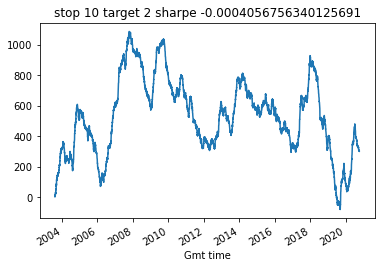

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 22814
# trades hit both target and stop: 0
# trades gapped stop: 39 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 22619
# trades hit both target and stop: 0
# trades gapped stop: 3 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 24671
# trades hit both target and stop: 0
# trades gapped stop: 38 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 29863
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 30667
# trades hit both target and stop: 0
# trades gapped stop: 8 | # trades gapped target: 30
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trad

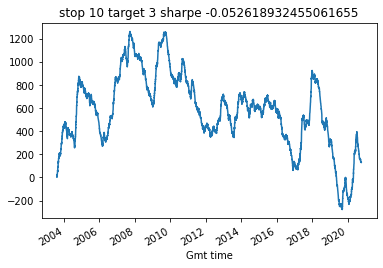

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 32275
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 30530
# trades hit both target and stop: 0
# trades gapped stop: 2 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 30040
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 39776
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 38425
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

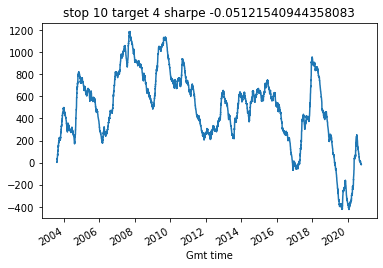

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 37811
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 34528
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 31954
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 42924
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 41132
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

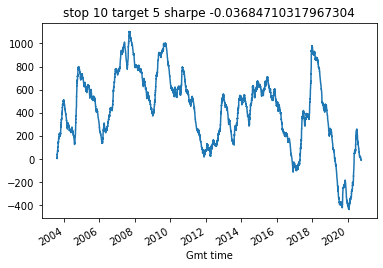

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 41605
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 37781
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 33919
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 43621
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 42695
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

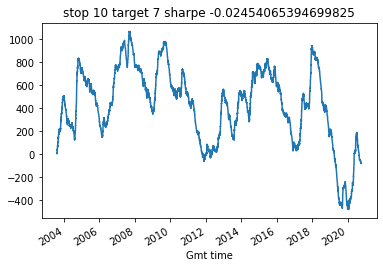

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 41844
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 38302
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 35508
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 43621
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 42834
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

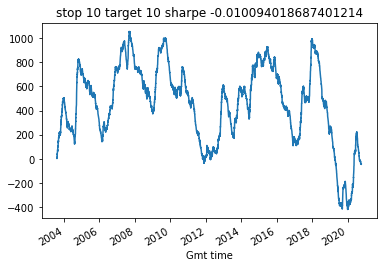

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 41844
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 38328
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 36000
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 43621
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 42834
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

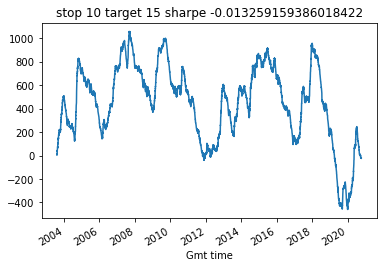

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 54
# trades hit both target and stop: 0
# trades gapped stop: 40 | # trades gapped target: 328
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 68
# trades hit both target and stop: 1
# trades gapped stop: 35 | # trades gapped target: 291
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 151
# trades hit both target and stop: 2
# trades gapped stop: 59 | # trades gapped target: 283
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 17
# trades hit both target and stop: 1
# trades gapped stop: 26 | # trades gapped target: 328
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 50
# trades hit both target and stop: 0
# trades gapped stop: 8 | # trades gapped target: 593
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

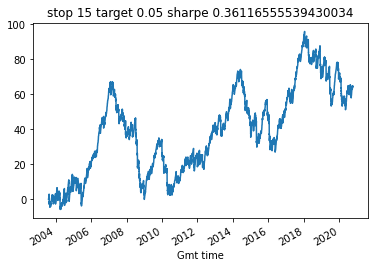

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 113
# trades hit both target and stop: 0
# trades gapped stop: 49 | # trades gapped target: 281
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 136
# trades hit both target and stop: 0
# trades gapped stop: 87 | # trades gapped target: 253
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 404
# trades hit both target and stop: 2
# trades gapped stop: 108 | # trades gapped target: 268
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 51
# trades hit both target and stop: 1
# trades gapped stop: 44 | # trades gapped target: 236
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 176
# trades hit both target and stop: 0
# trades gapped stop: 14 | # trades gapped target: 536
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tr

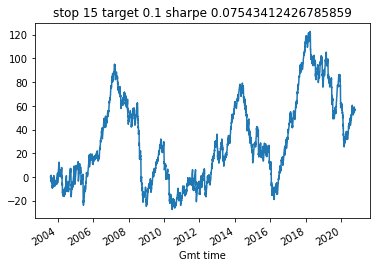

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 259
# trades hit both target and stop: 0
# trades gapped stop: 67 | # trades gapped target: 228
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 372
# trades hit both target and stop: 0
# trades gapped stop: 146 | # trades gapped target: 219
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 957
# trades hit both target and stop: 2
# trades gapped stop: 172 | # trades gapped target: 151
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 305
# trades hit both target and stop: 0
# trades gapped stop: 52 | # trades gapped target: 189
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 774
# trades hit both target and stop: 0
# trades gapped stop: 18 | # trades gapped target: 440
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# 

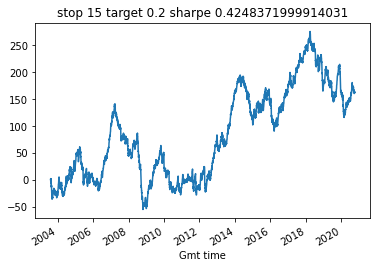

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 612
# trades hit both target and stop: 0
# trades gapped stop: 89 | # trades gapped target: 256
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 684
# trades hit both target and stop: 0
# trades gapped stop: 150 | # trades gapped target: 226
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 1868
# trades hit both target and stop: 8
# trades gapped stop: 199 | # trades gapped target: 98
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 914
# trades hit both target and stop: 0
# trades gapped stop: 68 | # trades gapped target: 200
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 1874
# trades hit both target and stop: 0
# trades gapped stop: 19 | # trades gapped target: 399
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
#

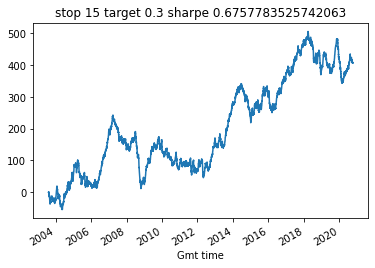

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 2408
# trades hit both target and stop: 0
# trades gapped stop: 113 | # trades gapped target: 123
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 1964
# trades hit both target and stop: 0
# trades gapped stop: 135 | # trades gapped target: 329
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 4760
# trades hit both target and stop: 15
# trades gapped stop: 202 | # trades gapped target: 61
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 3392
# trades hit both target and stop: 0
# trades gapped stop: 70 | # trades gapped target: 116
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 5612
# trades hit both target and stop: 0
# trades gapped stop: 5 | # trades gapped target: 311
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.c

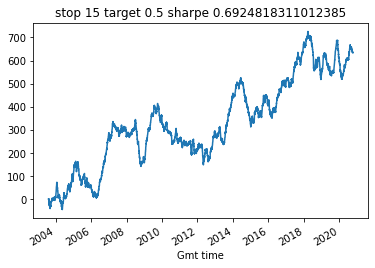

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 6097
# trades hit both target and stop: 0
# trades gapped stop: 98 | # trades gapped target: 32
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 4590
# trades hit both target and stop: 0
# trades gapped stop: 205 | # trades gapped target: 193
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 8405
# trades hit both target and stop: 15
# trades gapped stop: 192 | # trades gapped target: 8
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 7509
# trades hit both target and stop: 0
# trades gapped stop: 64 | # trades gapped target: 117
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 10205
# trades hit both target and stop: 0
# trades gapped stop: 3 | # trades gapped target: 379
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv

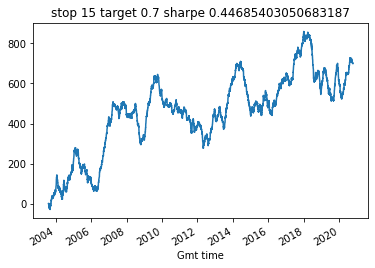

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 13790
# trades hit both target and stop: 0
# trades gapped stop: 74 | # trades gapped target: 15
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 10894
# trades hit both target and stop: 0
# trades gapped stop: 189 | # trades gapped target: 63
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 16346
# trades hit both target and stop: 7
# trades gapped stop: 157 | # trades gapped target: 4
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 16963
# trades hit both target and stop: 0
# trades gapped stop: 56 | # trades gapped target: 33
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 20255
# trades hit both target and stop: 0
# trades gapped stop: 3 | # trades gapped target: 138
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.cs

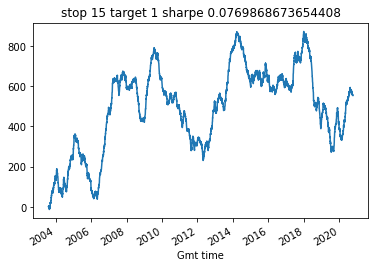

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 37639
# trades hit both target and stop: 0
# trades gapped stop: 17 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 37071
# trades hit both target and stop: 0
# trades gapped stop: 15 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 40523
# trades hit both target and stop: 0
# trades gapped stop: 35 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 45396
# trades hit both target and stop: 0
# trades gapped stop: 2 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 47336
# trades hit both target and stop: 0
# trades gapped stop: 1 | # trades gapped target: 32
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# tra

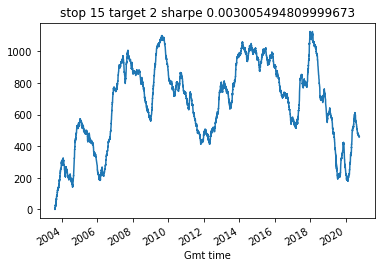

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 52046
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 49025
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 48848
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 58251
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 57311
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

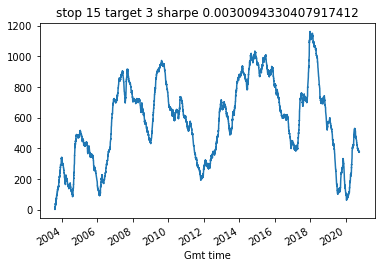

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 57807
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 53323
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 50451
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 59861
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 59682
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

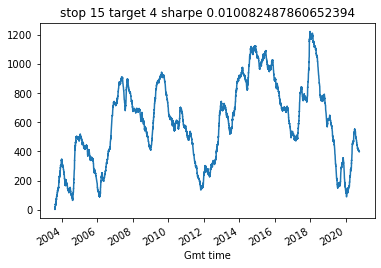

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 58689
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 54756
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 52319
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60016
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60164
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

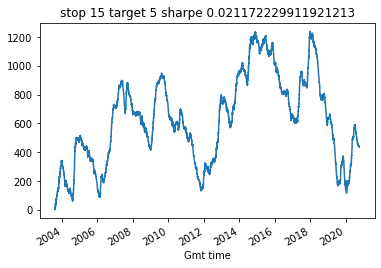

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 58826
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 55159
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 54099
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60016
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60224
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

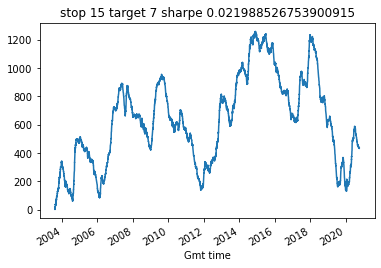

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 58826
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 55159
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 54462
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60016
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60224
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

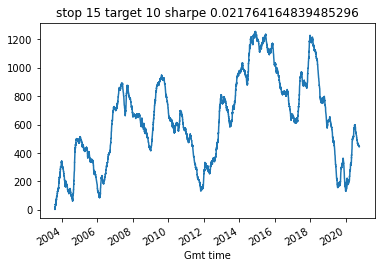

0 EURUSD_1h_2003-2020.csv
# trades not hit target or stop: 58826
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4802
1 GBPUSD_1h_2003-2020.csv
# trades not hit target or stop: 55159
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 4827
2 USDJPY_1h_2003-2020.csv
# trades not hit target or stop: 54462
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107886 after filter 4576
3 NZDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60016
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107880 after filter 5059
4 AUDUSD_1h_2003-2020.csv
# trades not hit target or stop: 60224
# trades hit both target and stop: 0
# trades gapped stop: 0 | # trades gapped target: 0
before filter 107888 after filter 5043
5 USDCAD_1h_2003-2020.csv
# trades 

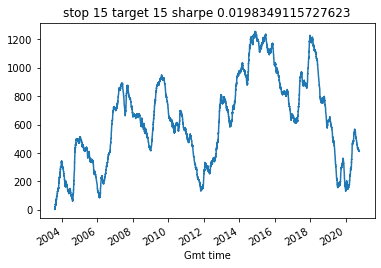

In [92]:
sharpe_ratios = {}
for stop in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 4, 5, 7, 10, 15]:
    for target in [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 4, 5, 7, 10, 15]:
        var.stop_size = stop # size of stop and target relative to averge bar size
        var.target_multiple = target
        data = create_dataset(loaded_files, var)
        #sharpe = calc_sharpe(data['perc_target_stop'], time_frame='1D', scale_returns=0.001)
        sharpe = r2_equity = calc_r2_equity(data['perc_target_stop']) #adjusted_sharpe(data['perc_target_stop'])
        data['perc_target_stop'].cumsum().plot(title=f'stop {stop} target {target} sharpe {sharpe}')
        plt.show()
        sharpe_ratios[(stop, target)] = sharpe

Text(0.5, 1.0, 'sharpe for no filter')

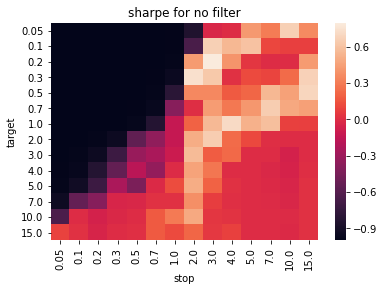

In [93]:
import seaborn as sns
my_data = pd.DataFrame(pd.Series(sharpe_ratios)).reset_index()
my_data.columns = ['stop', 'target', 'sharpe']
my_pivot = pd.pivot(my_data, index='target', columns='stop', values='sharpe')
sns.heatmap(my_pivot).set_title('sharpe for no filter')

In [35]:
# single_inst = data[data['inst'] == 'EURUSD'].copy()
# plot_target_stop(single_inst, var, bars=5000, start_idx=0,
#                  v_line_delta=timedelta(days=6, hours=0, minutes=0), h_line_price=1.3, plotly=True)

In [37]:
def upsample_data(input_data, splits, label):
    print('\n--- upsampling minority classes ---\n')
    for split in splits:
        class_counts = input_data[split][label].value_counts()
        largest_class = class_counts.values.max()
        class_ratios = class_counts.to_dict()
        for cls, n_rows in class_ratios.items():
            diff_from_max = largest_class - n_rows
            class_data = input_data[split][input_data[split][label] == cls]
            samples = class_data.sample(diff_from_max)
            data = pd.concat([input_data[split], samples], axis=0)  
            data.sort_index(inplace=True)
            if split == 'test': 
                input_data['upsample_test'] = data
            else:
                input_data[split] = data
    return input_data

        
def target_stop_ratio(input_data, splits, label='target', problem_type='binary'):
    class_percs = {}
    for split in splits:
        class_ratios = input_data[split][label].value_counts().to_dict()
        print(class_ratios)
        idx = 1 if problem_type == 'binary' else 2
        t_s_perc = input_data[split][label].value_counts(normalize=True).to_dict()
        print(f'percentage that hit target at base ({split}): {t_s_perc[idx]:.3f}')
        class_percs[split] = t_s_perc
    return class_percs


def training_split(data, train_split, features, label):
    # data must have datetime index

    # train/valid/test split
    input_data = {}
    input_data['train'] = data[(data.index >= train_split['start']) 
                             & (data.index < train_split['train'])]
    input_data['valid'] = data[(data.index >= train_split['train']) 
                             & (data.index < train_split['valid'])]
    input_data['test'] = data[(data.index >= train_split['valid']) 
                             & (data.index < train_split['test'])]
      
    for split, split_data in input_data.items():
        print(split, len(split_data))
        if len(split_data) == 0:
            raise Exception(f'no data in {split}')
        
    splits = ['train','valid','test']
    class_percs = target_stop_ratio(input_data, splits, label=label, problem_type=var.problem_type)
    if var.upsample_classes:
        input_data = upsample_data(input_data, splits, label)
        class_percs = target_stop_ratio(input_data, splits, label=label,
                                     problem_type=var.problem_type)
    
    input_data['x_train'] = input_data['train'][features].to_numpy()
    input_data['y_train'] = input_data['train'][label].to_numpy().reshape(-1, 1)
    input_data['x_valid'] = input_data['valid'][features].to_numpy()
    input_data['y_valid'] = input_data['valid'][label].to_numpy().reshape(-1, 1)
    input_data['x_test'] = input_data['test'][features].to_numpy()
    input_data['y_test'] = input_data['test'][label].to_numpy().reshape(-1, 1)
    if var.upsample_classes:
        input_data['x_upsample_test'] = input_data['upsample_test'][features].to_numpy()
        input_data['y_upsample_test'] = (input_data['upsample_test'][label].to_numpy()
                                         .reshape(-1, 1))

    return input_data, class_percs


label = 'num_bars_label' if var.target_stop == False else 'target'
features = [str(c) for c in list(range(var.window * len(var.cols)))]
input_data, class_percs = training_split(data, var.train_split, features, label)
    
# data = all_data    
# label = 'target'
# not_features = ['open', 'high', 'low', 'close', 'daily_return', 'target']
# features = [c for c in list(data.columns) if c not in not_features]
# input_data = training_split(data, var.train_split, features, label)

train 10654
valid 1870
test 2635
{0.0: 8795, 1.0: 1859}
percentage that hit target at base (train): 0.174
{0.0: 1539, 1.0: 331}
percentage that hit target at base (valid): 0.177
{0.0: 2233, 1.0: 402}
percentage that hit target at base (test): 0.153


In [38]:
class MonteCarloDropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

def dnn_model_sweep(l1_reg, l2_reg, drop_rate, activation, input_len,
                    output_layer, layer_kwargs, var):
    #input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    first = layers.Input(shape=(input_len,))
    hidden_layers = []
    for i in range(var.layers):
        hidden_layers.append(layers.Dense(units=var.units, activation=activation,
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs))
        if i < (var.layers - 1):
            if activation == 'selu':
                hidden_layers.append(layers.AlphaDropout(drop_rate))
            else:
                if var.batchnorm == True:
                    hidden_layers.append(layers.BatchNormalization())
                    hidden_layers.append(MonteCarloDropout(drop_rate))
                else:
                    hidden_layers.append(layers.Dropout(drop_rate))
    model = tf.keras.Sequential([first] + hidden_layers + [output_layer])
    return model


def lstm_model_sweep(l1_reg, l2_reg, drop_rate, activation, input_len,
                     output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    inputs = layers.Reshape((input_len, input_vector_size))
    first_return = False
    lstm_layers = []
    for _ in range(var.lstm_layers - 1):
        lstm_layers.append(layers.LSTM(units=var.units, return_sequences=first_return,
                                       kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs)) 
        first_return = True
              
    first = layers.LSTM(units=var.units, return_sequences=first_return,
                        input_shape=[None, input_vector_size],
                        **layer_kwargs) 
    hidden_layers = []
    for i in range(var.layers):
        hidden_layers.append(layers.Dense(units=var.units, activation=activation,
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs)) 
        if i < (var.layers - 1):
            hidden_layers.append(layers.Dropout(drop_rate))
            #hidden_layers.append(layers.AlphaDropout(drop_rate))
    model = tf.keras.Sequential([inputs] + [first] + lstm_layers[::-1] + hidden_layers + [output_layer])
    return model


def skip_connection(l1_reg, l2_reg, drop_rate, activation, input_len,
                    output_layer, layer_kwargs, var):
    var.units = input_len
    inputs = tf.keras.Input(shape=(var.input_len,))
    x1 = inputs
    for i in range(var.layers):
        l1 = layers.Dense(units=input_len, activation=activation,
                          kernel_regularizer=l1_l2(l1_reg, l2_reg))(x1)
        if i < (var.layers - 1):
            if activation == 'selu':
                d1 = layers.AlphaDropout(drop_rate)(l1)
            else:
                if var.batchnorm:
                    b1 = layers.BatchNormalization()(l1)
                    d1 = layers.Dropout(drop_rate)(b1)
                else:
                    d1 = layers.Dropout(drop_rate)(l1)
            x1 = layers.add([d1, x1])
        else:
            x1 = layers.add([l1, x1])
    outputs = layers.Dense(units=1, activation='sigmoid')(x1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_model_arch(model_arch, var):
    seed_value = 1
    layer_kwargs = {
#         'kernel_initializer':initializers.glorot_uniform(seed=seed_value),
#         'bias_initializer':initializers.Constant(0.1),
    }

    if var.problem_type == 'binary': 
        output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid', **layer_kwargs)
    elif var.problem_type == 'category': 
        output_layer = tf.keras.layers.Dense(units=3, activation='softmax', **layer_kwargs)
    else: 
        output_layer = tf.keras.layers.Dense(units=1, activation=None, **layer_kwargs)

    if model_arch in ['dnn', 'conv1d', 'incept1d', 'lstm']:
        if model_arch == 'dnn': 
            arch = dnn_model_sweep
        elif model_arch == 'conv1d': 
            arch = conv1d_model
        elif model_arch == 'incept1d': 
            arch = inception1d_model
        elif model_arch == 'lstm': 
            arch = lstm_model_sweep

        model = arch(var.l1_reg, var.l2_reg, var.drop_rate, var.activation,
                     var.input_len, output_layer, layer_kwargs, var)

    elif model_arch == 'skip_connection':
        model = skip_connection(var.l1_reg, var.l2_reg, var.drop_rate, var.activation,
                                var.input_len, output_layer, layer_kwargs, var)
    return model


def compile_model(model, lr, var):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    #opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

    if var.problem_type == 'binary': 
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    elif var.problem_type == 'category':
        model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        rmse = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
        model.compile(optimizer=opt, loss='mse', metrics=[rmse])
        
    return model


def set_model_hyperparams(epochs, kwargs, plot_lr_rate, decrease_lr_rate, validation,
                          test_dataset, generator):
        
    if plot_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / (epochs / 7))))

    elif decrease_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 / 10**(epoch / epochs))) #1e-2
        #kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3))

    if validation:   
        if generator:
            kwargs['validation_data'] = test_dataset
        else:
            None
            #kwargs['validation_split'] = 0.7
            
    return kwargs

In [39]:
def reset_model_checkpoint(path=os.getcwd()):
    total_epochs = 0
    all_history = {}
    # delete last saved model
    checkpoint_path_base = f'{path}/model_checkpoints'
    checkpoint_path_model = checkpoint_path_base + '/model.ckpt'
    if os.path.exists(checkpoint_path_base):
        shutil.rmtree(checkpoint_path_base)
    return total_epochs, all_history, checkpoint_path_base, checkpoint_path_model


def del_unneeded_checkpoints(checkpoint_path_base, all_history, metric):
    print('deleting uneeded checkpoints')
    epochs_idx = [
        np.argmin(all_history['val_loss']) + 1,
        np.argmax(all_history['val_loss']) + 1,
        np.argmin(all_history[f'val_{metric}']) + 1, 
        np.argmax(all_history[f'val_{metric}']) + 1,
        len(all_history['val_loss']),
    ]
    for cp_file in os.listdir(checkpoint_path_base):
        if 'model_epoch-' in cp_file:
            epoch = int(cp_file.split('-')[1].split('.')[0])
            if epoch not in epochs_idx:
                os.remove(f'{checkpoint_path_base}/{cp_file}')
  

def load_and_save_experiments(experiment_path):
    pickle_var_path = f'{experiment_path}/pickled_vars'
    experiment_list = []
    for f in os.listdir(pickle_var_path):
        experiment = pickle.load(open(f'{pickle_var_path}/{f}', 'rb'))
        experiment_list.append(experiment)
    experiments = pd.DataFrame(experiment_list)
    experiments['created_time'] = pd.to_datetime(experiments['created_time'],
                                                 format='%d-%m-%y_%H-%M-%S')
    experiments.sort_values('created_time', inplace=True)
    save_path = f'{os.getcwd()}/results/experiments.csv'
    experiments.transpose().to_csv(save_path)
    print(f'saved experiments at: {save_path}')
    return experiments


def search_experiments(experiment_path, var):
    experiments = load_and_save_experiments(experiment_path)
    match_scores = []
    for row in experiments.to_dict('records'):
        match = 0
        for field, value in row.items():
            if field in vars(var):
                if getattr(var, field) == value:
                    match += 1
        num_fields = len(vars(var).keys())
        match_scores.append(match / num_fields)
    experiments['match_scores'] = pd.Series(match_scores)
    experiments.sort_values('match_scores', ascending=False, inplace=True)
    summary = experiments[[
        'match_scores',
        'created_time',
        'best_loss',
        'best_accuracy',
        'best_val_loss',
        'best_val_accuracy',
        'best_test_loss',
        'best_test_accuracy',
        'epochs',
        'experiment_model_path',
    ]]
    summary.set_index('created_time')
    return experiments.transpose(), summary.transpose()

In [71]:
tf.keras.backend.clear_session()
###
var.model_arch = 'dnn' # 'dnn','lstm','conv1d','incept1d', 'skip_connection'
var.activation = 'tanh'
var.batchnorm = False
var.l1_reg = 1e-6 #1e-5 
var.l2_reg = 1e-5 #1e-4 
var.drop_rate = 0 #0.1 #0.2
###
var.layers = 1
var.units = 1
var.lstm_layers = 1

if var.model_arch == 'lstm':
    var.input_len = var.window

model = get_model_arch(var.model_arch, var)

(total_epochs, all_history, checkpoint_path_base,
 checkpoint_path_model) = reset_model_checkpoint(
    path='B:/Algo_Trading/model_checkpoints')

In [41]:
# experiments, summary = search_experiments(experiment_path, var)
# print(summary.loc['experiment_model_path'].iloc[0])
# summary
#experiments
#experiments.transpose().sort_values('best_val_accuracy', ascending=False)

In [72]:
# load model to keep continuity of epochs. To create new model run cell above.
if os.path.exists(checkpoint_path_model):
    print('loading model')
    model = tf.keras.models.load_model(checkpoint_path_model)

var.lr = 1e-4
model = compile_model(model=model, lr=var.lr, var=var)

gc.collect()

plot_lr_rate = False # set to 100 epochs
decrease_lr_rate = False
validation = True
var.epochs = 30

checkpoint_path_cb = checkpoint_path_base+'/model_epoch-{epoch}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_cb,
                                                 save_best_only=False,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max', verbose=0)

kwargs = {'verbose':2, 'epochs':var.epochs, 'initial_epoch':total_epochs, 'shuffle':False,
          'callbacks':[cp_callback]}
kwargs = set_model_hyperparams(var.epochs, kwargs, plot_lr_rate, decrease_lr_rate,
                               validation, test_dataset, generator)

# Balance class weights 
max_cls = max(class_percs['train'].values())
var.class_weights = {}
for cls, ratio in class_percs['train'].items():
    var.class_weights[cls] = max_cls / class_percs['train'][cls]
var.class_weights[1] = var.class_weights[1] * 1.5
kwargs['class_weight'] = var.class_weights
print(var.class_weights)

if generator:
    ### Parellelize loading
    history = model.fit(x=train_dataset, **kwargs)
else:
    var.batch_size = 32
    history = model.fit(input_data['x_train'], input_data['y_train'],
                        validation_data=(input_data['x_valid'], input_data['y_valid']),
                        batch_size=var.batch_size, **kwargs)
                        
model.save(checkpoint_path_model)
print('\n---------------')
total_epochs = var.epochs
print('\ntotal_epochs',total_epochs)
gc.collect()

for key, value in history.history.items():
    all_history.setdefault(key, [])
    all_history[key] += value

{0.0: 1.0, 1.0: 7.096557288864981}
Epoch 1/30
333/333 - 1s - loss: 1.4289 - accuracy: 0.4334 - val_loss: 0.7042 - val_accuracy: 0.3567
Epoch 2/30
333/333 - 1s - loss: 1.4206 - accuracy: 0.3494 - val_loss: 0.7149 - val_accuracy: 0.2658
Epoch 3/30
333/333 - 1s - loss: 1.4131 - accuracy: 0.2880 - val_loss: 0.7251 - val_accuracy: 0.2182
Epoch 4/30
333/333 - 1s - loss: 1.4066 - accuracy: 0.2491 - val_loss: 0.7348 - val_accuracy: 0.1979
Epoch 5/30
333/333 - 1s - loss: 1.4010 - accuracy: 0.2250 - val_loss: 0.7441 - val_accuracy: 0.1914
Epoch 6/30
333/333 - 1s - loss: 1.3960 - accuracy: 0.2111 - val_loss: 0.7528 - val_accuracy: 0.1872
Epoch 7/30
333/333 - 1s - loss: 1.3917 - accuracy: 0.2030 - val_loss: 0.7610 - val_accuracy: 0.1834
Epoch 8/30
333/333 - 1s - loss: 1.3879 - accuracy: 0.1964 - val_loss: 0.7686 - val_accuracy: 0.1813
Epoch 9/30
333/333 - 1s - loss: 1.3846 - accuracy: 0.1929 - val_loss: 0.7756 - val_accuracy: 0.1786
Epoch 10/30
333/333 - 1s - loss: 1.3816 - accuracy: 0.1908 - val_

KeyboardInterrupt: 

In [59]:
def plot_learning_rate(all_history, start_epoch=0, end_epoch=-1):
    if plot_lr_rate:
        plt.plot(all_history['lr'][start_epoch:end_epoch],
                 all_history['loss'][start_epoch:end_epoch])
        plt.xscale('log')
        lowest_loss_idx = np.argmin(all_history['loss'])
        print('best lr:',all_history['lr'][lowest_loss_idx])
    elif decrease_lr_rate:
        plt.plot(all_history['lr'][start_epoch:end_epoch],
                 all_history['loss'][start_epoch:end_epoch])
        plt.title('learning rate')
        plt.xscale('log')
        plt.xlim(max(all_history['lr'][start_epoch:end_epoch]),
                 min(all_history['lr'][start_epoch:end_epoch]))
    else:
        plt.plot(all_history['loss'][start_epoch:end_epoch])
        plt.yscale('log')

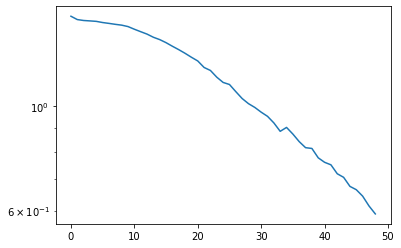

In [60]:
plot_learning_rate(all_history, start_epoch=0, end_epoch=-1)

In [61]:
def plot_learning_curves(metric, validation, epoch_show_from=0):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
    # metric
    ax[0][0].plot(all_history[metric][epoch_show_from:])
    ax[0][0].legend([f'training {metric}'])
    ax[0][0].set_title(metric)
    # loss
    ax[0][1].plot(all_history['loss'][epoch_show_from:])
    ax[0][1].legend([f'training loss'])
    ax[0][1].set_title('loss')

    if validation:
        # metric
        ax[1][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
        ax[1][0].legend([f'validation {metric}'])
        ax[2][0].plot(all_history[metric][epoch_show_from:])
        ax[2][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
        ax[2][0].legend([f'training {metric}',f'validation {metric}'])

        # loss
        ax[1][1].plot(all_history[f'val_loss'][epoch_show_from:])
        ax[1][1].legend([f'validation loss'])
        ax[2][1].plot(all_history['loss'][epoch_show_from:])
        ax[2][1].plot(all_history[f'val_loss'][epoch_show_from:])
        ax[2][1].legend([f'training loss',f'validation loss'])
    else:
        ax[2][0].legend(['train'])
        ax[2][1].legend(['train'])

    training_curves = plt.gca()
    return training_curves

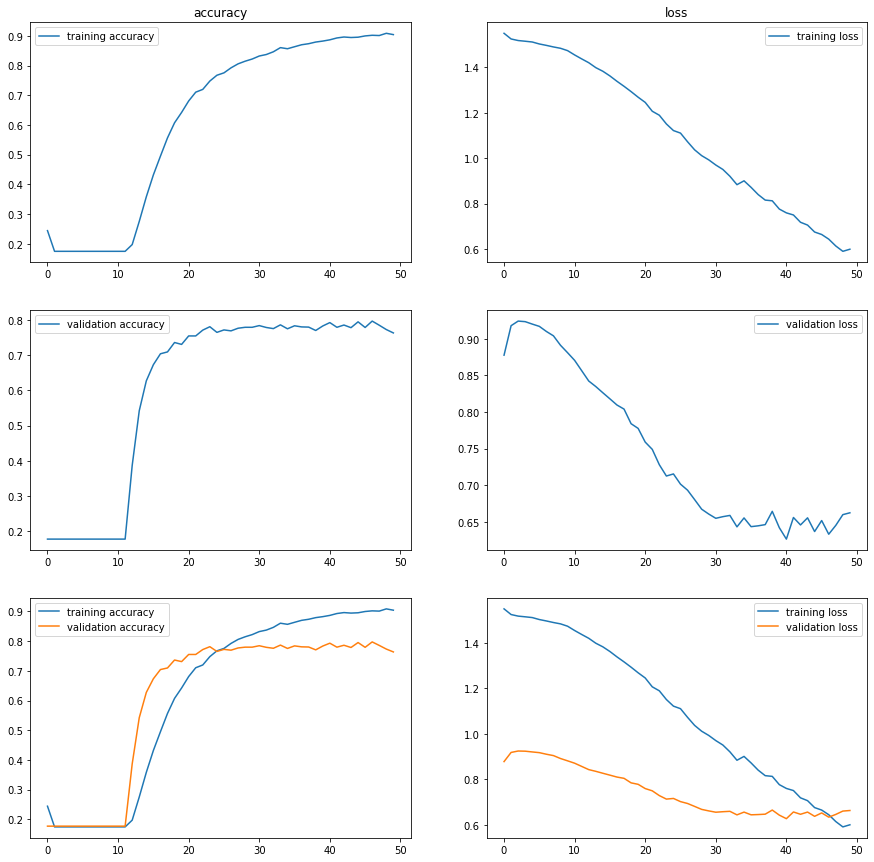

In [62]:
metric = 'root_mean_squared_error' if var.problem_type == 'regression' else 'accuracy'

training_curves = plot_learning_curves(metric, validation, epoch_show_from=0)

In [63]:
#del_unneeded_checkpoints(checkpoint_path_base, all_history, metric)

In [64]:
def explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base, all_history, model,
                 load_model=True):
    val_metric = f'val_{metric}' if not man_val_metric else man_val_metric
    if man_epoch_idx:
        print('load weights from epoch', man_epoch_idx)
        checkpoint_path = f'{checkpoint_path_base}/model_epoch-{man_epoch_idx}.ckpt'
        best_idx = man_epoch_idx - 1
    else:
        if val_metric in ['val_root_mean_squared_error', 'val_loss', 'loss']:
            best_idx = np.argmin(all_history[val_metric])
        else:
            best_idx = np.argmax(all_history[val_metric])
            
    best_acc = round((all_history[val_metric][best_idx]), 4)
    print(f'best {val_metric}: {best_acc} | epoch={best_idx + 1}')
    checkpoint_path = f'{checkpoint_path_base}/model_epoch-{best_idx + 1}.ckpt'
    
    if load_model:
        print(f'Loaded weights')
        model.load_weights(checkpoint_path)
    return model, checkpoint_path, best_acc, best_idx + 1

In [65]:
man_epoch_idx = 0 #Set to 0 or False to choose best accuracy, otherwise choose epoch to load
man_val_metric = 'val_loss' #False 'val_loss' 'loss', 'accuracy'

(model, checkpoint_path,
 best_acc, best_idx) = explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base,
                                     all_history, model, load_model=True)

best val_loss: 0.6265 | epoch=41
Loaded weights


In [66]:
review_set = 'valid'
eval_raw = model.evaluate(input_data[f'x_{review_set}'],
                          input_data[f'y_{review_set}'], verbose=0)
eval_result = dict(zip(['loss', metric], np.round(eval_raw ,3)))
print(eval_result)

{'loss': 0.627, 'accuracy': 0.793}


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



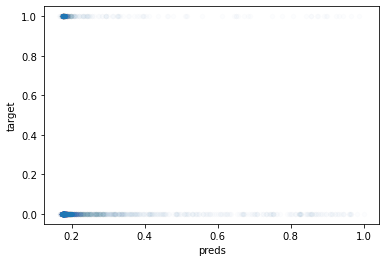

here
{'loss': 0.614, 'accuracy': 0.798}
fees proportion of target: 0.0817
-----
test
Accuracy (manual calc): 0.798
Sharpe: -2.72


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



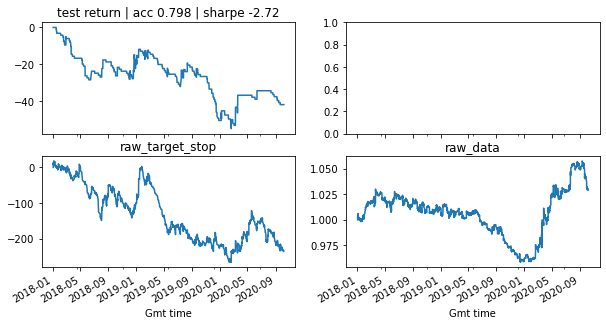

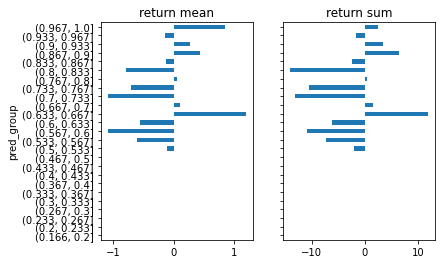

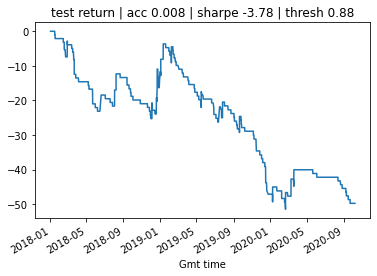

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



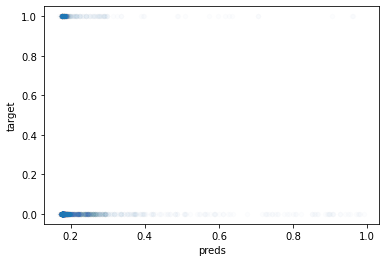

here
{'loss': 0.627, 'accuracy': 0.793}
fees proportion of target: 0.0669
-----
valid
Accuracy (manual calc): 0.793
Sharpe: -2.35


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



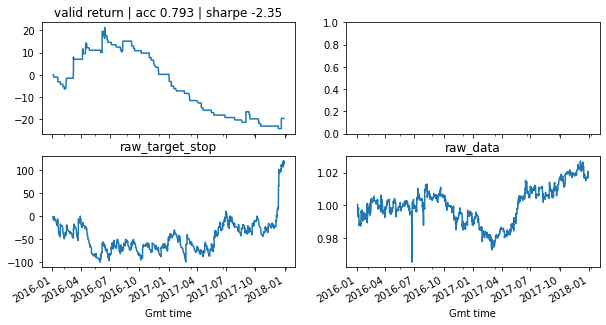

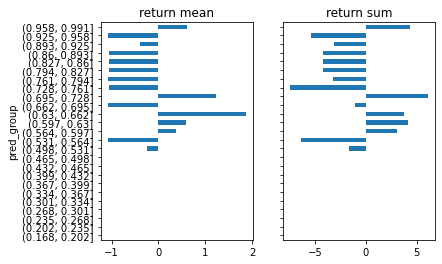

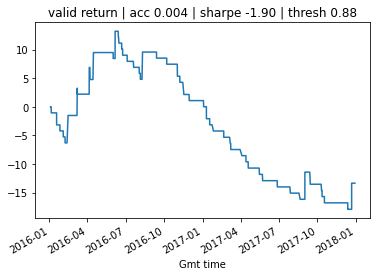

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



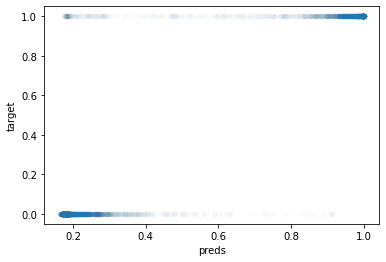

here
{'loss': 0.315, 'accuracy': 0.978}
fees proportion of target: 0.0582
-----
train
Accuracy (manual calc): 0.978
Sharpe: 40.06


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



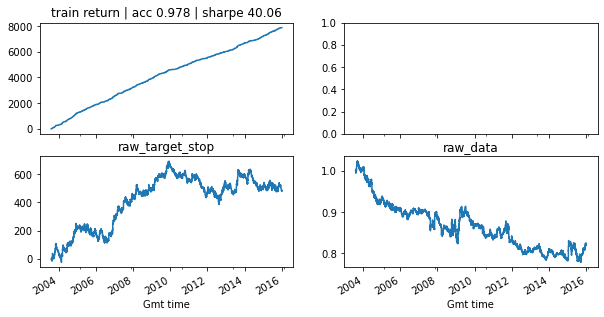

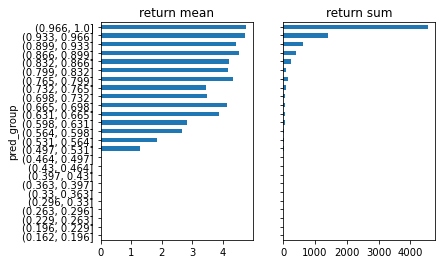

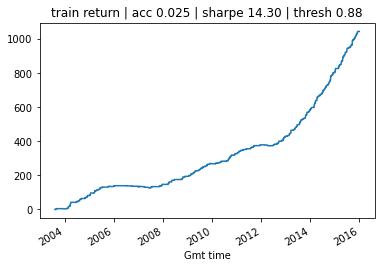

In [67]:
def evaluate_model(model, input_data, metric, review_set, label='target', plot_preds=True):
    # get loss and accuracy for review set
    eval_raw = model.evaluate(input_data[f'x_{review_set}'],
                              input_data[f'y_{review_set}'], verbose=0)
    eval_result = dict(zip(['loss', metric], np.round(eval_raw ,3)))    
    pred = model.predict(input_data[f'x_{review_set}'])
    if var.problem_type == 'binary':
        preds = pd.Series(pred.flatten())
        pred_cols = ['preds']
    elif var.problem_type == 'category':
        category_preds = pd.Series(pred.argmax(axis=1))
        category_preds.index = input_data[review_set].index
        input_data[review_set]['category_preds'] = category_preds
        preds = pd.Series(pred[range(len(pred)), pred.argmax(axis=1)])
        pred_cols = ['preds', 'category_preds']
    preds.index = input_data[review_set].index
    input_data[review_set]['preds'] = preds
    test_results = input_data[review_set][[label] + pred_cols].copy()
    test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']

    if plot_preds:
        # plot scatter of preds vs label
        test_results.plot.scatter(x='preds', y=label, alpha=0.01); plt.show()
    print('here')
    return eval_result, test_results


def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def calc_returns(test_results, review_set, label='target', close_diff_col='ohlc_diff_close', 
                 time_frame='1H', fees=0.0001):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
    if var.problem_type == 'binary':
        test_results['binary_pred'] = (test_results['preds'] >= 0.5).astype(int)
        test_results['trade_map'] = test_results['binary_pred']#.replace(0, -1)
    elif var.problem_type == 'category':
        test_results['binary_pred'] = test_results['category_preds']
        test_results['trade_map'] = test_results['category_preds'] - 1
    fees_pct = (fees / input_data[review_set]['child_pct']) * np.abs(test_results['perc_target_stop'])
    print(f"fees proportion of target: {(fees / input_data[review_set]['child_pct']).mean():.4f}")
    test_results['return'] = ((test_results['perc_target_stop'] * test_results['trade_map'])
                              - (test_results['trade_map'] * fees_pct))
    test_results['correct'] = ((test_results[label] == test_results['binary_pred']).astype(int))
    acc = test_results['correct'].mean()
    sharpe = calc_sharpe(test_results['return'], time_frame, scale_returns=0.01)
    print('-----')
    print(review_set)
    print(f"Accuracy (manual calc): {acc:.3f}")
    print(f"Sharpe: {sharpe:.2f}")
    
    # plot charts     
    test_results['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f}', ax=ax[0,0])
    (input_data[review_set][close_diff_col] + 1).cumprod().plot(title='raw_data', ax=ax[1,1])
    test_results['perc_target_stop'].cumsum().plot(title='raw_target_stop', ax=ax[1,0])
    returns_plot = plt.gca()      
    return returns_plot, test_results, sharpe

          
def threshold_trades(test_results, var, inner_thresh):
    threshold_data = test_results[['preds', 'return']]
    threshold_data['pred_group'] = pd.cut(threshold_data['preds'], bins=25)
    table_data = threshold_data.groupby('pred_group')
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    table_data.mean()['return'].plot.barh(title='return mean', ax=ax[0])
    table_data.sum()['return'].plot.barh(title='return sum', ax=ax[1])
    plt.show()

    subset = threshold_data[(threshold_data['preds'] < inner_thresh) 
                         # & (threshold_data['preds'] > (1 - inner_thresh))
                           ]
    acc = (subset['return'] > 0).sum() / len(subset)
    sharpe = calc_sharpe(subset['return'], time_frame=var.resample, scale_returns=0.01)
    subset['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f} | thresh {inner_thresh}')
    plt.show()
          

var.fees = 0.0001 # 0.0001
for review_set in ['test', 'valid', 'train']: #'upsample_test'
# for review_set in ['test']:
    eval_result, test_results = evaluate_model(model, input_data, metric, review_set, label='target',
                                               plot_preds=True) #label='target'     
    print(eval_result)
    returns_plot, test_results, sharpe = calc_returns(test_results, review_set, label='target',
                                                      close_diff_col='ohlc_diff_close',
                                                      time_frame=var.resample, fees=var.fees)

    threshold_trades(test_results, var, inner_thresh=0.88)

In [68]:
raise Expection('stop here')

NameError: name 'Expection' is not defined

## Baysian NN

In [ ]:
var.drop_rate = 0.5
model_bayes = get_model_arch(var.model_arch, var)
weights = model.get_weights()
model_bayes.set_weights(weights)

review_set = 'test' #upsample_test, test, train, valid

preds = [model_bayes(input_data[f'x_{review_set}'], training=True).numpy() for _ in range(500)]
if var.problem_type == 'binary':
    preds_df = pd.DataFrame(np.hstack(preds))
elif var.problem_type == 'category':
    preds_df = [p[range(len(p)), p.argmax(axis=1)] for p in preds]
    preds_df = pd.DataFrame(preds_df).transpose()

In [ ]:
preds_df['mean'] = preds_df.mean(axis=1)
preds_df['std'] = preds_df.std(axis=1)
preds_df['perc'] = input_data[review_set]['perc_target_stop'].values
preds_df['trade_map'] = (preds_df['mean'] >= 0.5).astype(int).replace({0:-1})
preds_df['return'] = preds_df['trade_map'] * preds_df['perc']

for group_col in ['std', 'mean']:
    group_data = preds_df[[group_col, 'return']]
    group_data[group_col] = pd.cut(group_data[group_col], bins=20, precision=0)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    for i, func in enumerate(['mean', 'sum']):
        getattr(group_data.groupby(group_col), func)().plot.barh(ax=ax[i],
                                                                 title=f'{group_col} {func}')
    plt.show()
    
preds_df.index = input_data[review_set].index

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def calc_r2_equity(returns):
    '''
    A performance metric (made up by me) that falls between 0-1 generally.
    It is the r2 of the equity curve and a linear fitted line, to the power of 10, 
    which penalizes lower scores more heavily.
    This is a great metric to checking a consistant linearly increasing equity curve;
    however, it penalizes inconsistancy a little too much, so should be used alongside 
    the sharpe ratio, preferably sharpe_ratio * r2_trend to give us an adjusted sharpe
    '''
    idx = np.arange(len(returns))
    curve = returns.cumsum().values

    linreg = LinearRegression()
    linreg.fit(idx.reshape(-1,1), curve)
    idx_lin = linreg.predict(idx.reshape(-1,1))

    r2_equity = r2_score(idx_lin, curve) ** 2
    return r2_equity


def calc_dd_time_metric(returns):
    '''
    A performance metric (made up by me) that falls between 0-1.
    We calculate the maxuimum time in a draw down in days and then divide it by 365.
    We then square it to penalize larger drawdowns more.
    '''
    equity = subset['return'].cumsum()
    equity_dd = equity - equity.cummax()
    time_dd = pd.Series(equity_dd[equity_dd == 0].index)
    max_dd_time = time_dd.diff().max() / timedelta(days=365)
    print('dd_time', time_dd.diff().max())
    dd_time_metric = (1 - max_dd_time) ** 2
    return dd_time_metric
    
    
def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def adjusted_sharpe(r2_equity, dd_time_metric):
    return (2 * r2_equity * dd_time_metric) / (r2_equity + dd_time_metric)

In [ ]:
thresh = 0.4
std_thresh = 0.9
threshold_data = preds_df[['return','mean','std']]
subset = threshold_data[
    (
        (threshold_data['mean'] <= thresh) 
#        | (threshold_data['mean'] <= (1 - thresh))
    ) &
    (
        (threshold_data['std'] <= std_thresh) 
    )
]
print(f'# trades: {len(subset)} keep ratio: {len(subset) / len(threshold_data):.2f}')
sharpe = calc_sharpe(subset['return'], time_frame=var.resample, scale_returns=0.01)
r2_equity = calc_r2_equity(subset['return'])
dd_time_metric = calc_dd_time_metric(subset['return'])
final_adj = adjusted_sharpe(r2_equity, dd_time_metric)
acc = (subset['return'] > 0).sum() / len(subset)
subset['return'].cumsum().plot(
    title=f'{review_set} return | acc {acc:.3f} | adj_sharpe {final_adj:.2f} | thresh {thresh} \n'
        f' | sharpe {sharpe:.2f} | r2_equity {r2_equity:.2f} | dd_time_metric {dd_time_metric:.2f} |')
plt.show()
acc = (input_data[f'{review_set}']['perc_target_stop'] > 0).sum() / len(input_data[f'{review_set}'])
(input_data[f'{review_set}']['perc_target_stop'] * 0.01).cumsum().plot(title=f'raw | acc {acc:.3f}')

In [ ]:
raise Exception('stop here!')

In [ ]:
def copy_model_and_checkpoint_files(model, metric, checkpoint_path_base,
                                    experiment_model_path, var):
    # save model architecture
    model.save(f'{experiment_model_path}/model.ckpt')
    var.experiment_model_path = experiment_model_path
    
    # get checkpoint for best val_accuracy and val_loss
    for man_val_metric in [False, 'val_loss', 'loss', metric]:
        (model, checkpoint_path,
         best_acc, best_idx) = explore_epoch(metric, man_epoch_idx, man_val_metric,
                                             checkpoint_path_base, all_history, model,
                                             load_model=False)
        # copy saved checkpoint files to experiment directory
        val_metric = f'val_{metric}' if not man_val_metric else man_val_metric
        for f in os.listdir(checkpoint_path_base):
            check_file = checkpoint_path.split('/')[-1]
            if check_file in f:
                shutil.copy(f'{checkpoint_path_base}/{f}', experiment_model_path)
                setattr(var, f'cp_best_{val_metric}', f'{experiment_model_path}/{check_file}')      
                setattr(var, f'best_{val_metric}', best_acc)
                setattr(var, f'epoch_best_{val_metric}', best_idx)
                
                
def save_all_model_info(experiment_path, model, metric, checkpoint_path_base, input_data,
                        loaded_files, all_history, training_curves, label, var):
    time_str = datetime.now().strftime('%d-%m-%y_%H-%M-%S')
    experiment_model_path = f'{experiment_path}/model_checkpoints_experiments/{time_str}'
    copy_model_and_checkpoint_files(model, metric, checkpoint_path_base, experiment_model_path, var) 
       
    for review_set in ['train', 'valid', 'test']:
        eval_result, test_results = evaluate_model(model, input_data, metric, review_set=review_set,
                                                   label=label, plot_preds=False)
        print(eval_result)
        returns_plot, test_results, sharpe = calc_returns(test_results, review_set=review_set,
                                                          label=label, close_diff_col=close_diff_col,
                                                          time_frame=var.resample)
        returns_plot.figure.savefig(f'{experiment_model_path}/return_plot_{review_set}.jpg')
        setattr(var, f'sharpe_{review_set}', sharpe)
    training_curves.figure.savefig(f'{experiment_model_path}/training_curves.jpg')
    
    var.best_test_loss = eval_result['loss']
    setattr(var, f'best_test_{metric}', eval_result[metric])
    var.created_time = time_str
    var.loaded_files = set(loaded_files.keys())
    #var.all_history = all_history

    pickle_path = f"{experiment_path}/pickled_vars/{time_str}.pkl"
    pickle.dump(vars(var), open(pickle_path, 'wb'))
    print('finished saving!')

In [ ]:
var.info = '5 consecutive bar filter NOT bollinger band'

In [ ]:
save_experiment = True #bool


label = 'target' #  'target'
close_diff_col = 'ohlc_diff_close' # 'ohlc_diff_close' , 'daily_return'
if save_experiment:
    save = input('Are you sure you want to save model, y/n?: ')
    if save == 'y':        
        experiment_path = f'B:/Algo_Trading'
        save_all_model_info(experiment_path, model, metric, checkpoint_path_base, input_data,
                            loaded_files, all_history, training_curves, label, var)
        load_and_save_experiments(experiment_path)